# FNN PyTorch Approach AND Privacy Approach

In [14]:
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())

2.5.1
True


In [15]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

path = 'Salary_Data.csv'

df = pd.read_csv(path)
df.head()

Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0

# Data Cleaning

In [16]:
df['Education Level'] = df['Education Level'].replace("Bachelor's Degree", "Bachelor's")
df['Education Level'] = df['Education Level'].replace("phD", "PhD")
df['Education Level'] = df['Education Level'].replace("Master's Degree", "Master's")

df['Education Level'].value_counts()

Education Level
Bachelor's     3023
Master's       1861
PhD            1369
High School     448
Name: count, dtype: int64

In [17]:
df['Education Level'] = pd.Categorical(df['Education Level'], categories=['High School', 'Bachelor\'s', 'Master\'s', 'PhD'], ordered=True)

In [18]:
df = df.groupby('Job Title').filter(lambda x: len(x) > 100)

In [19]:
job_list = df['Job Title'].unique()

In [20]:
df.shape

(4543, 6)

# Prepare data

In [21]:
import joblib
from torch.utils.data import TensorDataset
education_mapping = {'High School': 0, 'Bachelor\'s': 1, 'Master\'s': 2, 'PhD': 3}
df['Education Level'] = df['Education Level'].map(lambda x: education_mapping.get(x, x)).copy()

df = df[df['Gender'] != 'Other']
gender_mapping = {'Male': 0, 'Female': 1}
df['Gender'] = df['Gender'].map(lambda x: gender_mapping.get(x, x)).copy()

df = df.dropna()

train, test = train_test_split(df, test_size=0.2, random_state=42)

target_column = "Salary"
sensitive_feature = ['Age', 'Gender']
features = train.columns.difference([target_column])

scaler = StandardScaler()
train[['Years of Experience', 'Age']] = scaler.fit_transform(train[['Years of Experience', 'Age']])
test[['Years of Experience', 'Age']] = scaler.transform(test[['Years of Experience', 'Age']])

salary_scaler = StandardScaler()

train['Salary'] = salary_scaler.fit_transform(train[['Salary']])
test['Salary'] = salary_scaler.transform(test[['Salary']])

encoder = LabelEncoder()
train['Job Title'] = encoder.fit_transform(train['Job Title'])
test['Job Title'] = encoder.transform(test['Job Title'])

X_train = pd.DataFrame((train),columns = features)
y_train = pd.DataFrame((train),columns = [target_column])
X_test = pd.DataFrame((test),columns = features)
y_test = pd.DataFrame((test),columns = [target_column])

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.squeeze().values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.squeeze().values, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [22]:
def evaluate_model_on_original_scale(model, data_loader, salary_scaler):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            predictions.extend(y_pred.cpu().numpy())
            targets.extend(y_batch.cpu().numpy())

    # Convert predictions and targets back to the original scale
    predictions_original_scale = salary_scaler.inverse_transform(predictions)
    targets_original_scale = salary_scaler.inverse_transform(targets)

    # Calculate the average error (Mean Absolute Error)
    average_error = np.mean(np.abs(predictions_original_scale - targets_original_scale))

    return predictions_original_scale, targets_original_scale, average_error


In [23]:
X_train_tensor

tensor([[-0.4859,  2.0000,  1.0000,  0.0000, -0.3822],
        [ 1.4264,  3.0000,  0.0000,  2.0000,  1.7294],
        [-0.9959,  1.0000,  0.0000,  1.0000, -0.8695],
        ...,
        [ 0.9165,  3.0000,  0.0000,  2.0000,  0.7548],
        [-1.1234,  1.0000,  1.0000, 10.0000, -1.0319],
        [ 0.4065,  2.0000,  0.0000, 13.0000,  0.1051]])

# Define Model for best configuration search

In [24]:
class SalaryPredictor(nn.Module):
    def __init__(self, input_size, layers, activation_function, dropout_rate=0.0):
        super(SalaryPredictor, self).__init__()
        self.layers = nn.ModuleList()
        self.activation_function = activation_function
        self.dropout_rate = dropout_rate

        prev_size = input_size
        for layer_size in layers:
            self.layers.append(nn.Linear(prev_size, layer_size))
            prev_size = layer_size
        self.output = nn.Linear(prev_size, 1)

        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = self.activation_function(x)
            x = self.dropout(x)
        x = self.output(x)
        return x


# Search for best model

In [70]:
import time
from sklearn.model_selection import KFold
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, Subset

activation_functions = {
    "ReLU": nn.ReLU(),
    # "Tanh": nn.Tanh(),
    # "Sigmoid": nn.Sigmoid(),
}

layer_configs = [
    # [128, 64, 32],     # 3 layers
    [256, 128, 64, 32] # 4 layers
]
optimizers = [
    optim.Adam,
    # optim.SGD,
]

learning_rates = [
    # 0.005,
    0.001,
    # 0.0005
] 
dropout_rate = 0.0 # Was the best found
num_epochs = 500
k_folds = 5
batch_size = 32

kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

best_model = None
best_params = None
best_val_loss = float('inf')

total_combinations = len(activation_functions) * len(layer_configs) * len(optimizers) * len(learning_rates)
time_per_combination = []
combination_count = 0

# Perform grid search
for activation_name, activation_function in activation_functions.items():
    for layers in layer_configs:
        for opt in optimizers:
            for learning_rate in learning_rates:
                combination_count += 1
                print(f"Testing Combination {combination_count}/{total_combinations}: "
                      f"Activation={activation_name}, Layers={layers}, Optimizer={opt.__name__}, Learning rate={learning_rate}")
                
                start_time = time.time() 
                fold_val_losses = []

                for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
                    train_subset = Subset(train_dataset, train_idx)
                    val_subset = Subset(train_dataset, val_idx)
                    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
                    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

                    model = SalaryPredictor(
                        input_size=X_train.shape[1],
                        layers=layers,
                        activation_function=activation_function,
                        dropout_rate=dropout_rate
                    )
                    optimizer = opt(model.parameters(), lr=learning_rate, weight_decay=0.001)
                    criterion = nn.MSELoss()

                    for epoch in range(num_epochs):
                        model.train()
                        for X_batch, y_batch in train_loader:
                            optimizer.zero_grad()
                            predictions = model(X_batch)
                            loss = criterion(predictions, y_batch)
                            loss.backward()
                            optimizer.step()
                            
                    model.eval()
                    val_preds = []
                    val_targets = []
                    with torch.no_grad():
                        for X_batch, y_batch in val_loader:
                            predictions = model(X_batch)
                            val_preds.append(predictions.numpy())
                            val_targets.append(y_batch.numpy())

                    val_preds = np.concatenate(val_preds)
                    val_targets = np.concatenate(val_targets)
                    val_loss = mean_squared_error(val_targets, val_preds)
                    fold_val_losses.append(val_loss)

                avg_val_loss = np.mean(fold_val_losses)
                print(f"Average Validation Loss (k-Fold): {avg_val_loss:.4f}")

                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_model = model
                    best_params = {
                        "activation": activation_name,
                        "layers": layers,
                        "optimizer": opt.__name__,
                        "learning_rate": learning_rate,
                        "val_loss": avg_val_loss,
                    }

                elapsed_time = time.time() - start_time
                print(f"Elapsed Time: {elapsed_time:.2f} seconds")
                time_per_combination.append(elapsed_time)
                
                avg_time_per_combination = np.mean(time_per_combination)
                remaining_combinations = total_combinations - combination_count
                estimated_time_remaining = avg_time_per_combination * remaining_combinations
                print(f"Estimated Time Remaining: {estimated_time_remaining / 60:.2f} minutes")

print(f"Best Parameters: {best_params}")

Testing Combination 1/3: Activation=ReLU, Layers=[256, 128, 64, 32], Optimizer=Adam, Learning rate=0.005
Average Validation Loss (k-Fold): 0.0701
Elapsed Time: 140.95 seconds
Estimated Time Remaining: 4.70 minutes
Testing Combination 2/3: Activation=ReLU, Layers=[256, 128, 64, 32], Optimizer=Adam, Learning rate=0.001
Average Validation Loss (k-Fold): 0.0525
Elapsed Time: 145.77 seconds
Estimated Time Remaining: 2.39 minutes
Testing Combination 3/3: Activation=ReLU, Layers=[256, 128, 64, 32], Optimizer=Adam, Learning rate=0.0005
Average Validation Loss (k-Fold): 0.0549
Elapsed Time: 143.25 seconds
Estimated Time Remaining: 0.00 minutes
Best Parameters: {'activation': 'ReLU', 'layers': [256, 128, 64, 32], 'optimizer': 'Adam', 'learning_rate': 0.001, 'val_loss': 0.0525086}


Final Eval

In [19]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_model.eval()
test_preds = []
test_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        predictions = best_model(X_batch)
        test_preds.append(predictions.numpy())
        test_targets.append(y_batch.numpy())

test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)
test_loss = mean_squared_error(test_targets, test_preds)
print(f"Test Loss: {test_loss:.4f}")

NameError: name 'batch_size' is not defined

# Define the best model

In [25]:
class SalaryPredictor(nn.Module):
    def __init__(self, input_size):
        super(SalaryPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

# Training For Data Scientist Job not important for prediction

In [26]:
print("Feature columns in X_train:", X_train.columns.tolist())

Feature columns in X_train: ['Age', 'Education Level', 'Gender', 'Job Title', 'Years of Experience']


### No Privacy FNN

In [30]:
import random
all_avg_errors_without_dp = []
final_err = []
model_no_privacy = SalaryPredictor(input_size=len(features))
optimizer_no_privacy = optim.Adam(model_no_privacy.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.MSELoss()

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for i in range(1): # Repetitions for averaging
    avg_errors_without_dp = []
    for epoch in range(501):
        model_no_privacy.train()
        for X_batch, y_batch in train_loader:
            optimizer_no_privacy.zero_grad()
            predictions = model_no_privacy(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer_no_privacy.step()
            
        # Evaluate periodically
        if epoch % 10 == 0:
            _, _, avg_error_without_dp = evaluate_model_on_original_scale(model_no_privacy, test_loader, salary_scaler)
            avg_errors_without_dp.append(avg_error_without_dp)
    
            # print(f"Epoch {epoch + 1}, Avg Error (Without DP): {avg_error_without_dp:.2f}")

        if epoch % 100 == 0:
            model_no_privacy.eval()
            test_preds = []
            test_targets = []
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    predictions = model_no_privacy(X_batch)
                    test_preds.append(predictions.numpy())
                    test_targets.append(y_batch.numpy())
    
            test_preds = np.concatenate(test_preds, axis=0)
            test_targets = np.concatenate(test_targets, axis=0)
            test_preds_unscaled = salary_scaler.inverse_transform(test_preds)
            test_targets_unscaled = salary_scaler.inverse_transform(test_targets)
            mse = mean_squared_error(test_targets_unscaled, test_preds_unscaled)
            avg_error = np.mean(np.abs(test_preds_unscaled - test_targets_unscaled))
            print(f"Epoch {epoch + 1}, Test MSE: {mse:.4f}")
            print(f"Epoch {epoch + 1}, Average Error: {avg_error:.2f}")
    
    # Final evaluation on the test set
    model_no_privacy.eval()
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model_no_privacy(X_batch)
            test_preds.append(predictions.numpy())
            test_targets.append(y_batch.numpy())
    
    test_preds = np.concatenate(test_preds, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)
    test_preds_unscaled = salary_scaler.inverse_transform(test_preds)
    test_targets_unscaled = salary_scaler.inverse_transform(test_targets)
    
    mse = mean_squared_error(test_targets_unscaled, test_preds_unscaled)
    avg_error = np.mean(np.abs(test_preds_unscaled - test_targets_unscaled))
    print(f"Final Test MSE: {mse:.4f}")
    print(f"Final Average Error: {avg_error:.2f}")
    final_err.append(avg_error)
    all_avg_errors_without_dp.append(avg_errors_without_dp)

Epoch 1, Avg Error (Without DP): 19915.77
Epoch 11, Avg Error (Without DP): 15044.13
Epoch 21, Avg Error (Without DP): 14716.66
Epoch 31, Avg Error (Without DP): 13324.93
Epoch 41, Avg Error (Without DP): 13200.01
Epoch 51, Avg Error (Without DP): 11659.49
Epoch 61, Avg Error (Without DP): 10877.29
Epoch 71, Avg Error (Without DP): 10657.76
Epoch 81, Avg Error (Without DP): 10943.23
Epoch 91, Avg Error (Without DP): 10357.69
Epoch 101, Avg Error (Without DP): 9810.81
Epoch 111, Avg Error (Without DP): 9091.63
Epoch 121, Avg Error (Without DP): 9243.48
Epoch 131, Avg Error (Without DP): 11243.52
Epoch 141, Avg Error (Without DP): 9170.42
Epoch 151, Avg Error (Without DP): 8521.99
Epoch 161, Avg Error (Without DP): 9064.75
Epoch 171, Avg Error (Without DP): 8623.36
Epoch 181, Avg Error (Without DP): 8419.73
Epoch 191, Avg Error (Without DP): 8262.39
Epoch 201, Avg Error (Without DP): 7933.85
Epoch 211, Avg Error (Without DP): 8619.11
Epoch 221, Avg Error (Without DP): 8939.64
Epoch 231, 

In [83]:
print(f"Average Error: {np.mean(final_err):.2f}")

Average Error: 6270.75


### Differential Privacy FNN

In [ ]:
import torch.optim as optim
from opacus import PrivacyEngine
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
import numpy as np
import random

all_avg_errors_with_dp = []
final_err_with_dp = []
train_loader_with_dp = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for run in range(1): 
    print(f"Run {run + 1}/10")
    
    avg_errors_with_dp = [] 

    model_with_dp = SalaryPredictor(input_size=len(features))
    optimizer = optim.Adam(model_with_dp.parameters(), lr=1e-3, weight_decay=1e-3)
    criterion = nn.MSELoss()

    privacy_engine = PrivacyEngine()
    model_with_dp, optimizer, train_loader_with_dp = privacy_engine.make_private(
        module=model_with_dp,
        optimizer=optimizer,
        data_loader=DataLoader(train_dataset, batch_size=32, shuffle=True),
        noise_multiplier=6,
        max_grad_norm=1.0,
    )

    for epoch in range(501):
        model_with_dp.train()
        for X_batch, y_batch in train_loader_with_dp:
            optimizer.zero_grad()
            predictions = model_with_dp(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

        if epoch % 10 == 0:
            _, _, avg_error_with_dp = evaluate_model_on_original_scale(model_with_dp, test_loader, salary_scaler)
            avg_errors_with_dp.append(avg_error_with_dp)
            # print(f"Epoch {epoch + 1}, Avg Error (With DP): {avg_error_with_dp:.2f}")
        
        if epoch % 100 == 0:
            model_with_dp.eval()
            test_preds = []
            test_targets = []
            with torch.no_grad():
                for X_batch, y_batch in DataLoader(test_dataset, batch_size=32, shuffle=False):
                    predictions = model_with_dp(X_batch)
                    test_preds.append(predictions.numpy())
                    test_targets.append(y_batch.numpy())

            test_preds = np.concatenate(test_preds, axis=0)
            test_targets = np.concatenate(test_targets, axis=0)
            test_preds_unscaled = salary_scaler.inverse_transform(test_preds)
            test_targets_unscaled = salary_scaler.inverse_transform(test_targets)

            mse_with_dp = mean_squared_error(test_targets_unscaled, test_preds_unscaled)
            avg_error_with_dp = np.mean(np.abs(test_preds_unscaled - test_targets_unscaled))
            print(f"Epoch {epoch + 1}, Test MSE (With DP): {mse_with_dp:.4f}")
            print(f"Epoch {epoch + 1}, Average Error (With DP): {avg_error_with_dp:.2f}")
            
    model_with_dp.eval()
    test_preds = []
    test_targets = []
    with torch.no_grad():
        for X_batch, y_batch in DataLoader(test_dataset, batch_size=32, shuffle=False):
            predictions = model_with_dp(X_batch)
            test_preds.append(predictions.numpy())
            test_targets.append(y_batch.numpy())

    # Convert predictions and targets to original scale
    test_preds = np.concatenate(test_preds, axis=0)
    test_targets = np.concatenate(test_targets, axis=0)
    test_preds_unscaled = salary_scaler.inverse_transform(test_preds)
    test_targets_unscaled = salary_scaler.inverse_transform(test_targets)

    # Compute final test metrics
    mse_with_dp = mean_squared_error(test_targets_unscaled, test_preds_unscaled)
    avg_error_with_dp = np.mean(np.abs(test_preds_unscaled - test_targets_unscaled))
    print(f"Final Test MSE (With DP): {mse_with_dp:.4f}")
    print(f"Final Average Error (With DP): {avg_error_with_dp:.2f}")

    final_err_with_dp.append(avg_error_with_dp)
    all_avg_errors_with_dp.append(avg_errors_with_dp)
    delta = 1 / len(train_dataset)
    epsilon = privacy_engine.get_epsilon(delta)
    print(f"ε = {epsilon:.2f} delta={delta}")

# Print summary across all runs
print("\nFinal Results Across Runs:")
print(f"Mean Average Error (With DP): {np.mean(final_err_with_dp):.4f}")
print(f"Standard Deviation of Error (With DP): {np.std(final_err_with_dp):.4f}")


# Plot Results of FNN vs DP FNN

In [35]:
epochs = range(0, 501, 10)

avg_avg_errors_with_dp = np.mean(all_avg_errors_with_dp, axis=0)
avg_avg_errors_without_dp = np.mean(all_avg_errors_without_dp, axis=0)

plt.figure(figsize=(10, 6))
plt.figure(dpi=300)
plt.plot(epochs, avg_avg_errors_with_dp, label="With DP")
plt.plot(epochs, avg_avg_errors_without_dp, label="Without DP")
plt.xlabel("Epochs")
plt.ylabel("Average Salary Difference")
plt.title("Average Salary Difference with and without Differential Privacy")
plt.legend()
plt.show()

# Evaluate Final Models on Test Set
print("Final evaluation on test set...")

# Evaluate model with DP
_, _, avg_error_dp_test = evaluate_model_on_original_scale(model_with_dp, test_loader, salary_scaler)
print(f"Average Test Error (With DP): {avg_error_dp_test:.2f}")

# Evaluate model without DP
_, _, avg_error_no_dp_test = evaluate_model_on_original_scale(model_no_privacy, test_loader, salary_scaler)
print(f"Average Test Error (Without DP): {avg_error_no_dp_test:.2f}")

NameError: name 'all_avg_errors_without_dp' is not defined

# Is Uni worth it?
This is done with the Privacy model and iterated over all job titles

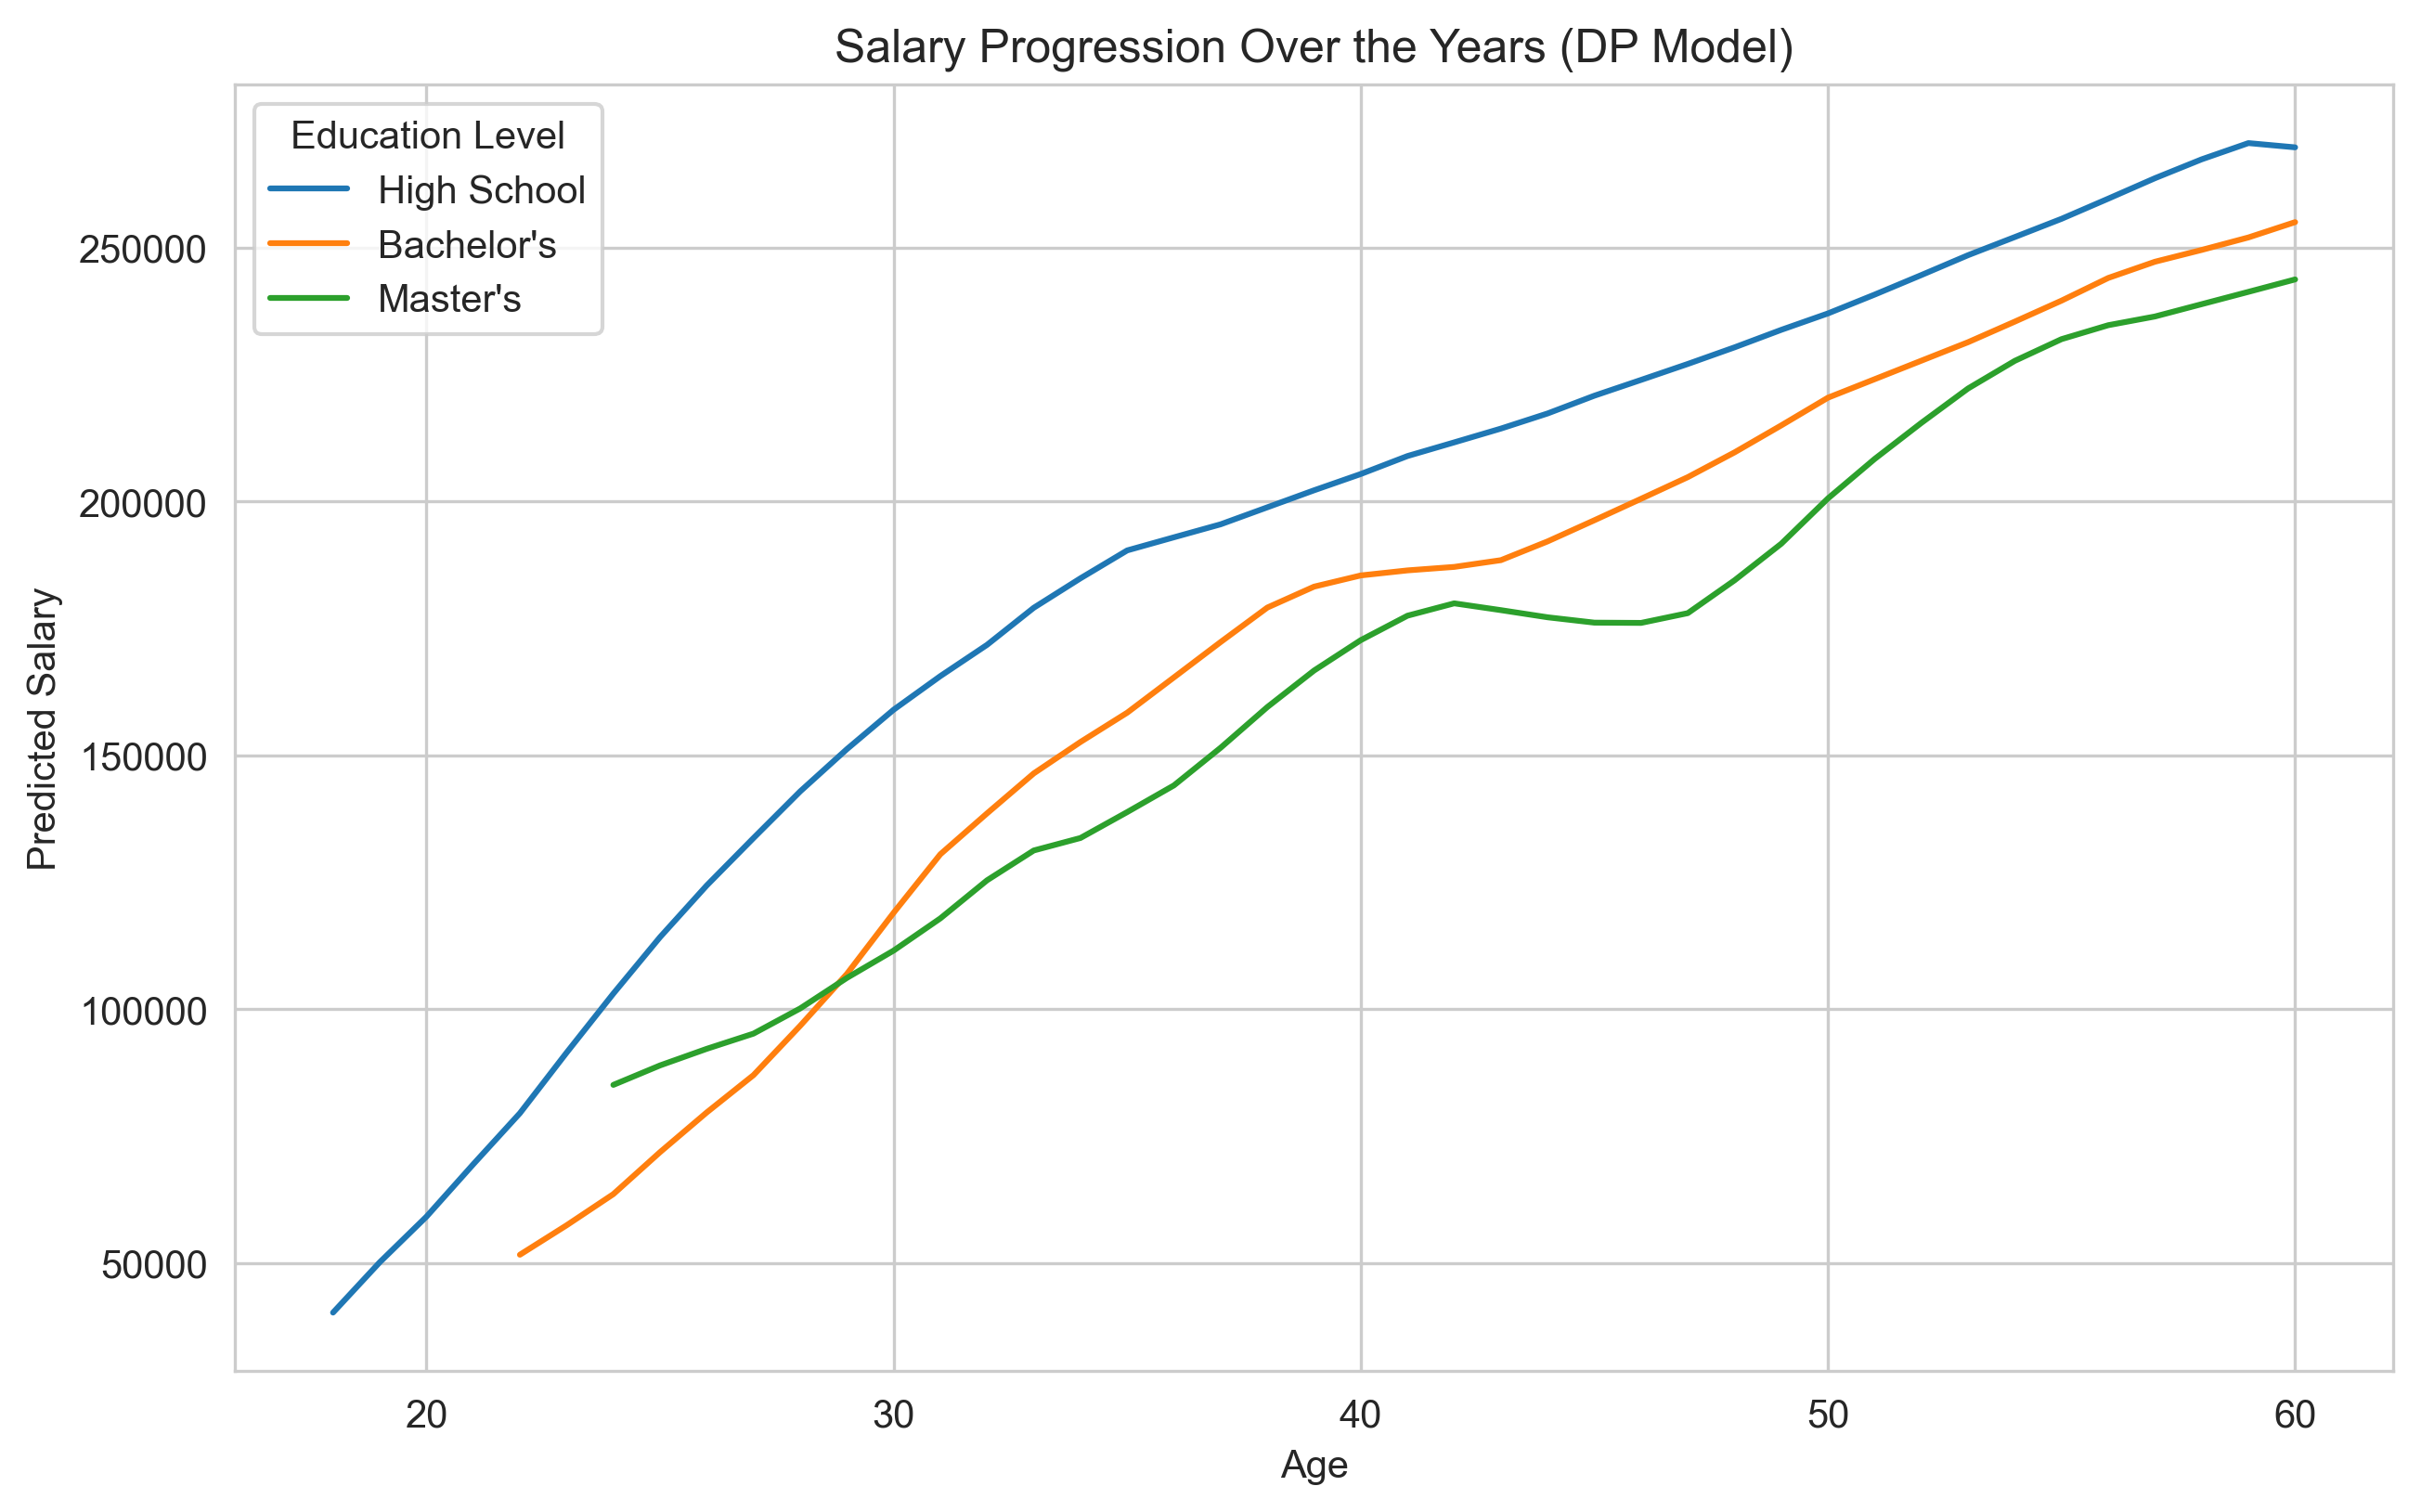

Best education for Job Title: Software Engineer is High School


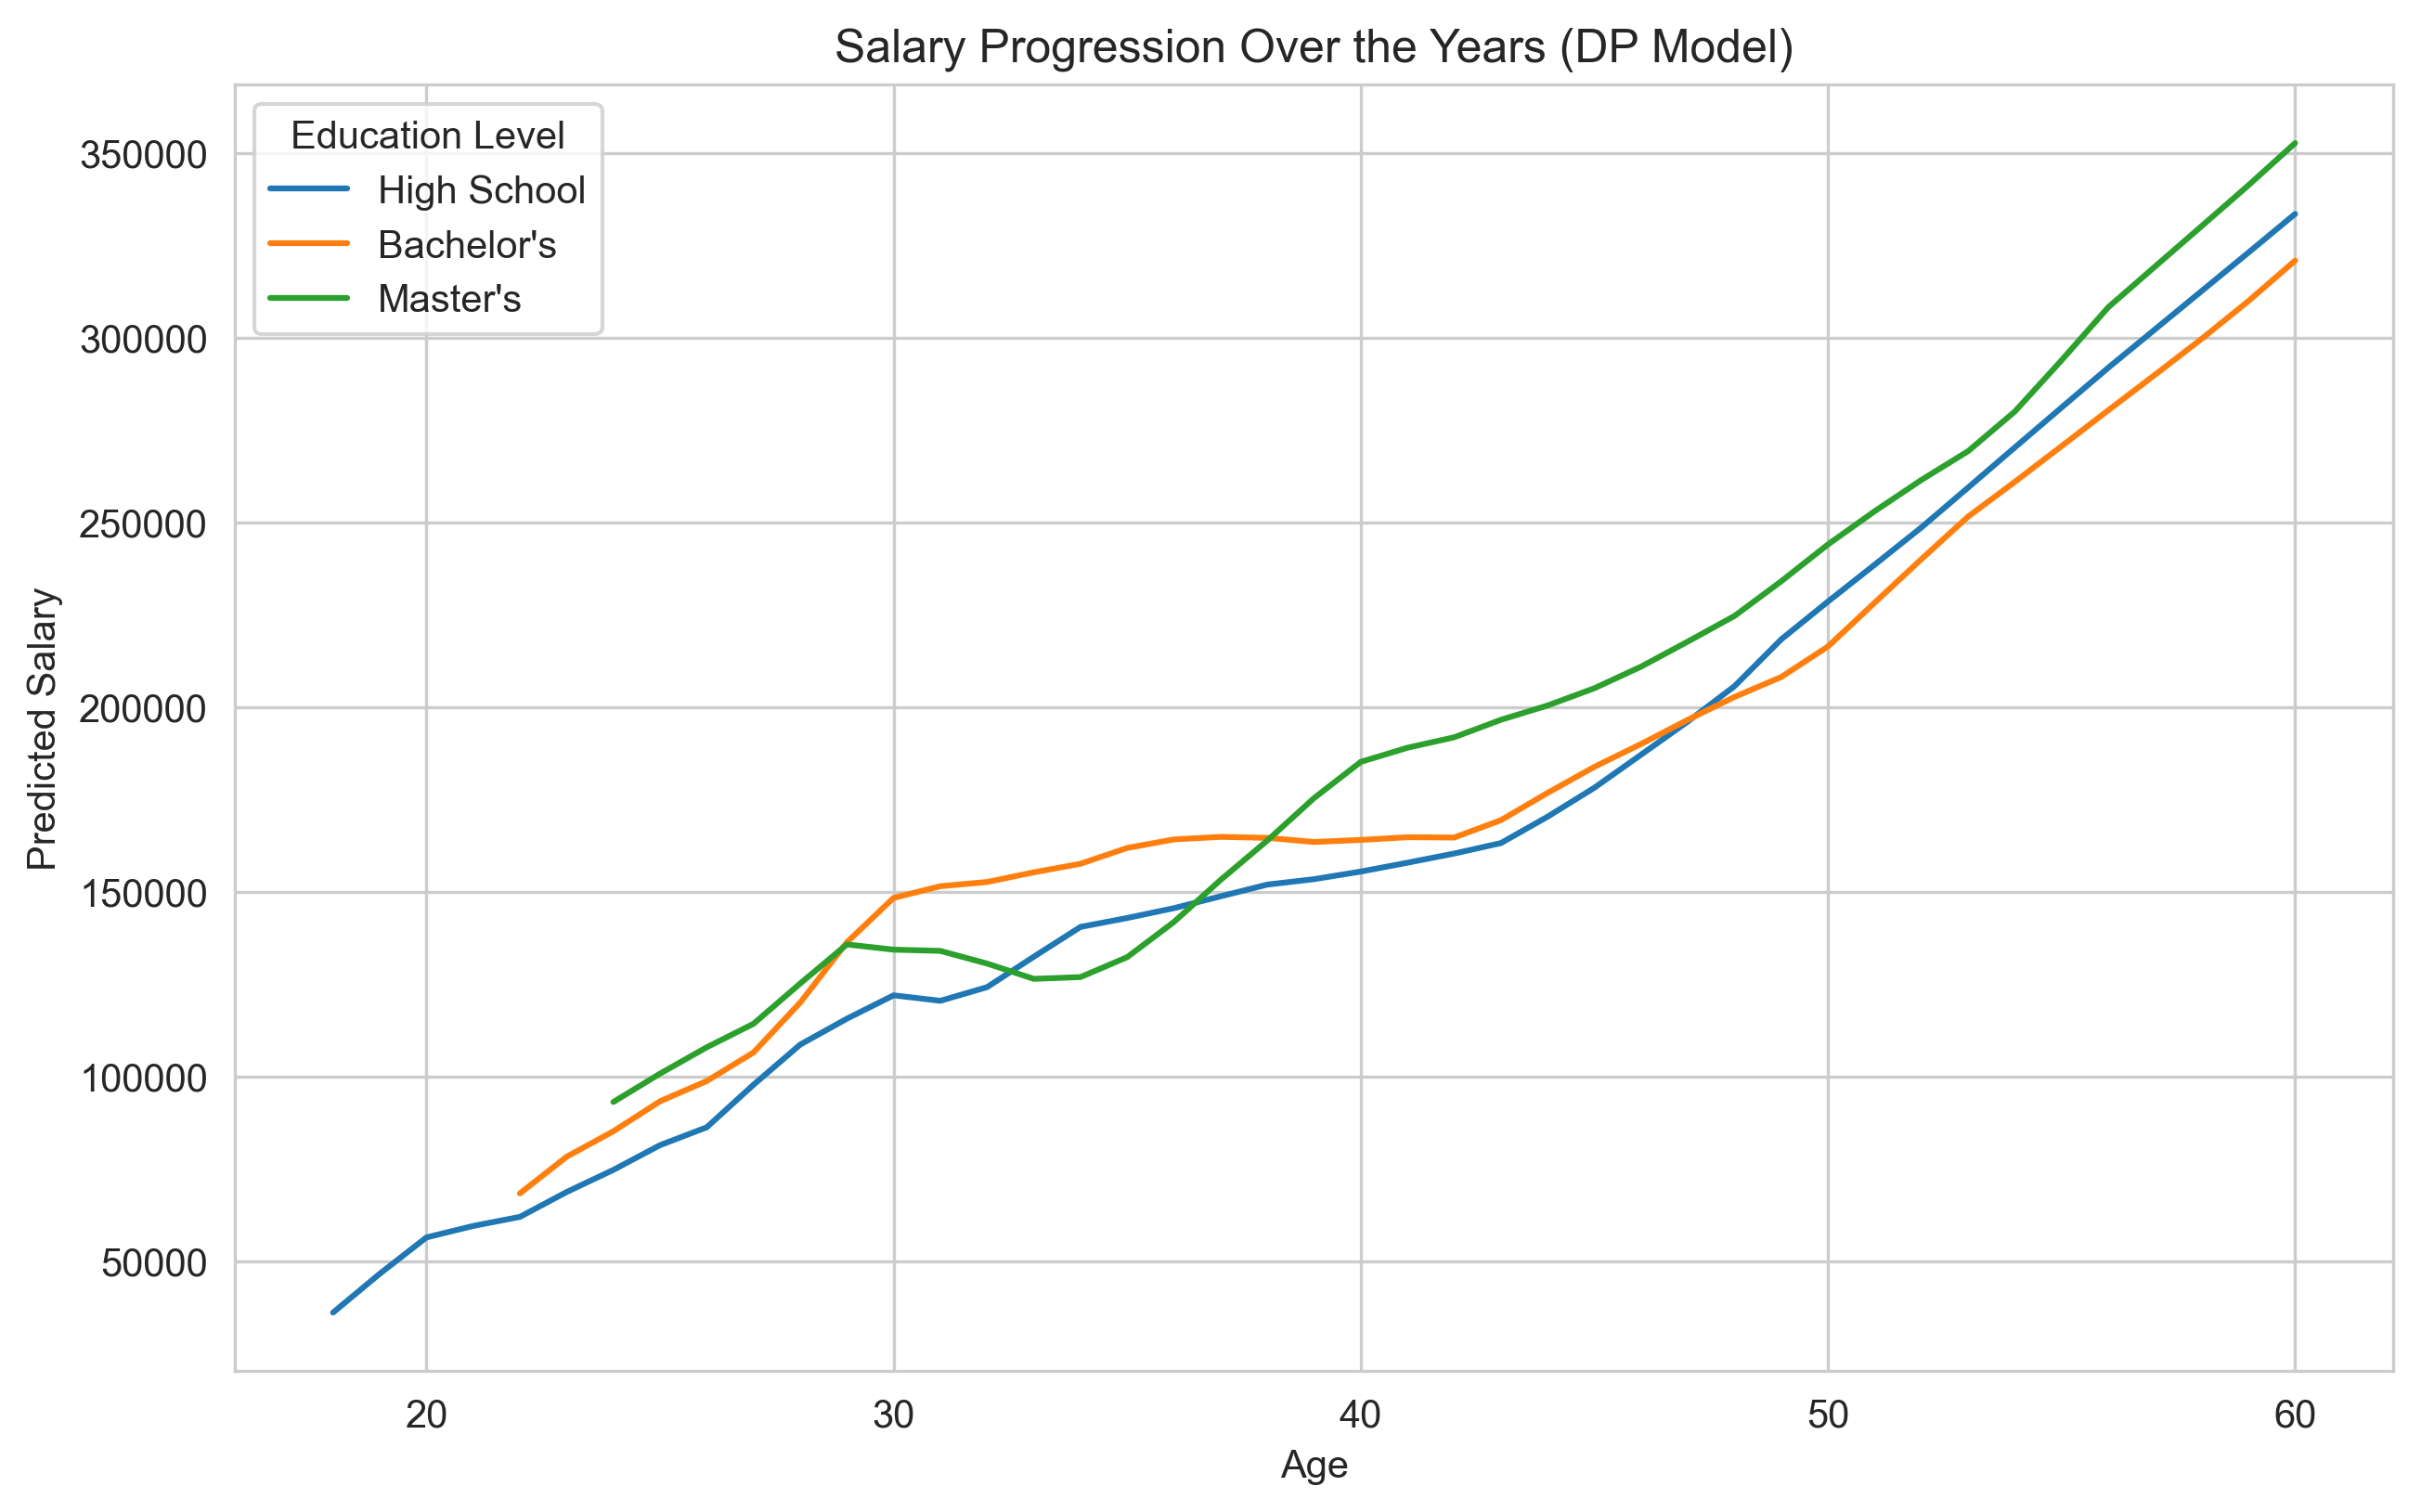

Best education for Job Title: Data Analyst is Master's


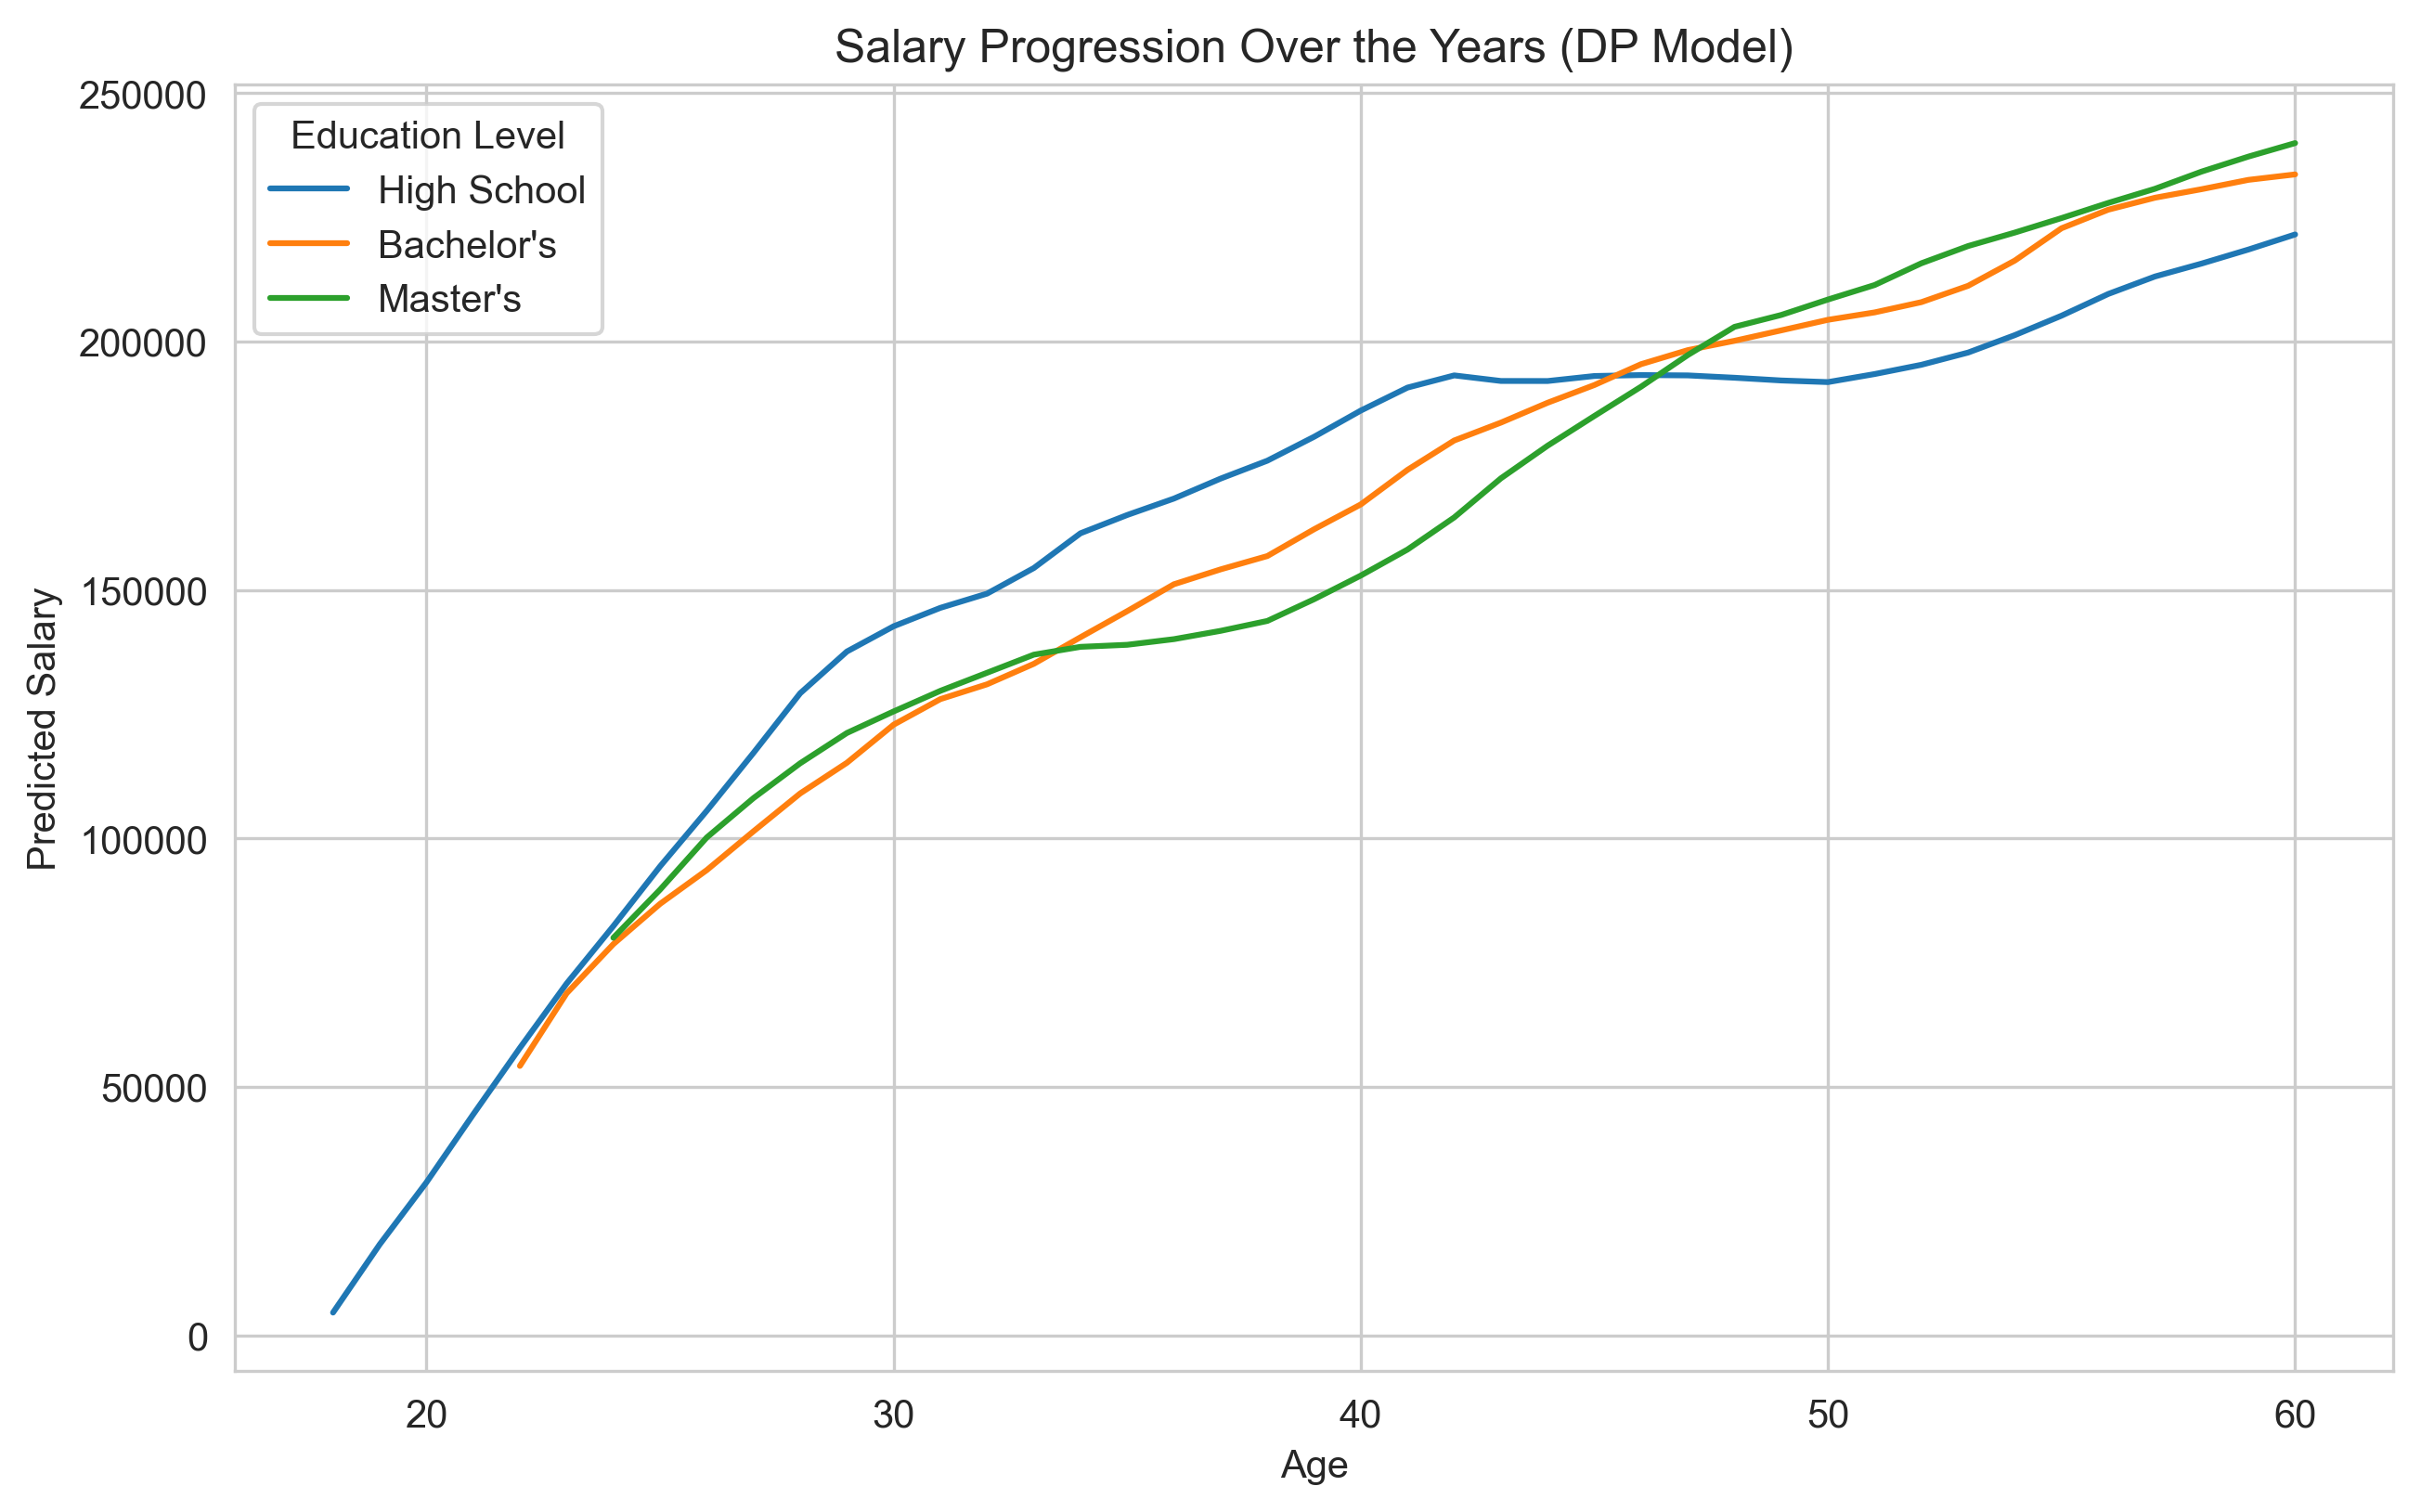

Best education for Job Title: Marketing Analyst is High School


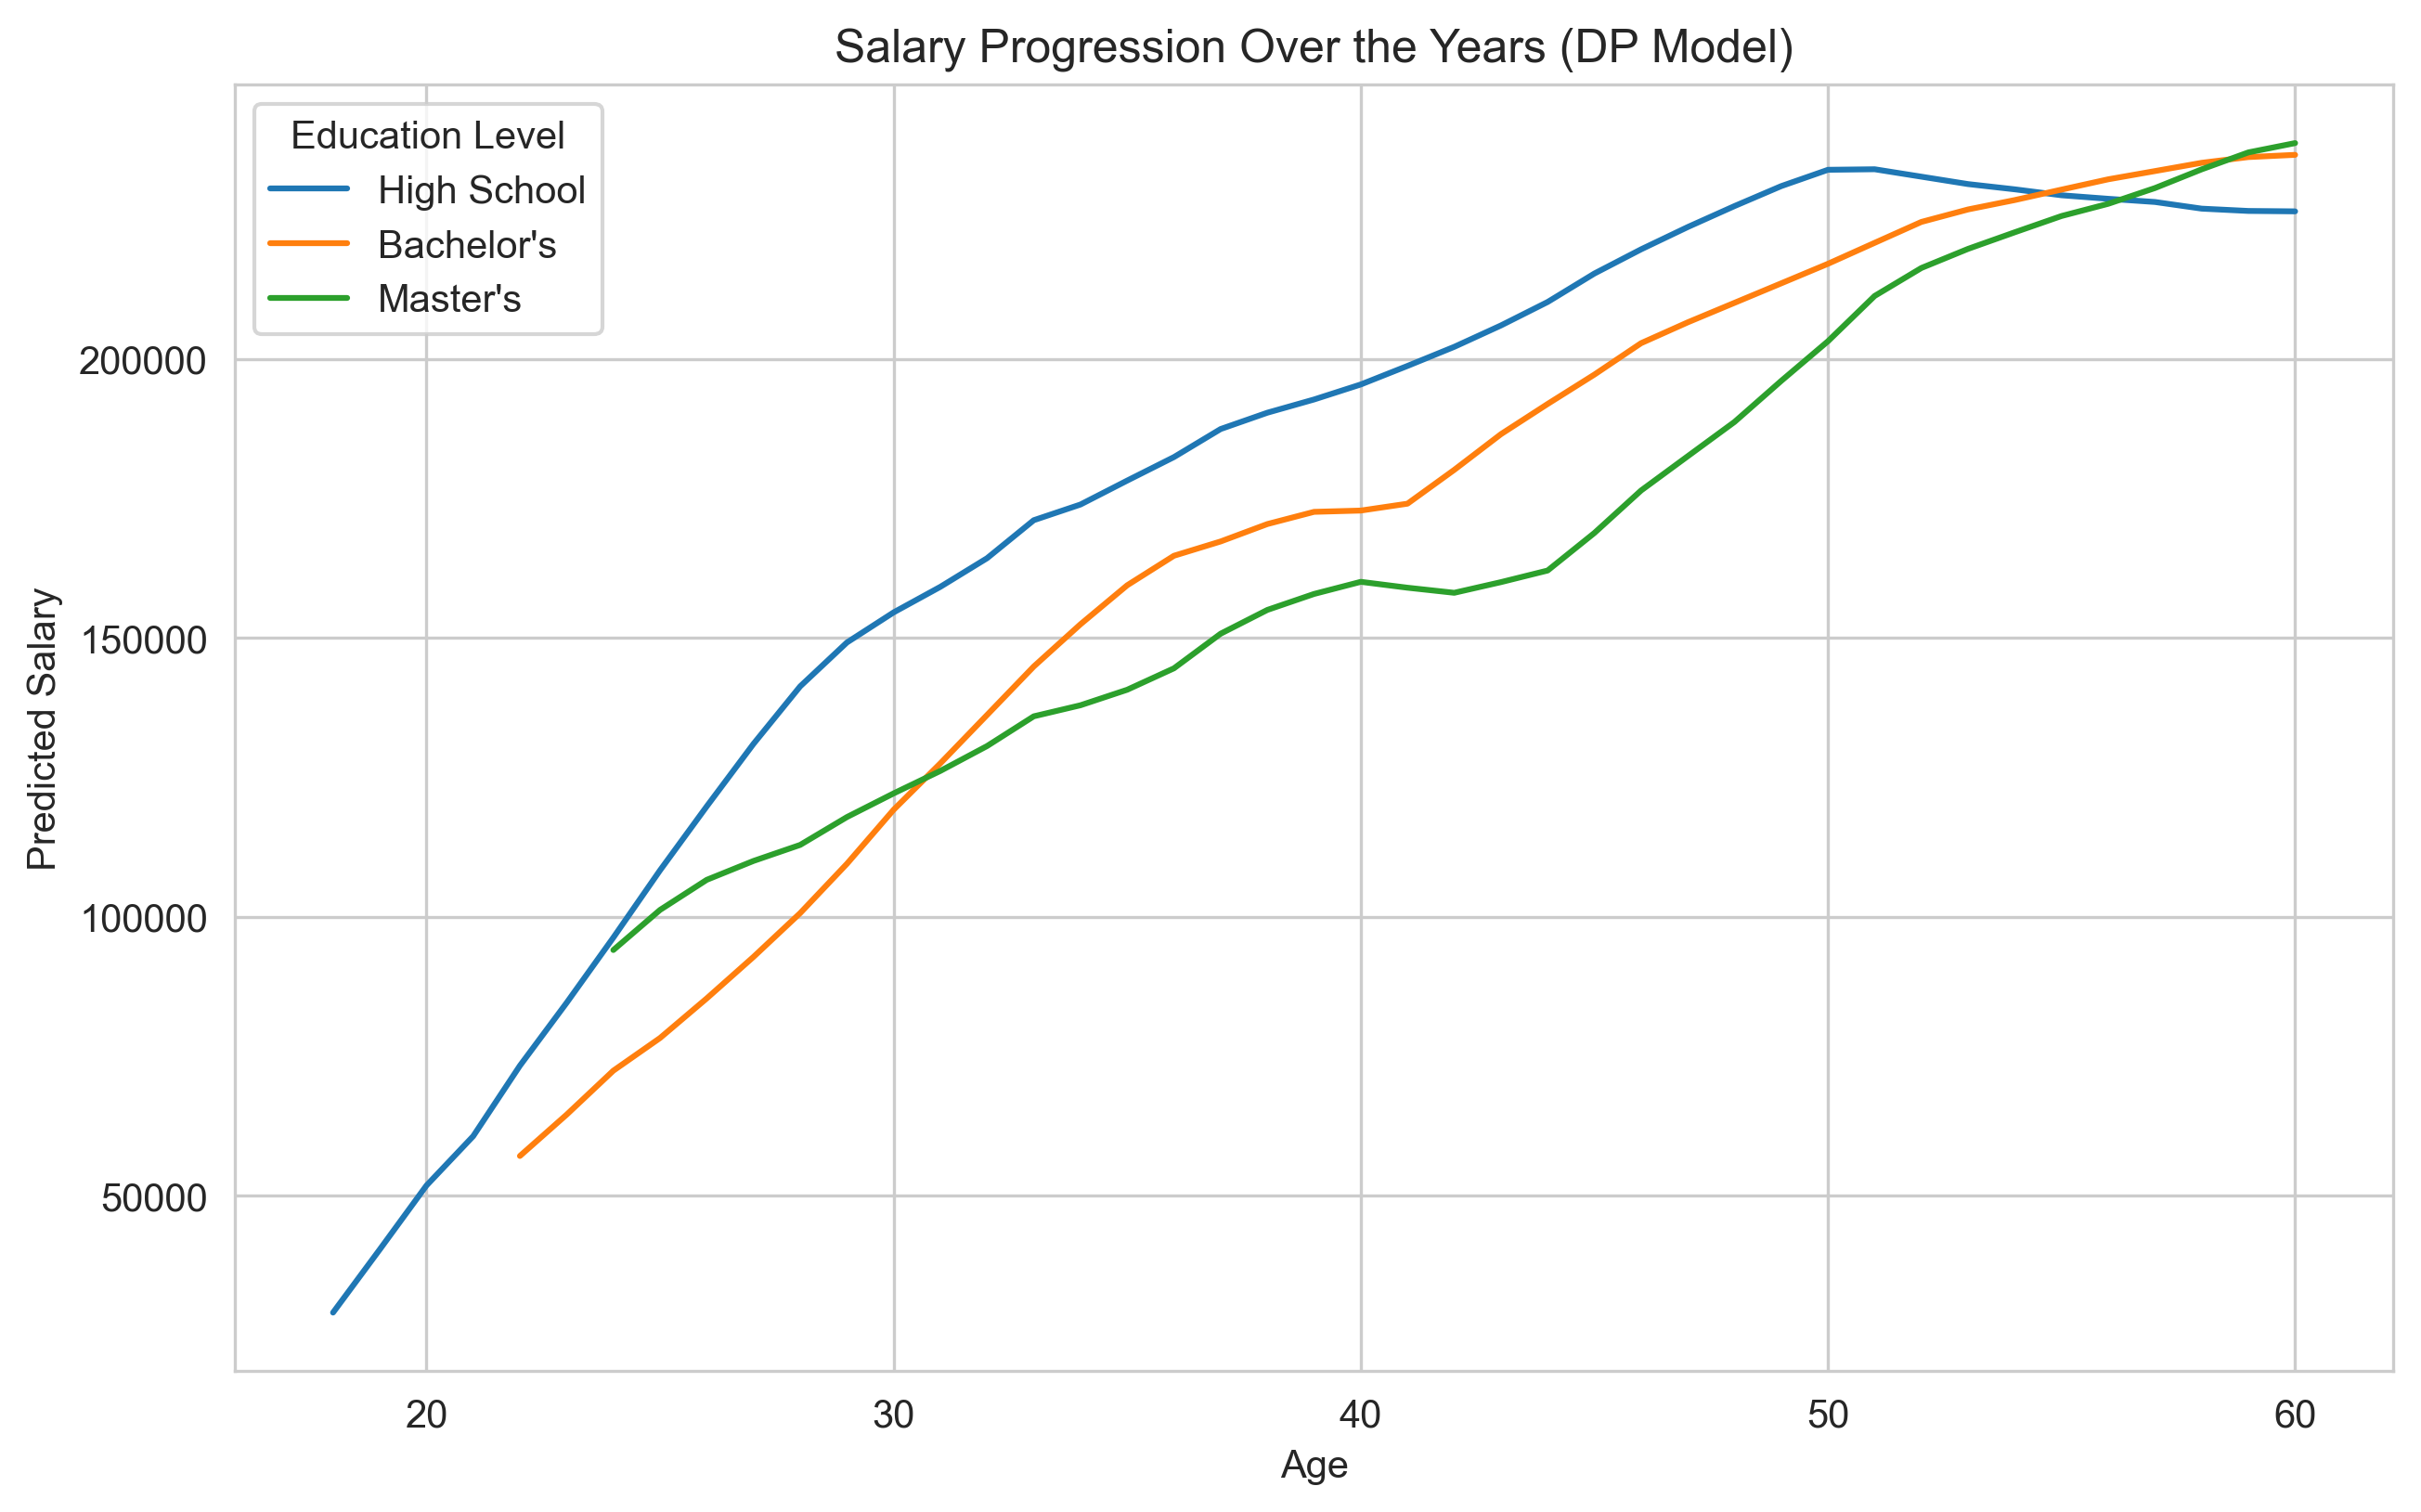

Best education for Job Title: Product Manager is High School


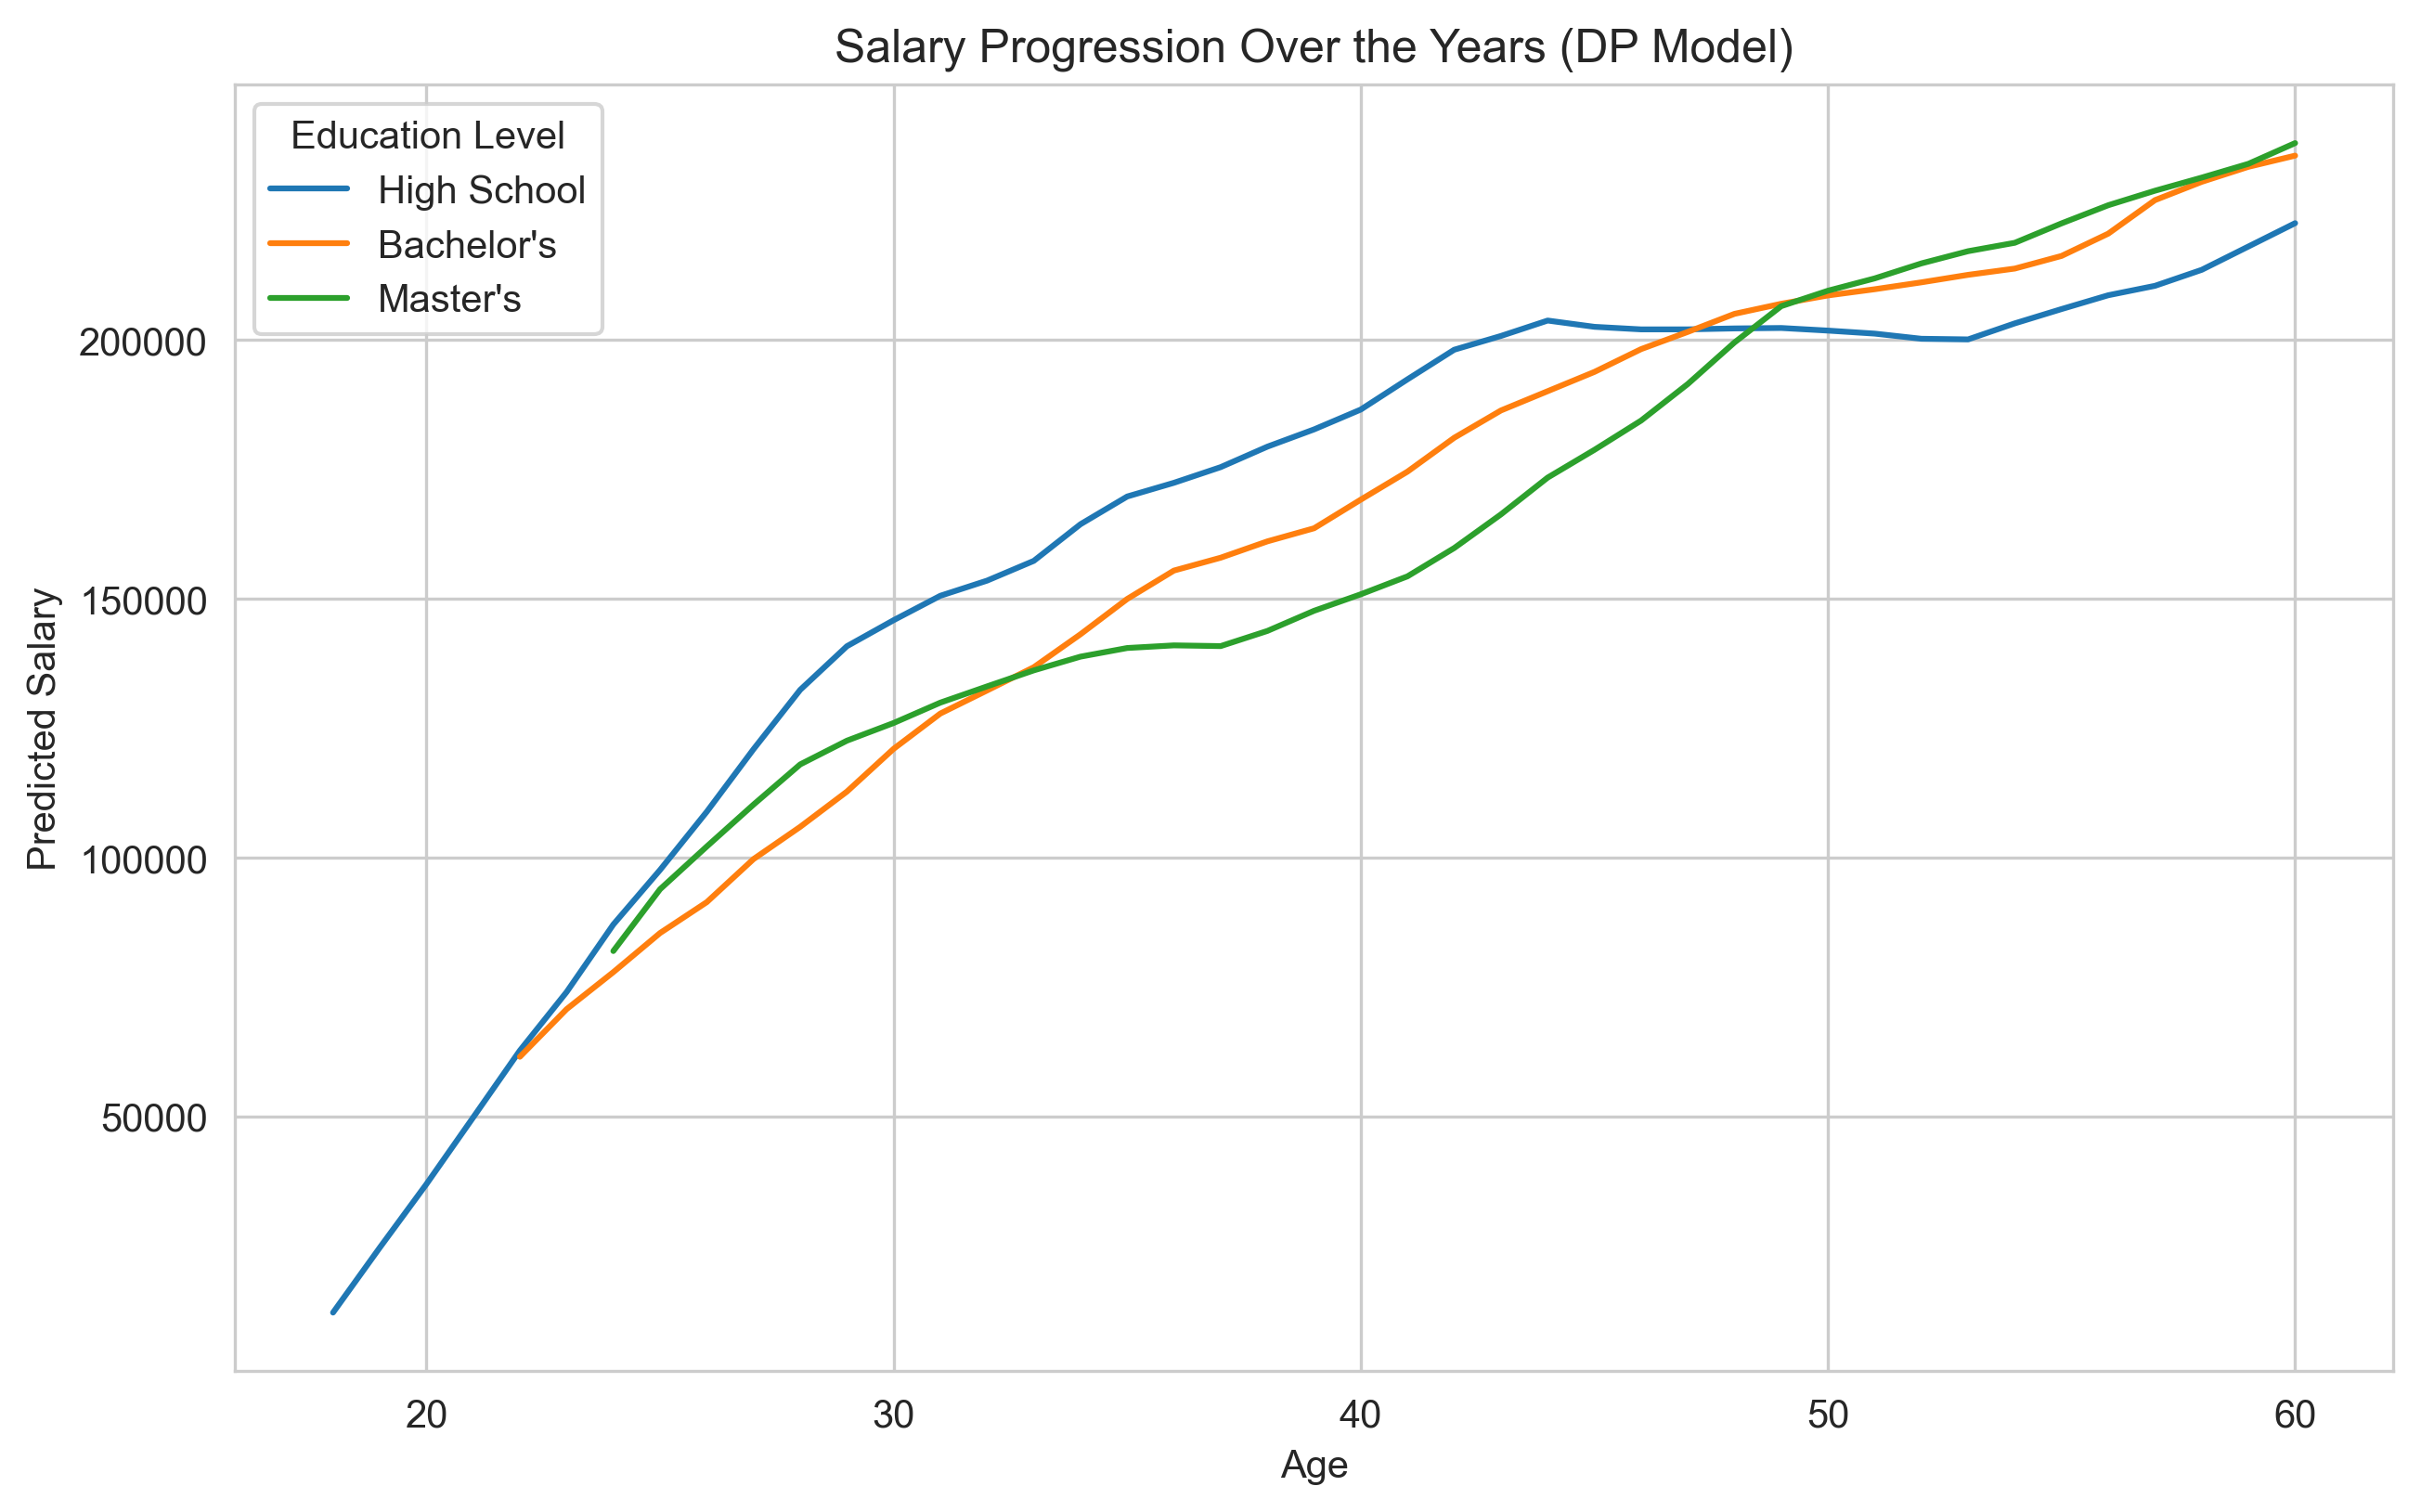

Best education for Job Title: Marketing Coordinator is High School


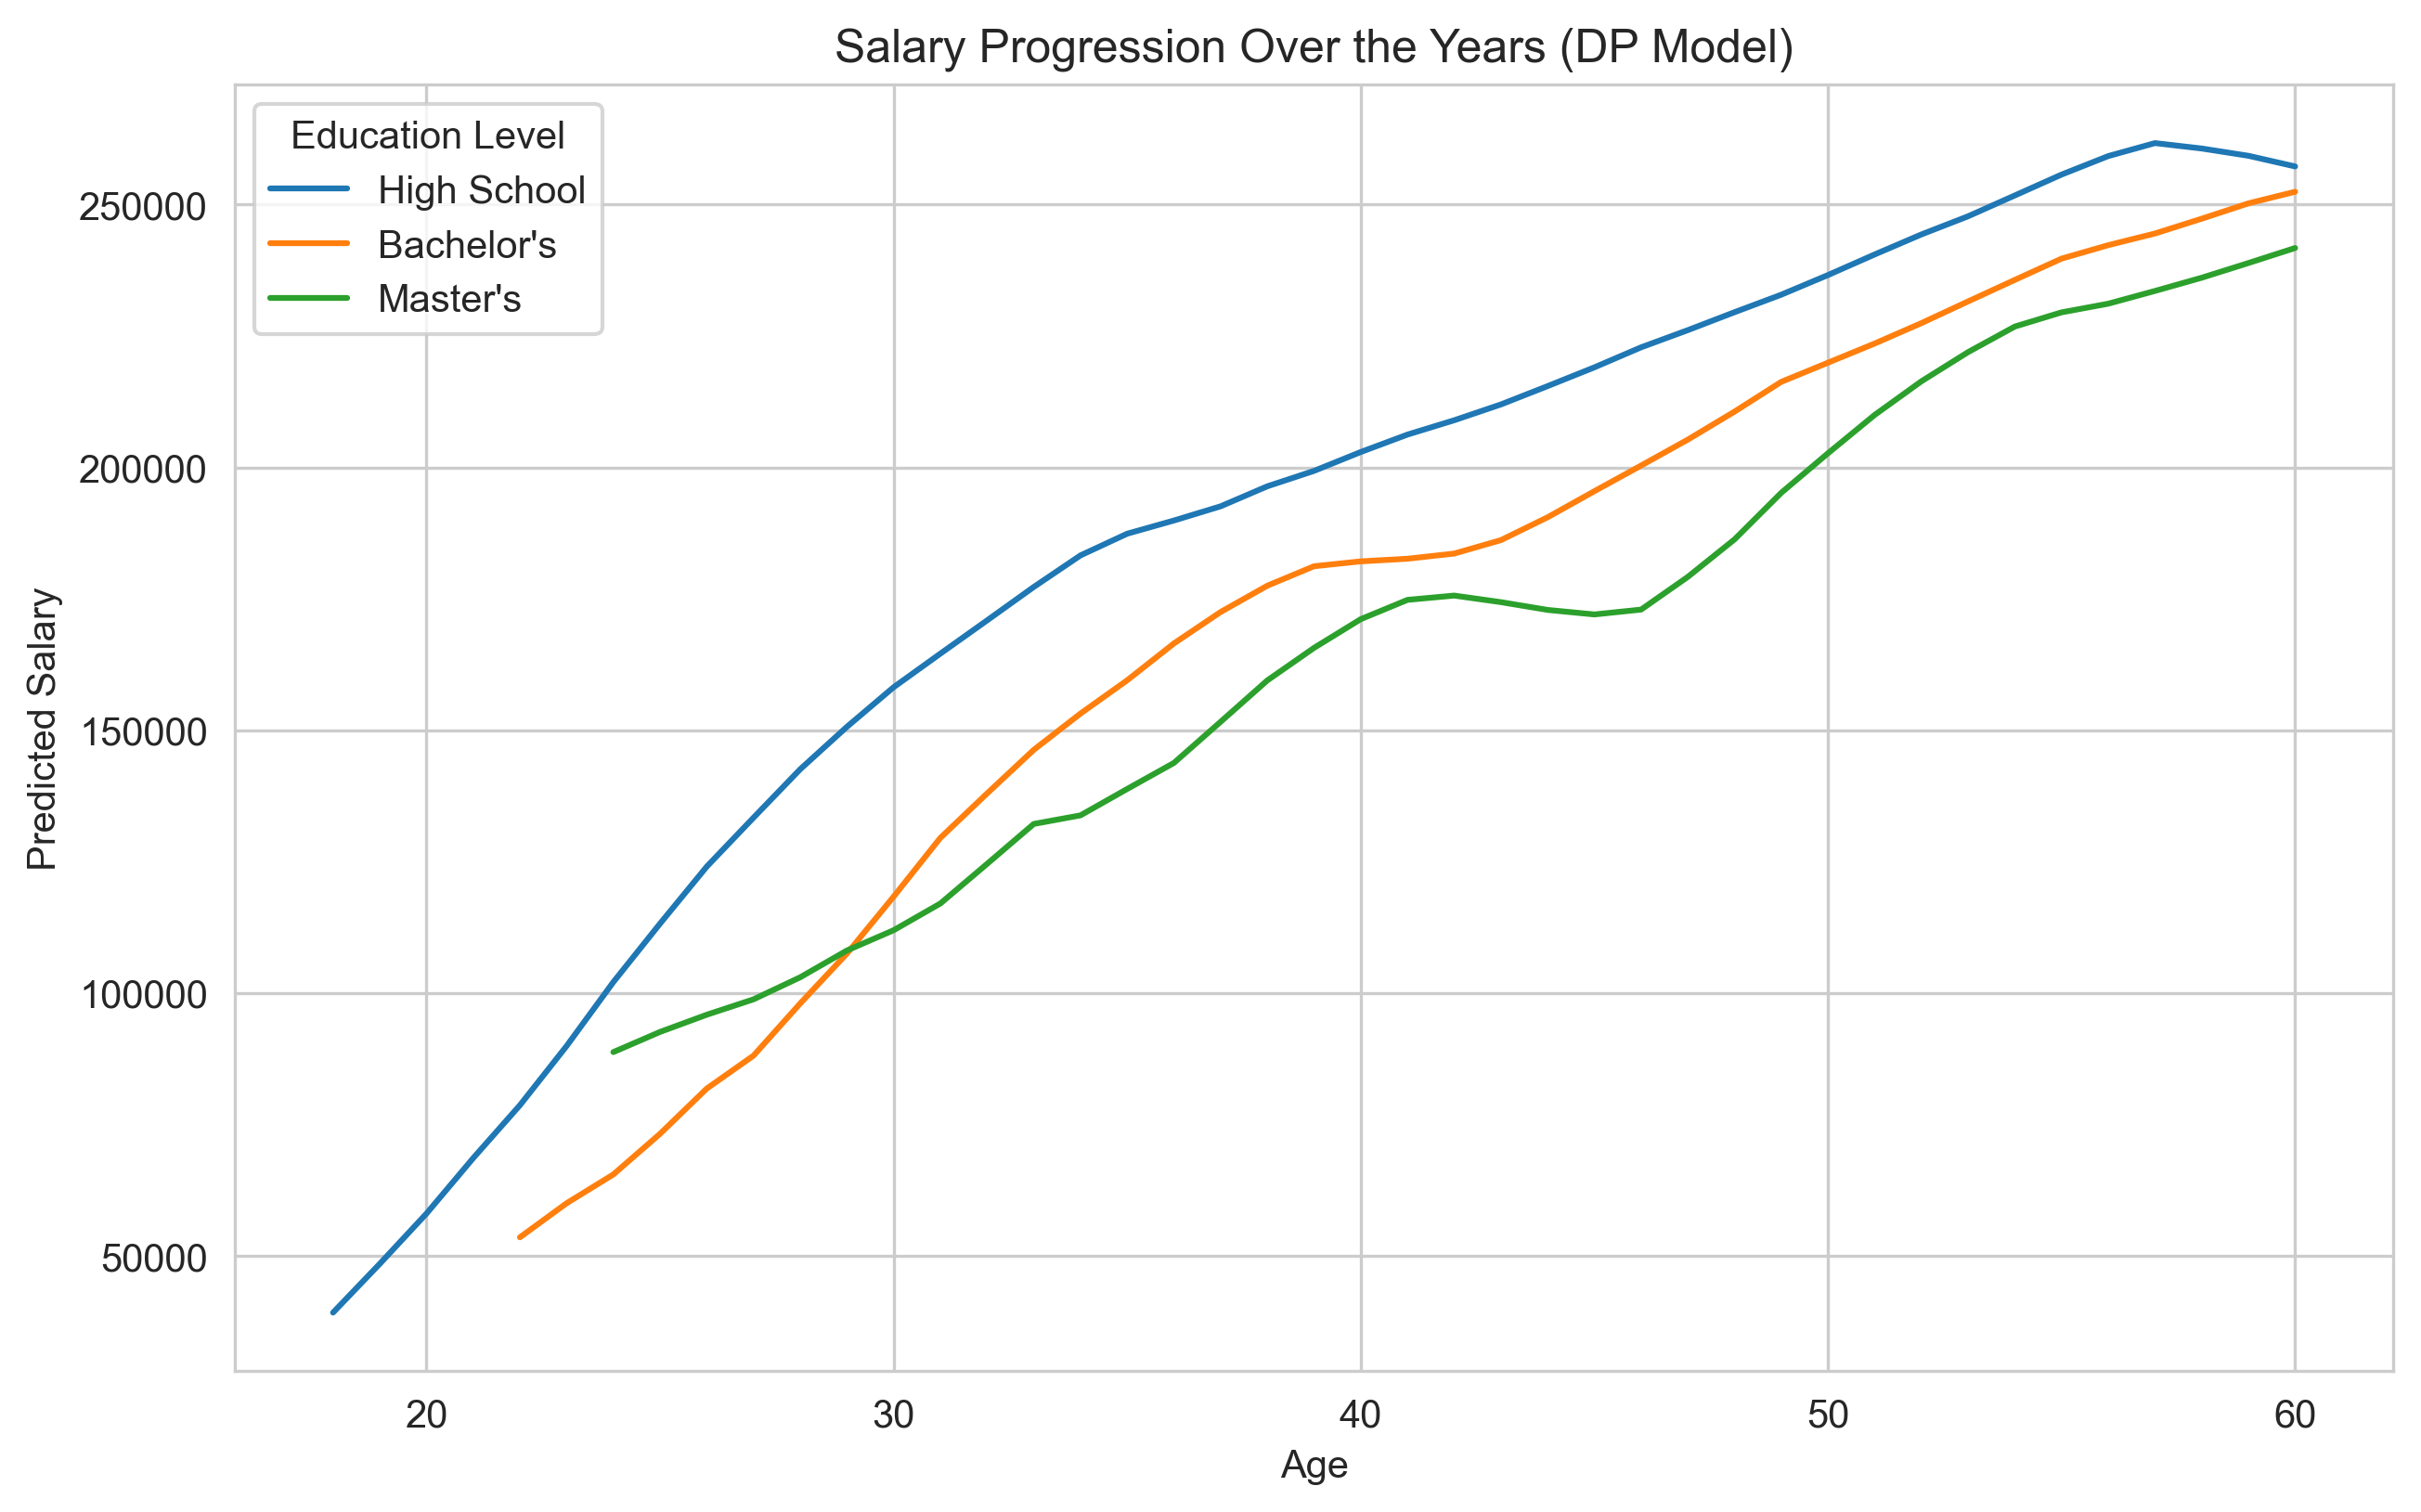

Best education for Job Title: Software Developer is High School


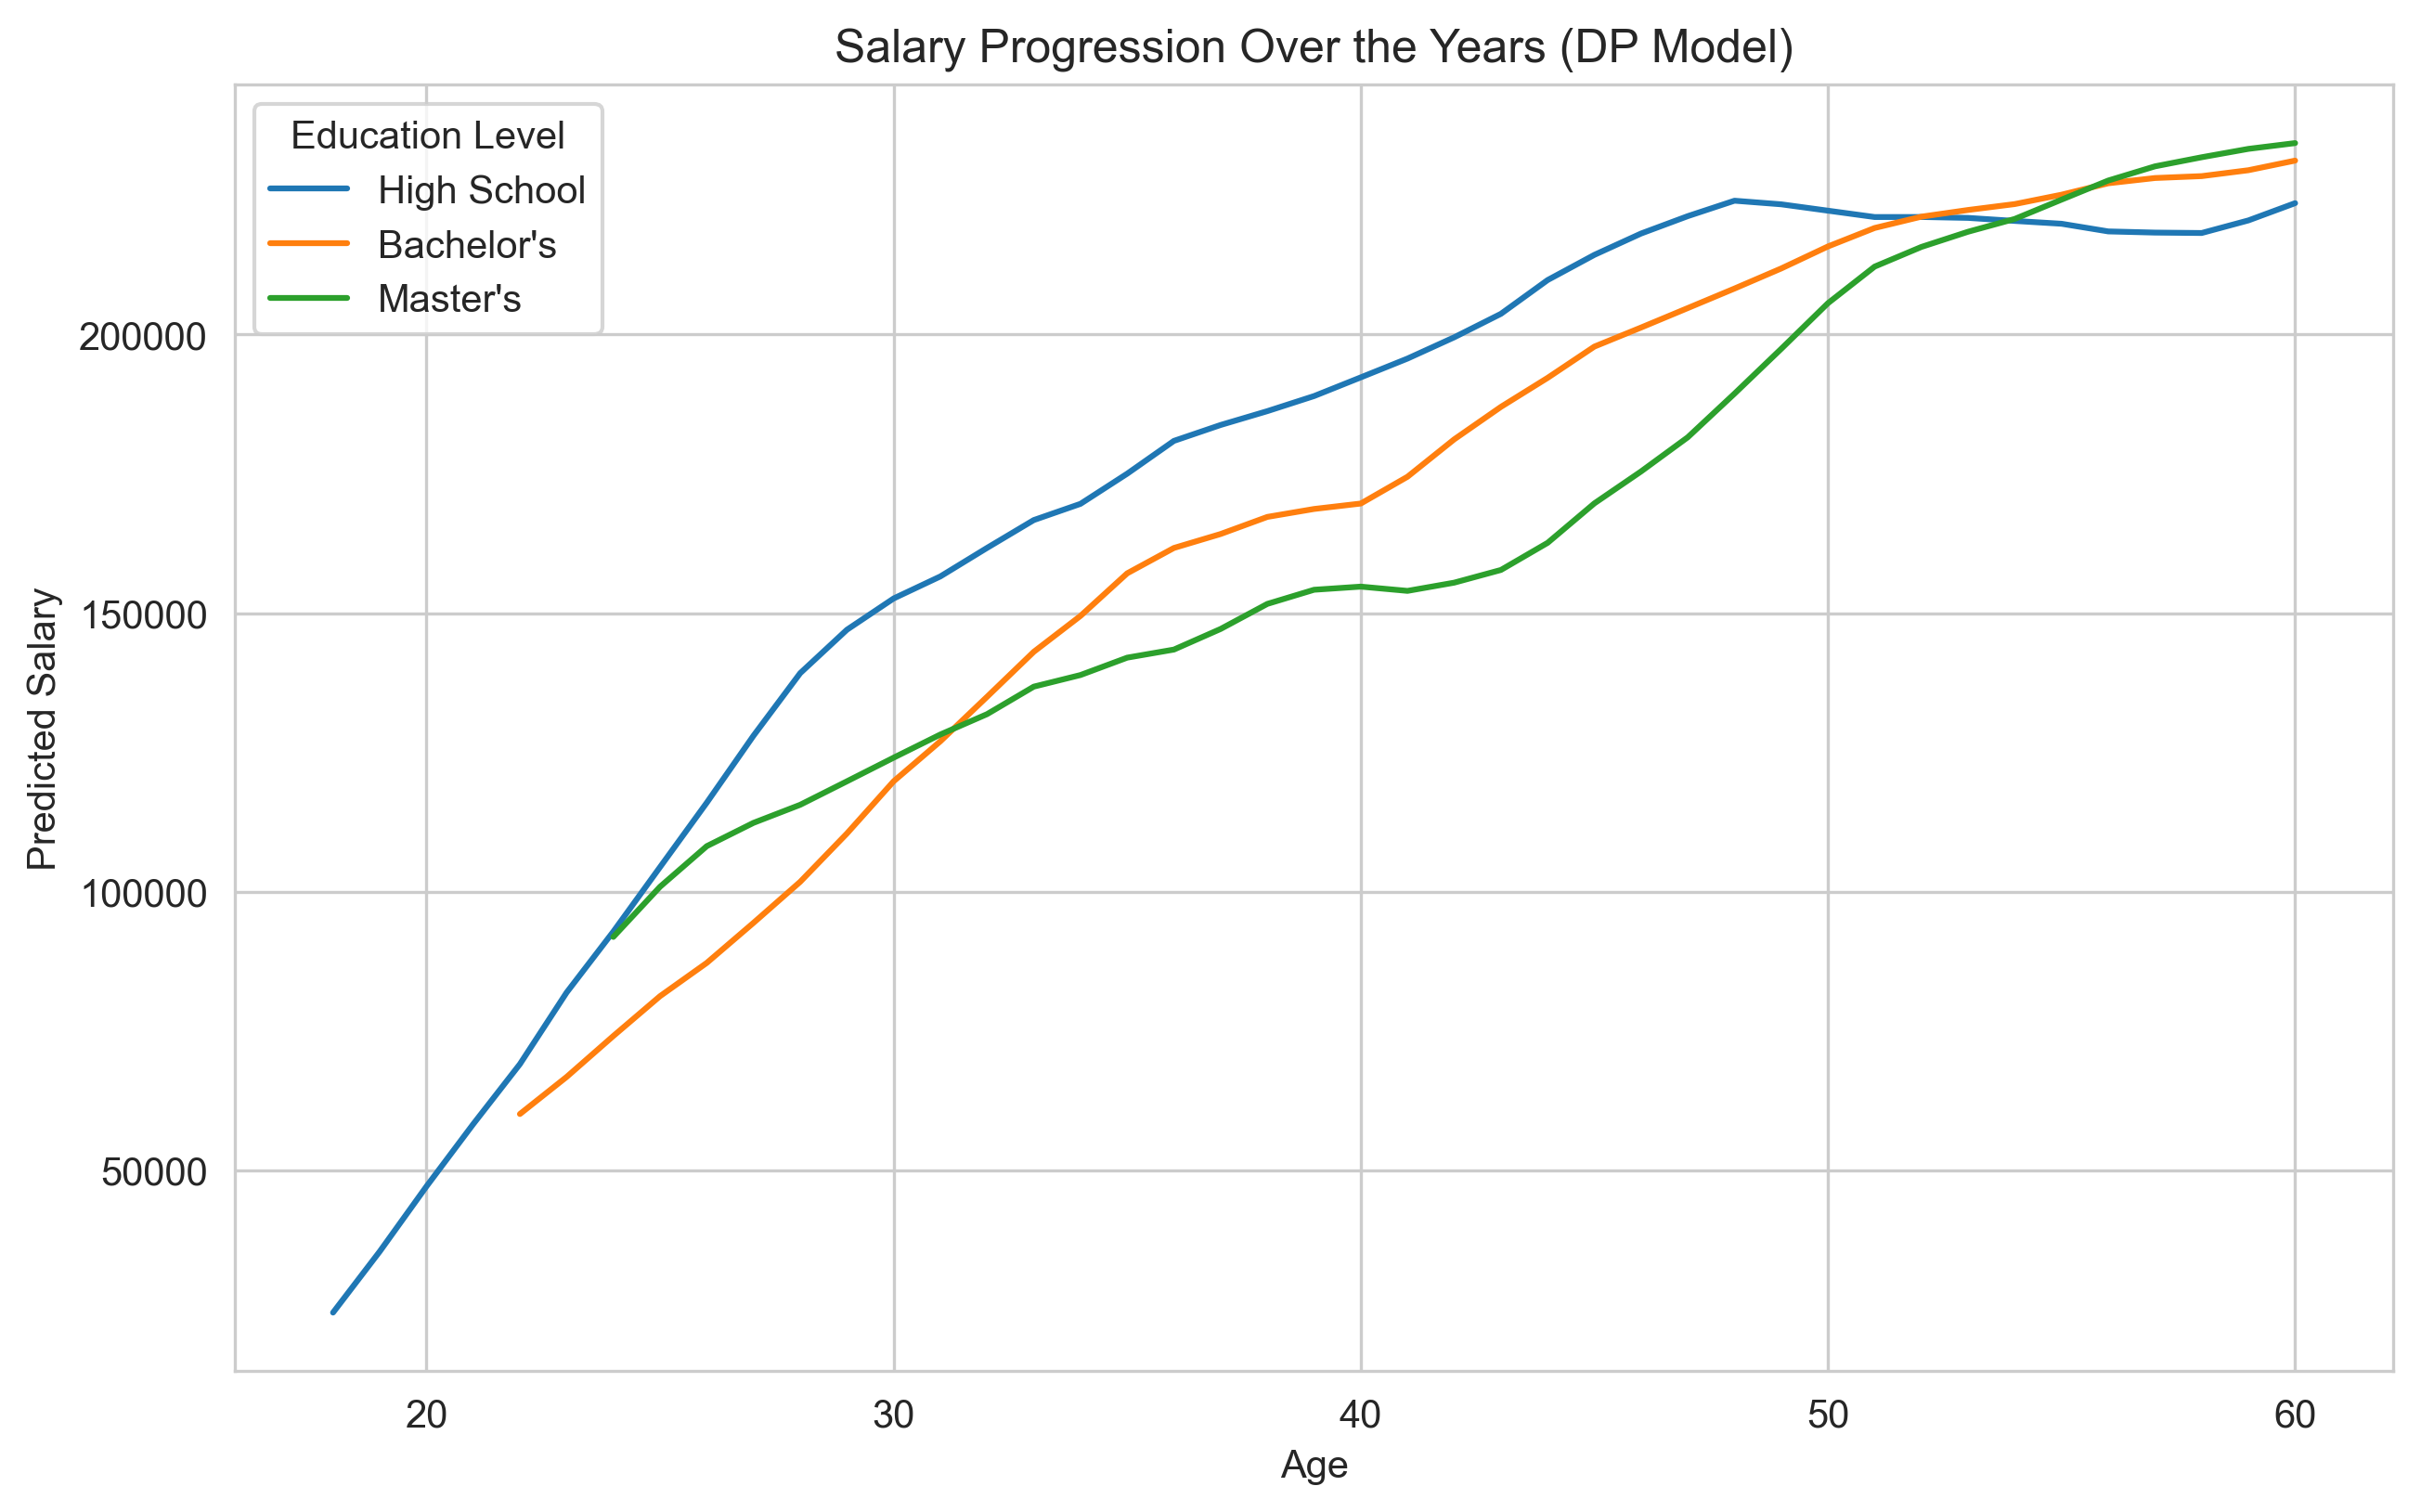

Best education for Job Title: Operations Manager is High School


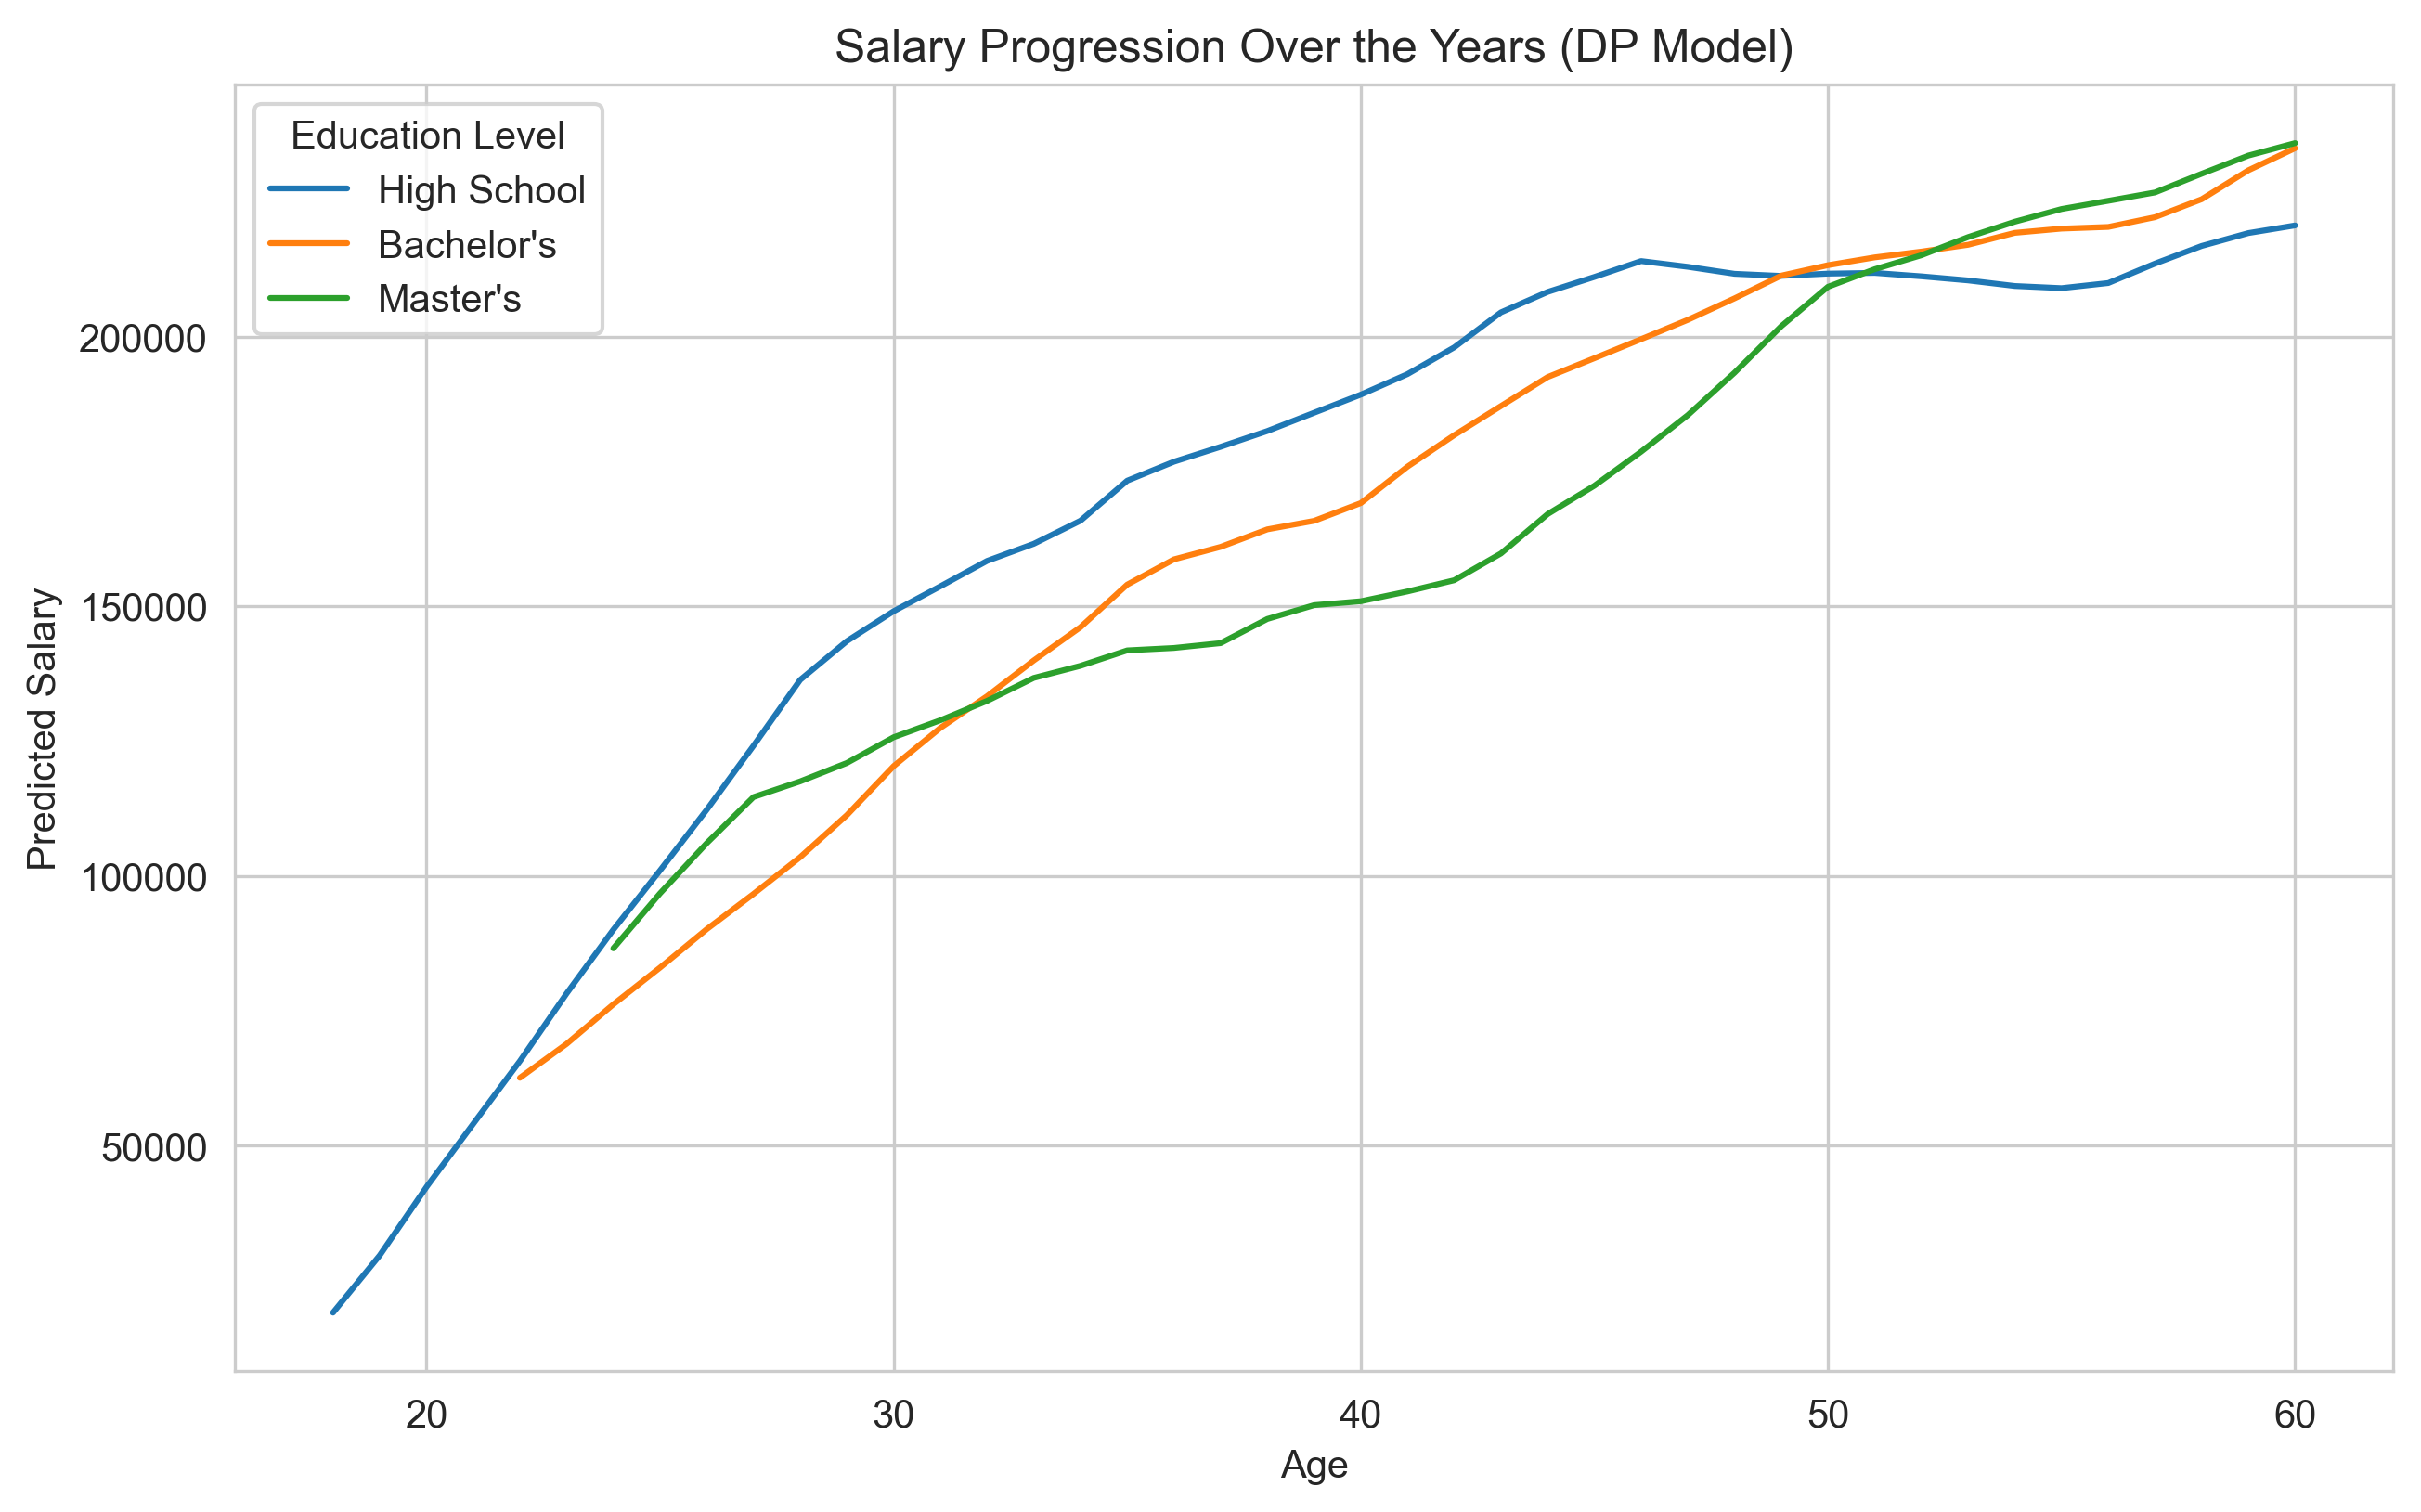

Best education for Job Title: Marketing Manager is High School


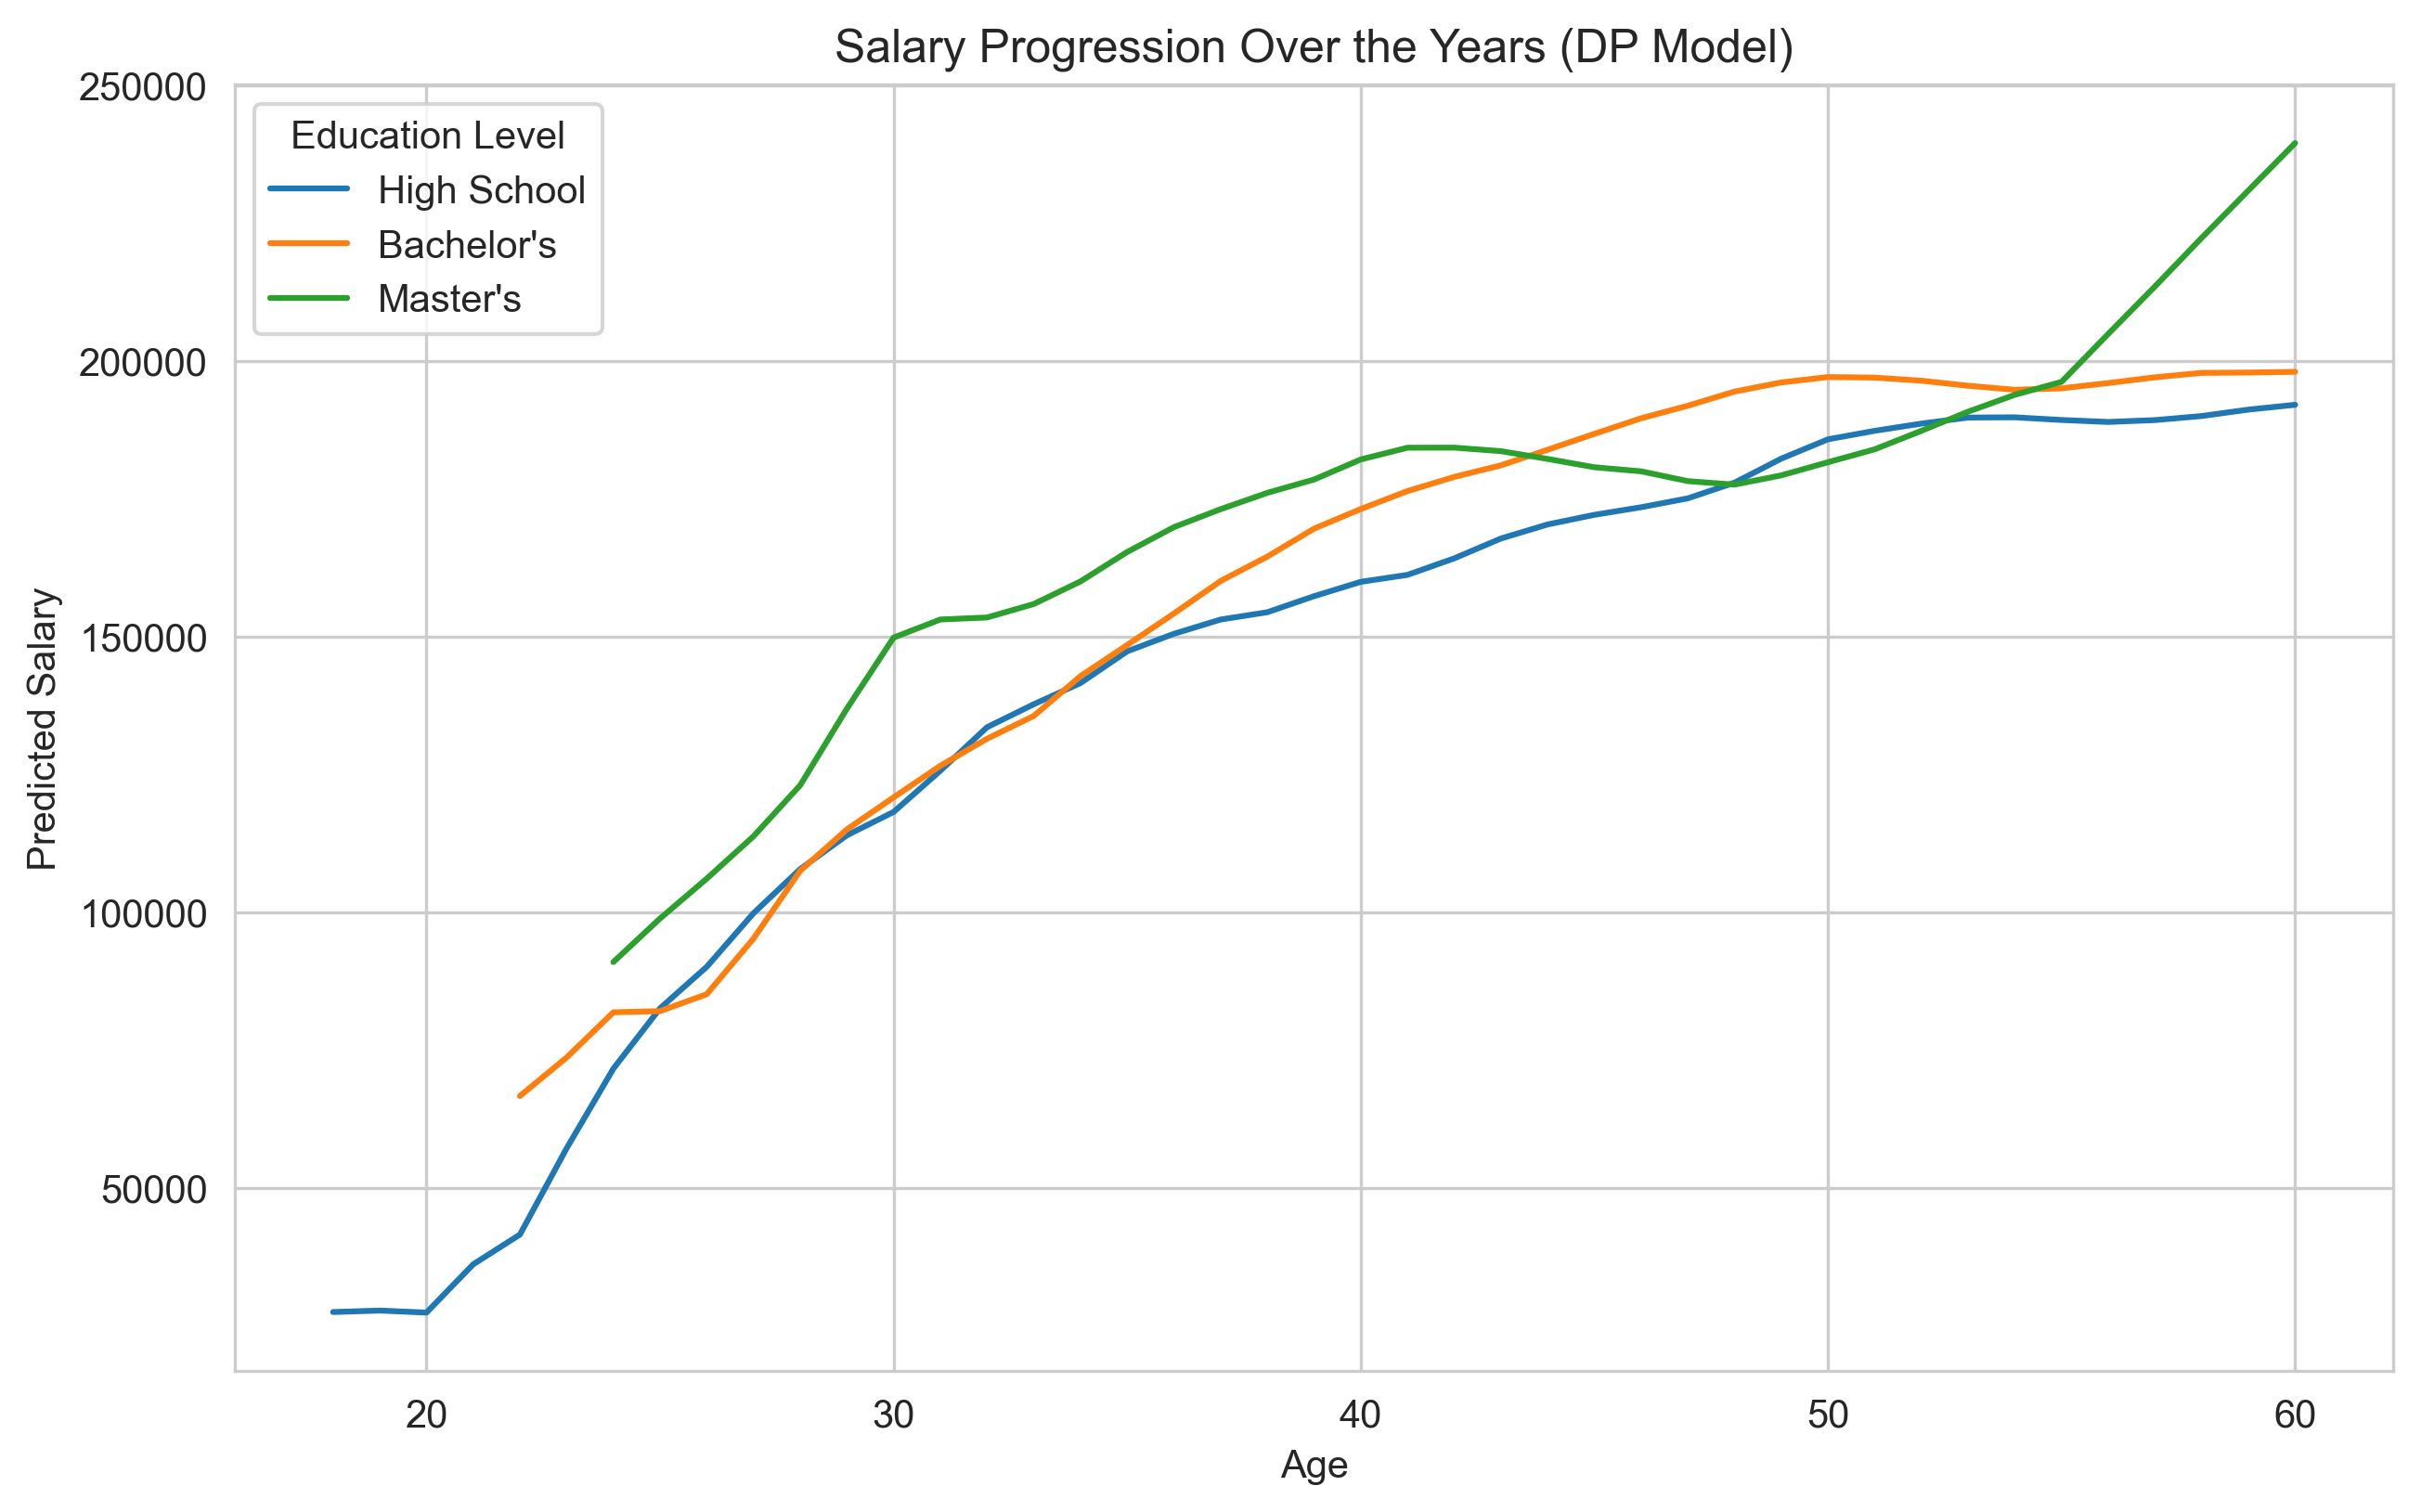

Best education for Job Title: Financial Manager is Master's


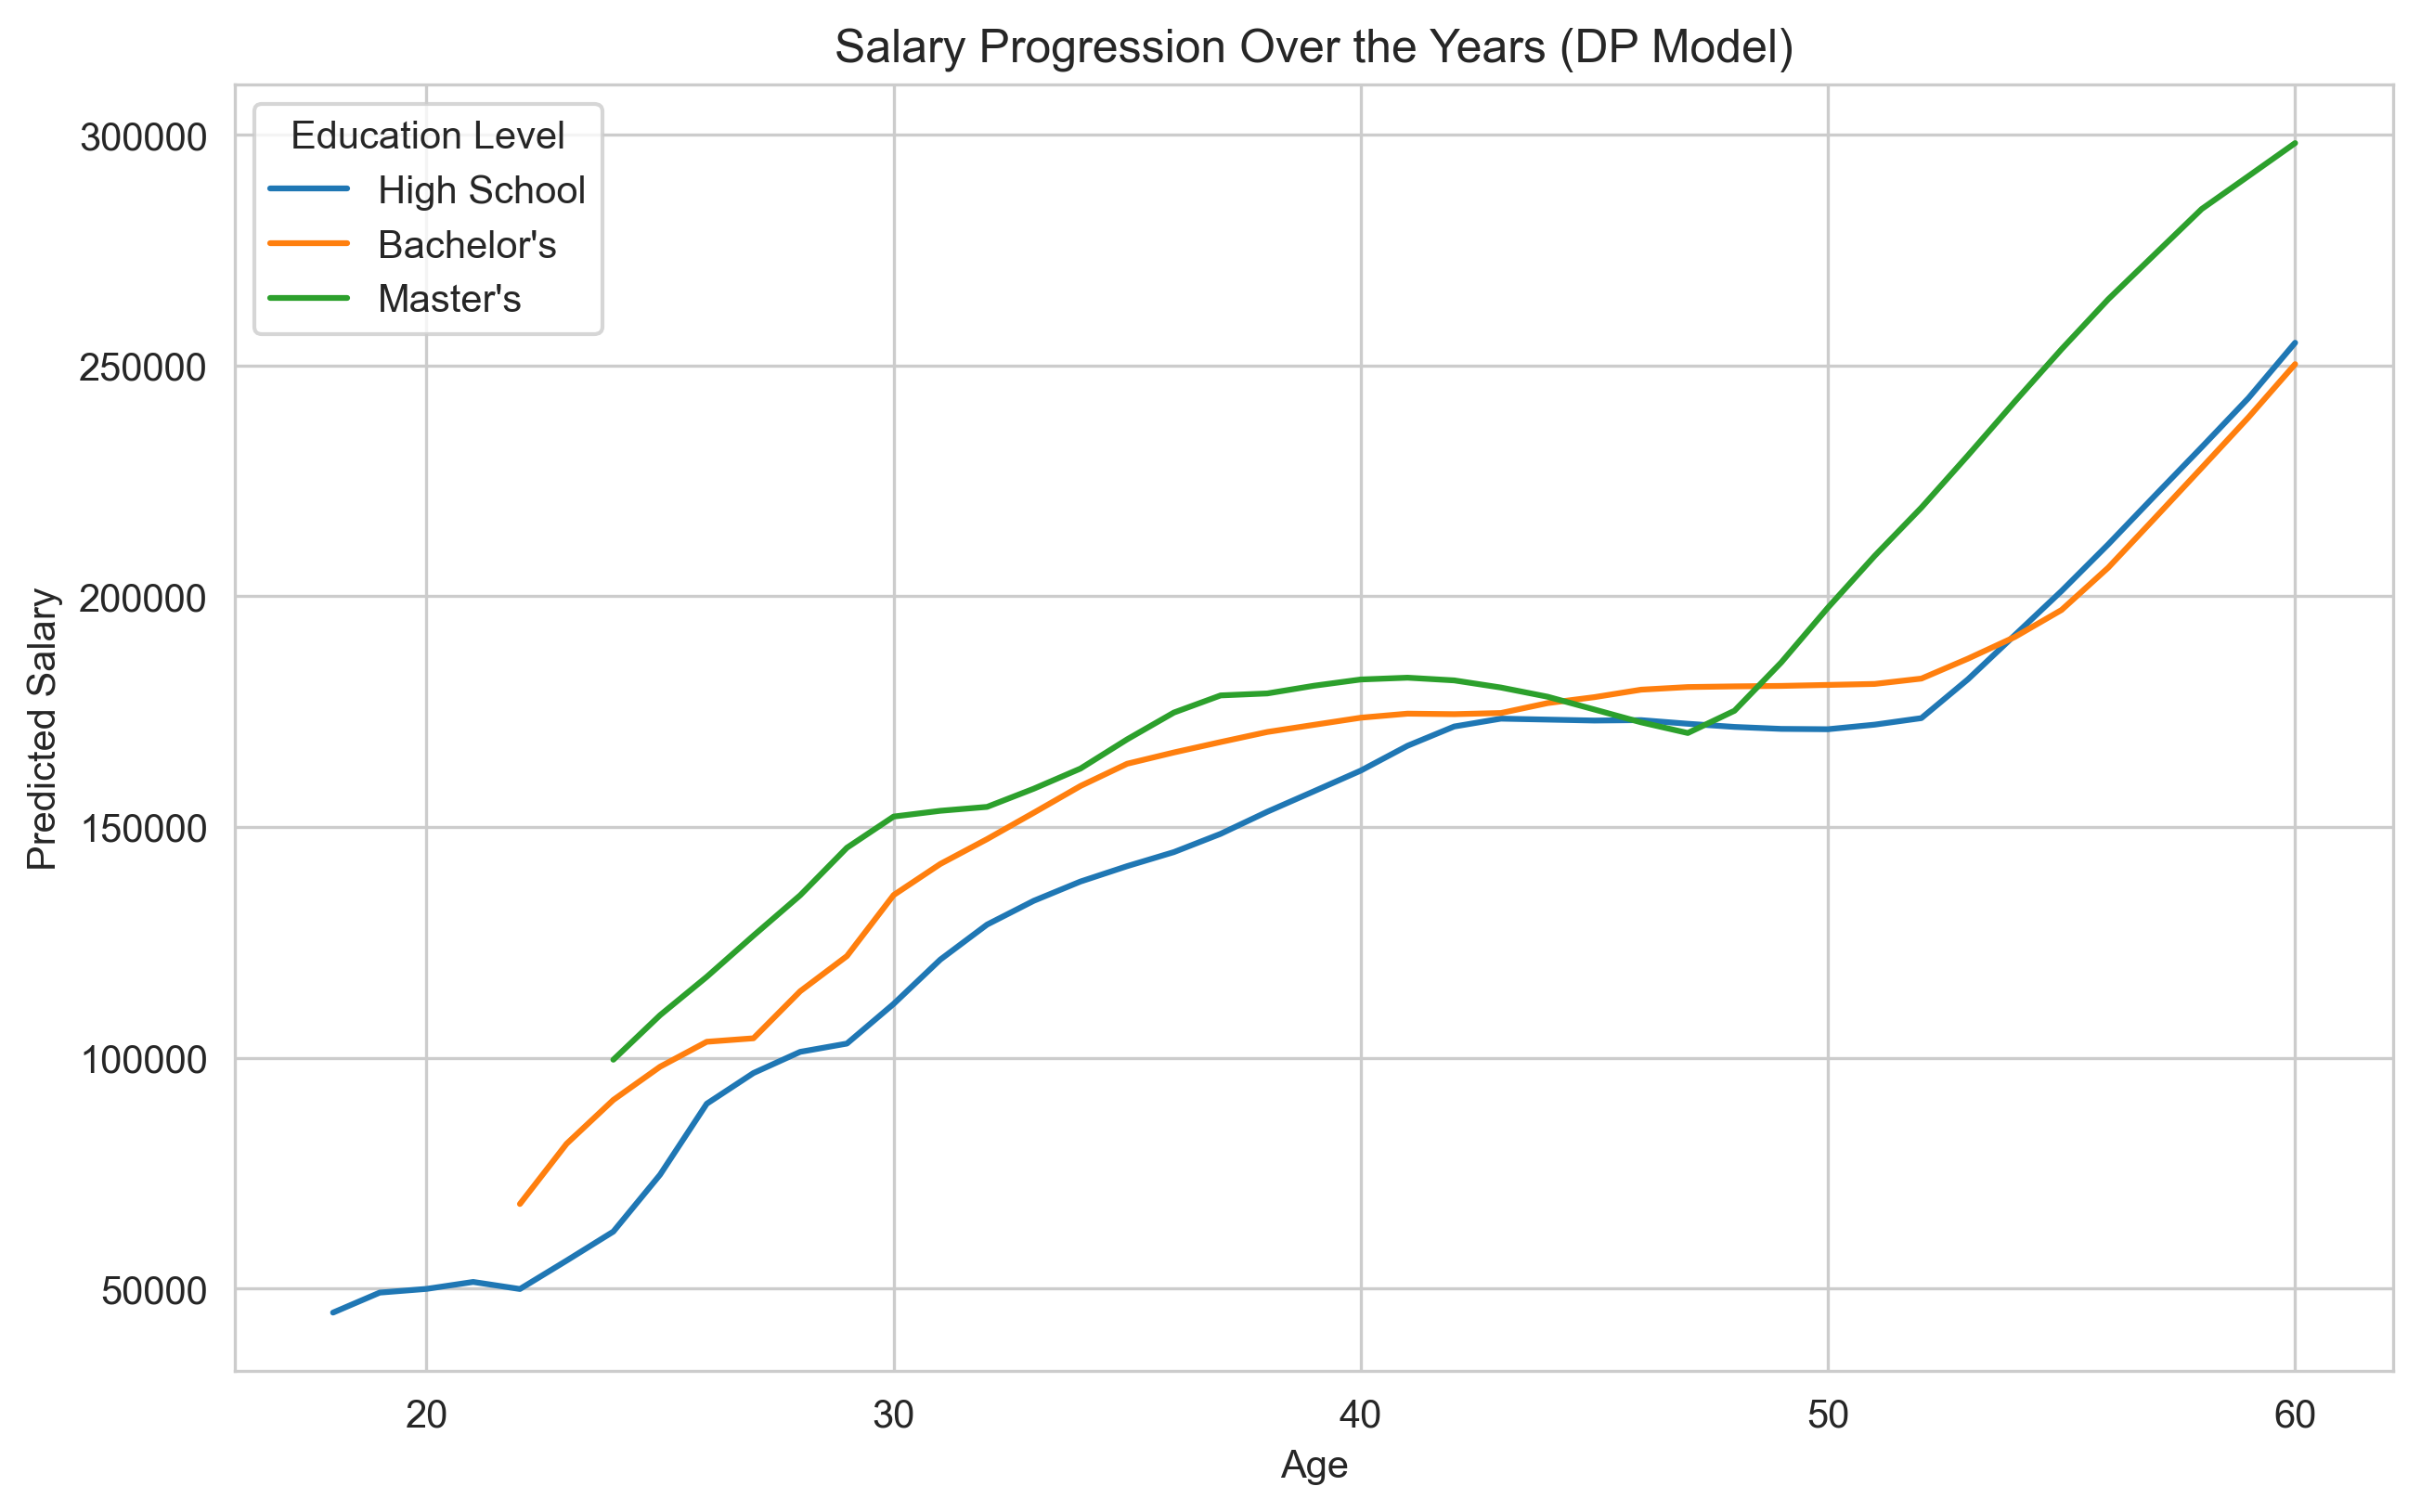

Best education for Job Title: Data Scientist is Master's


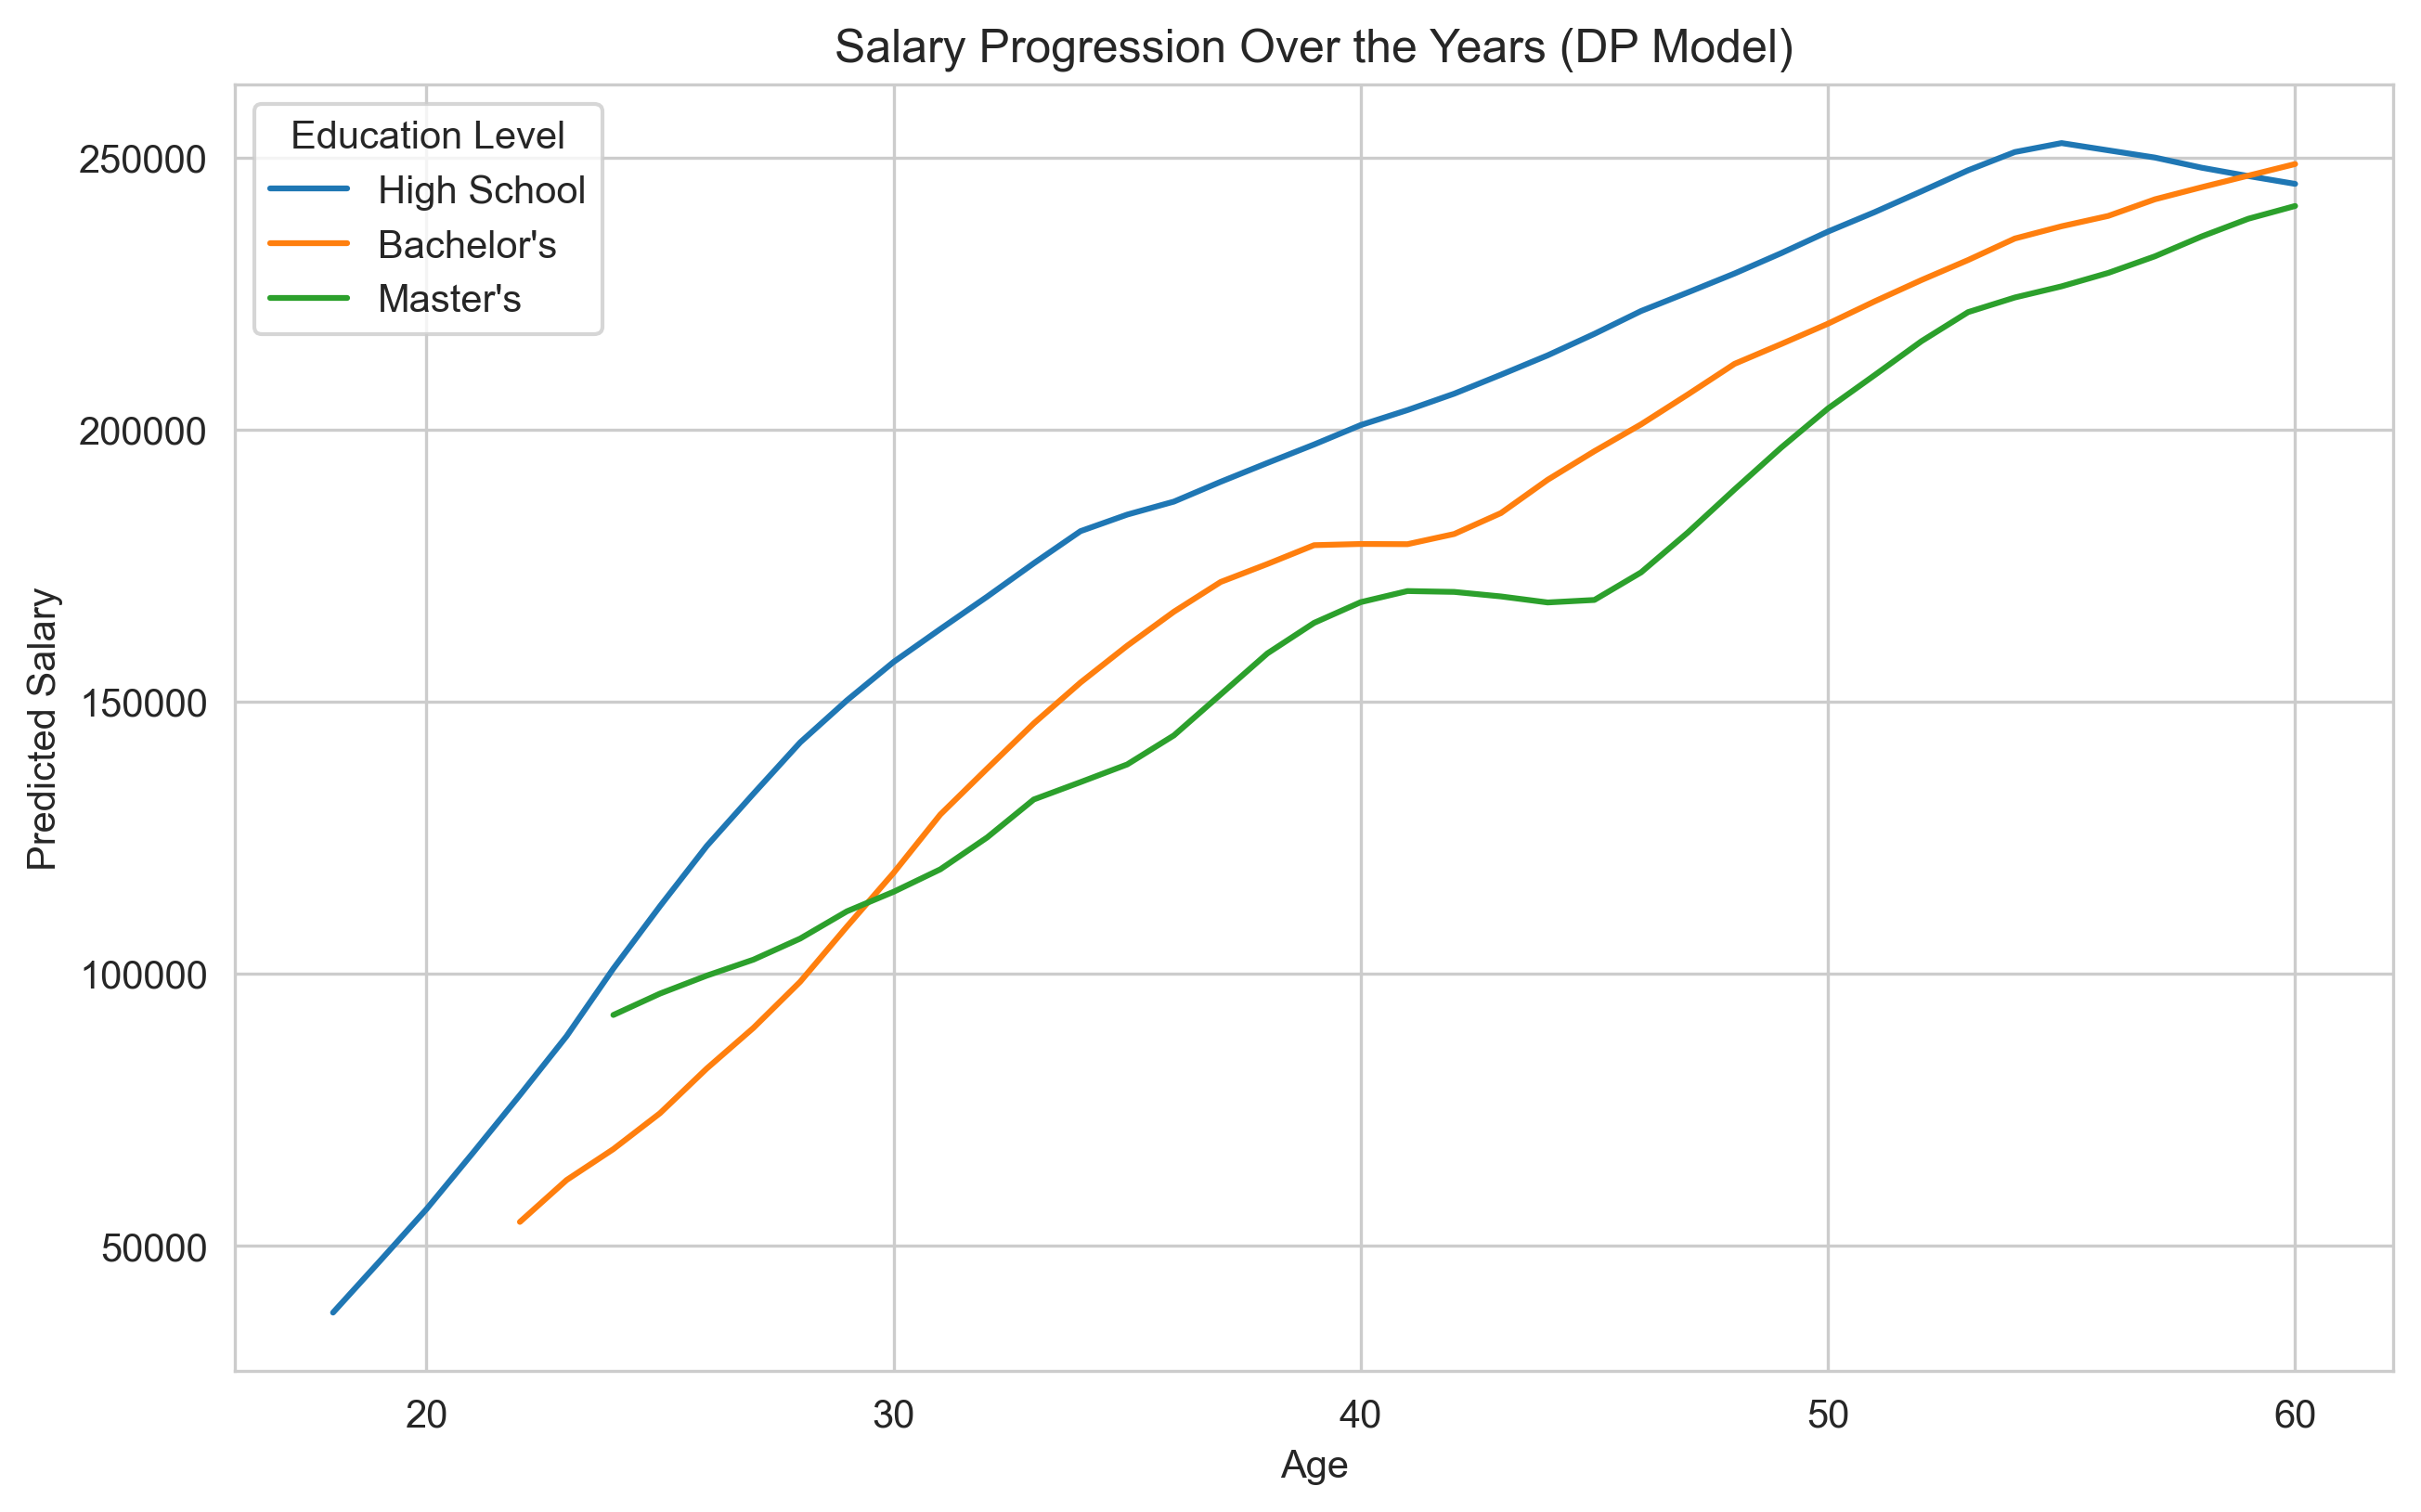

Best education for Job Title: Senior Software Engineer is High School


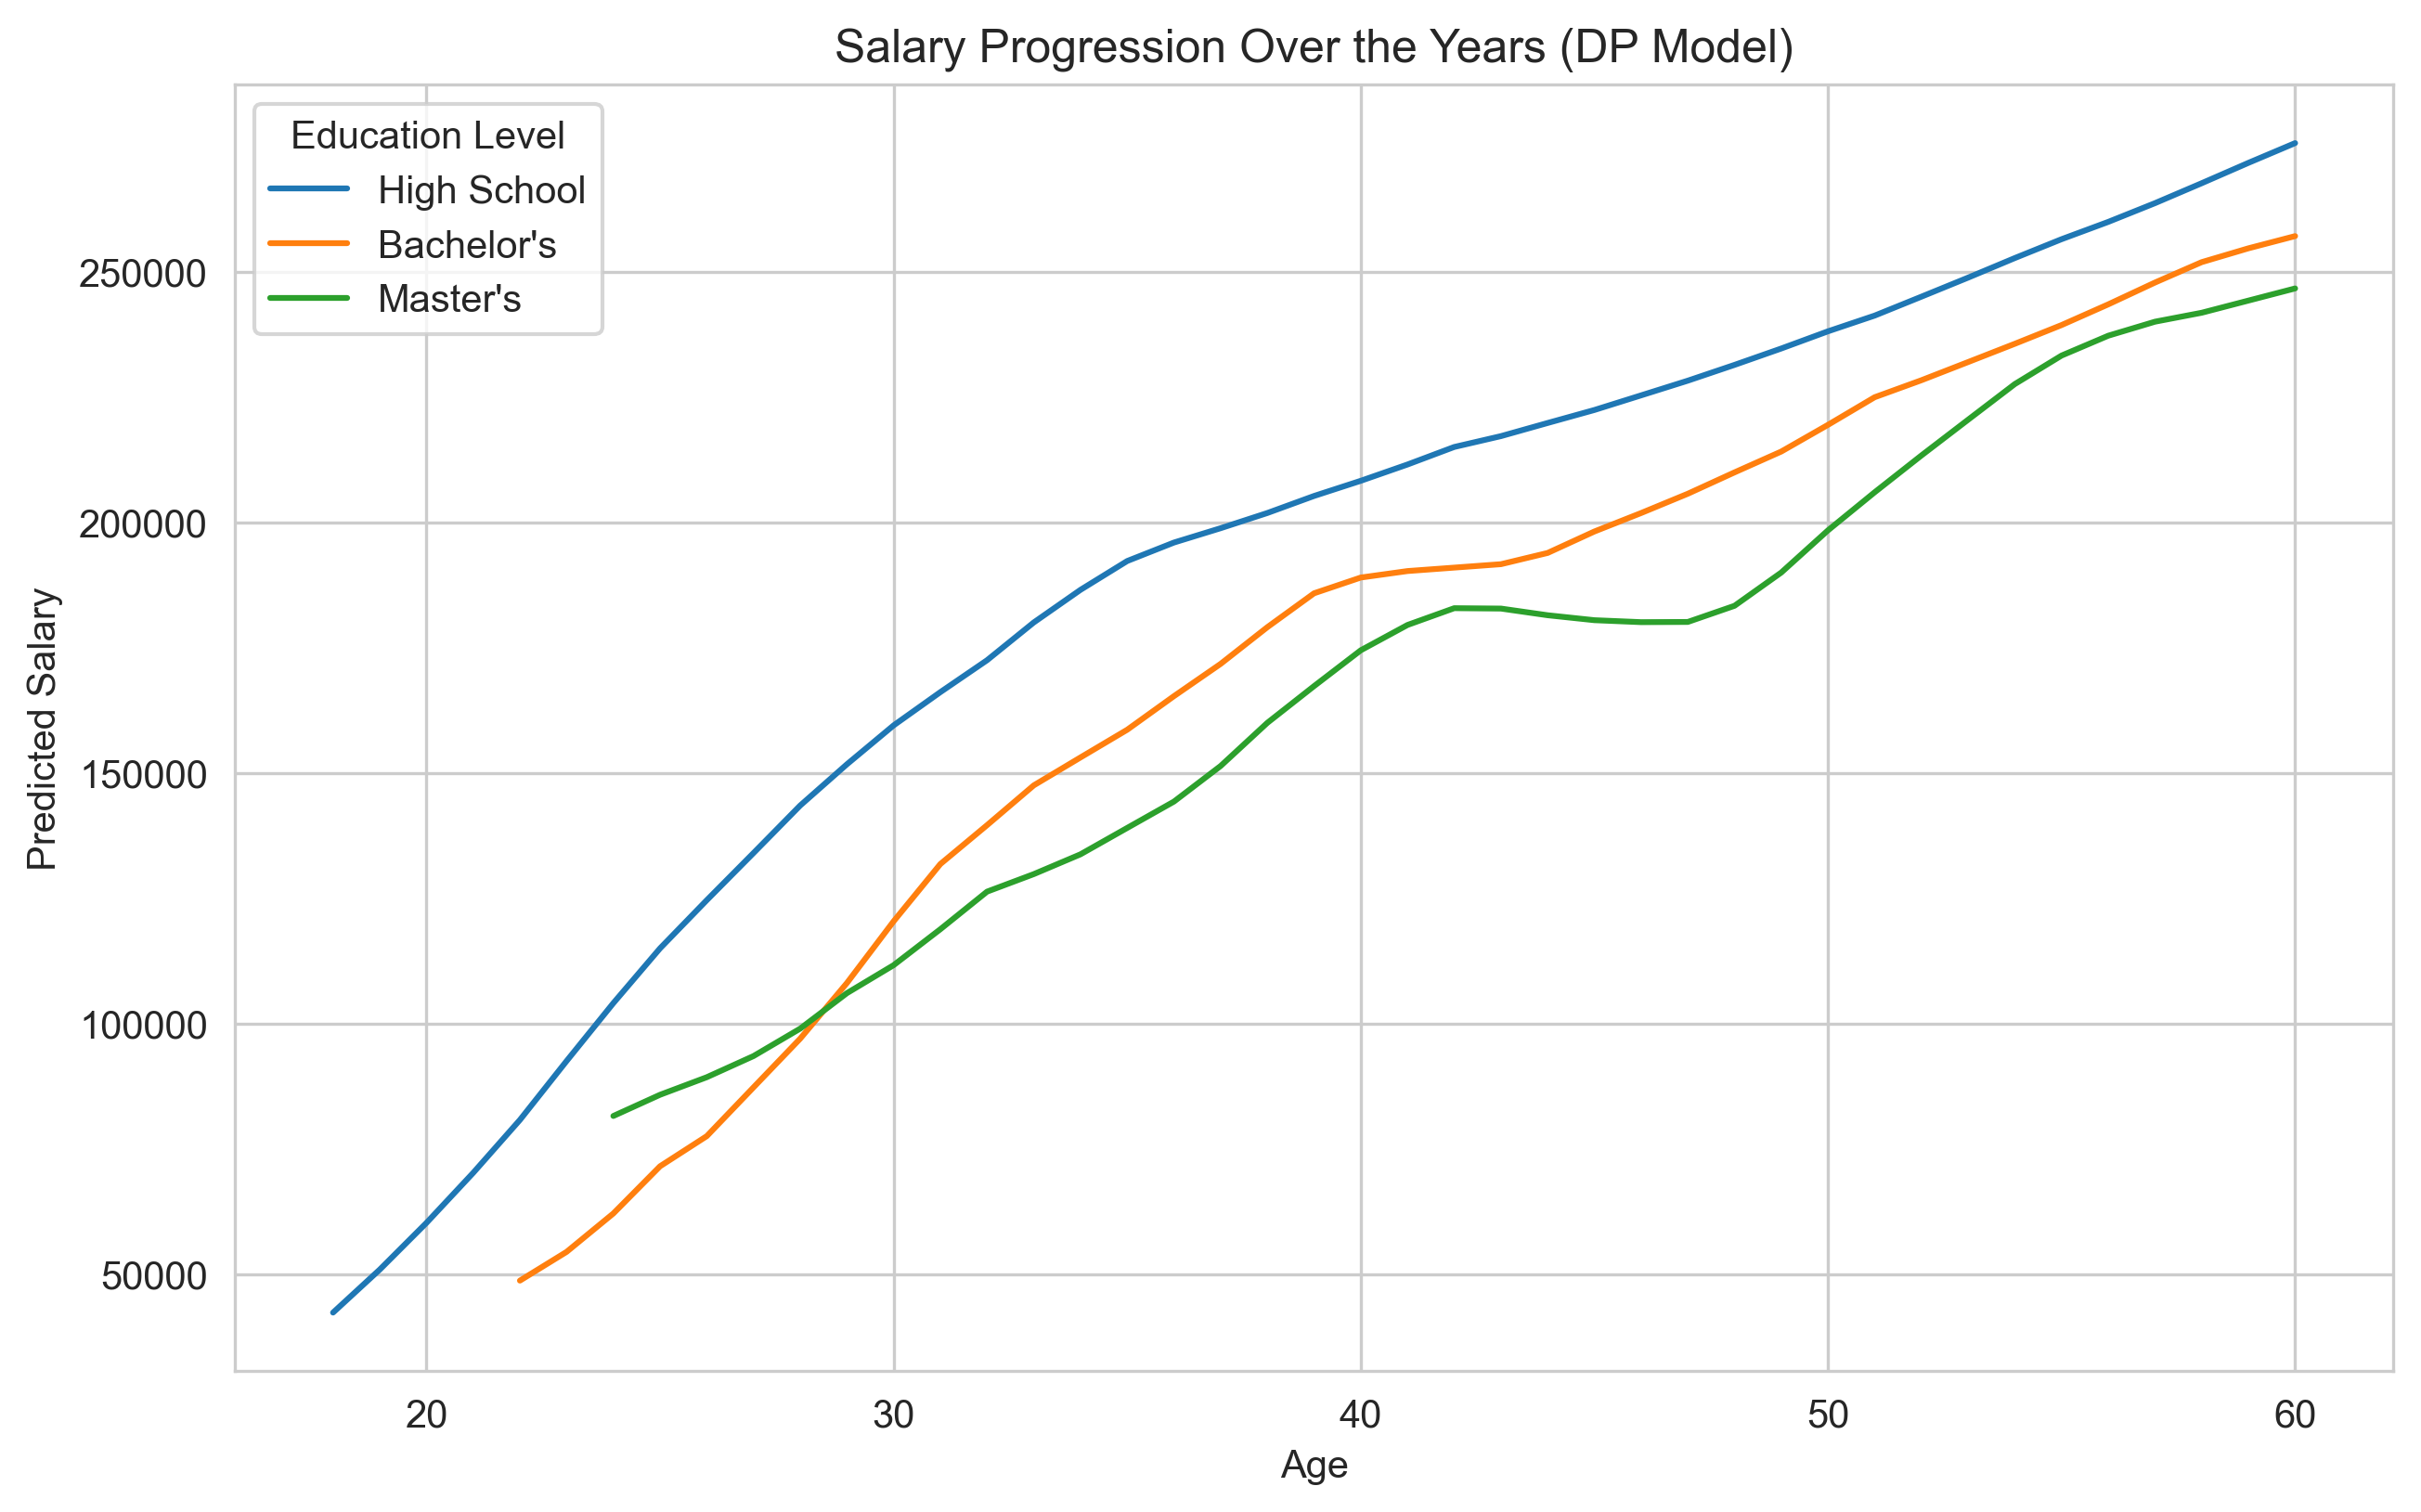

Best education for Job Title: Software Engineer Manager is High School


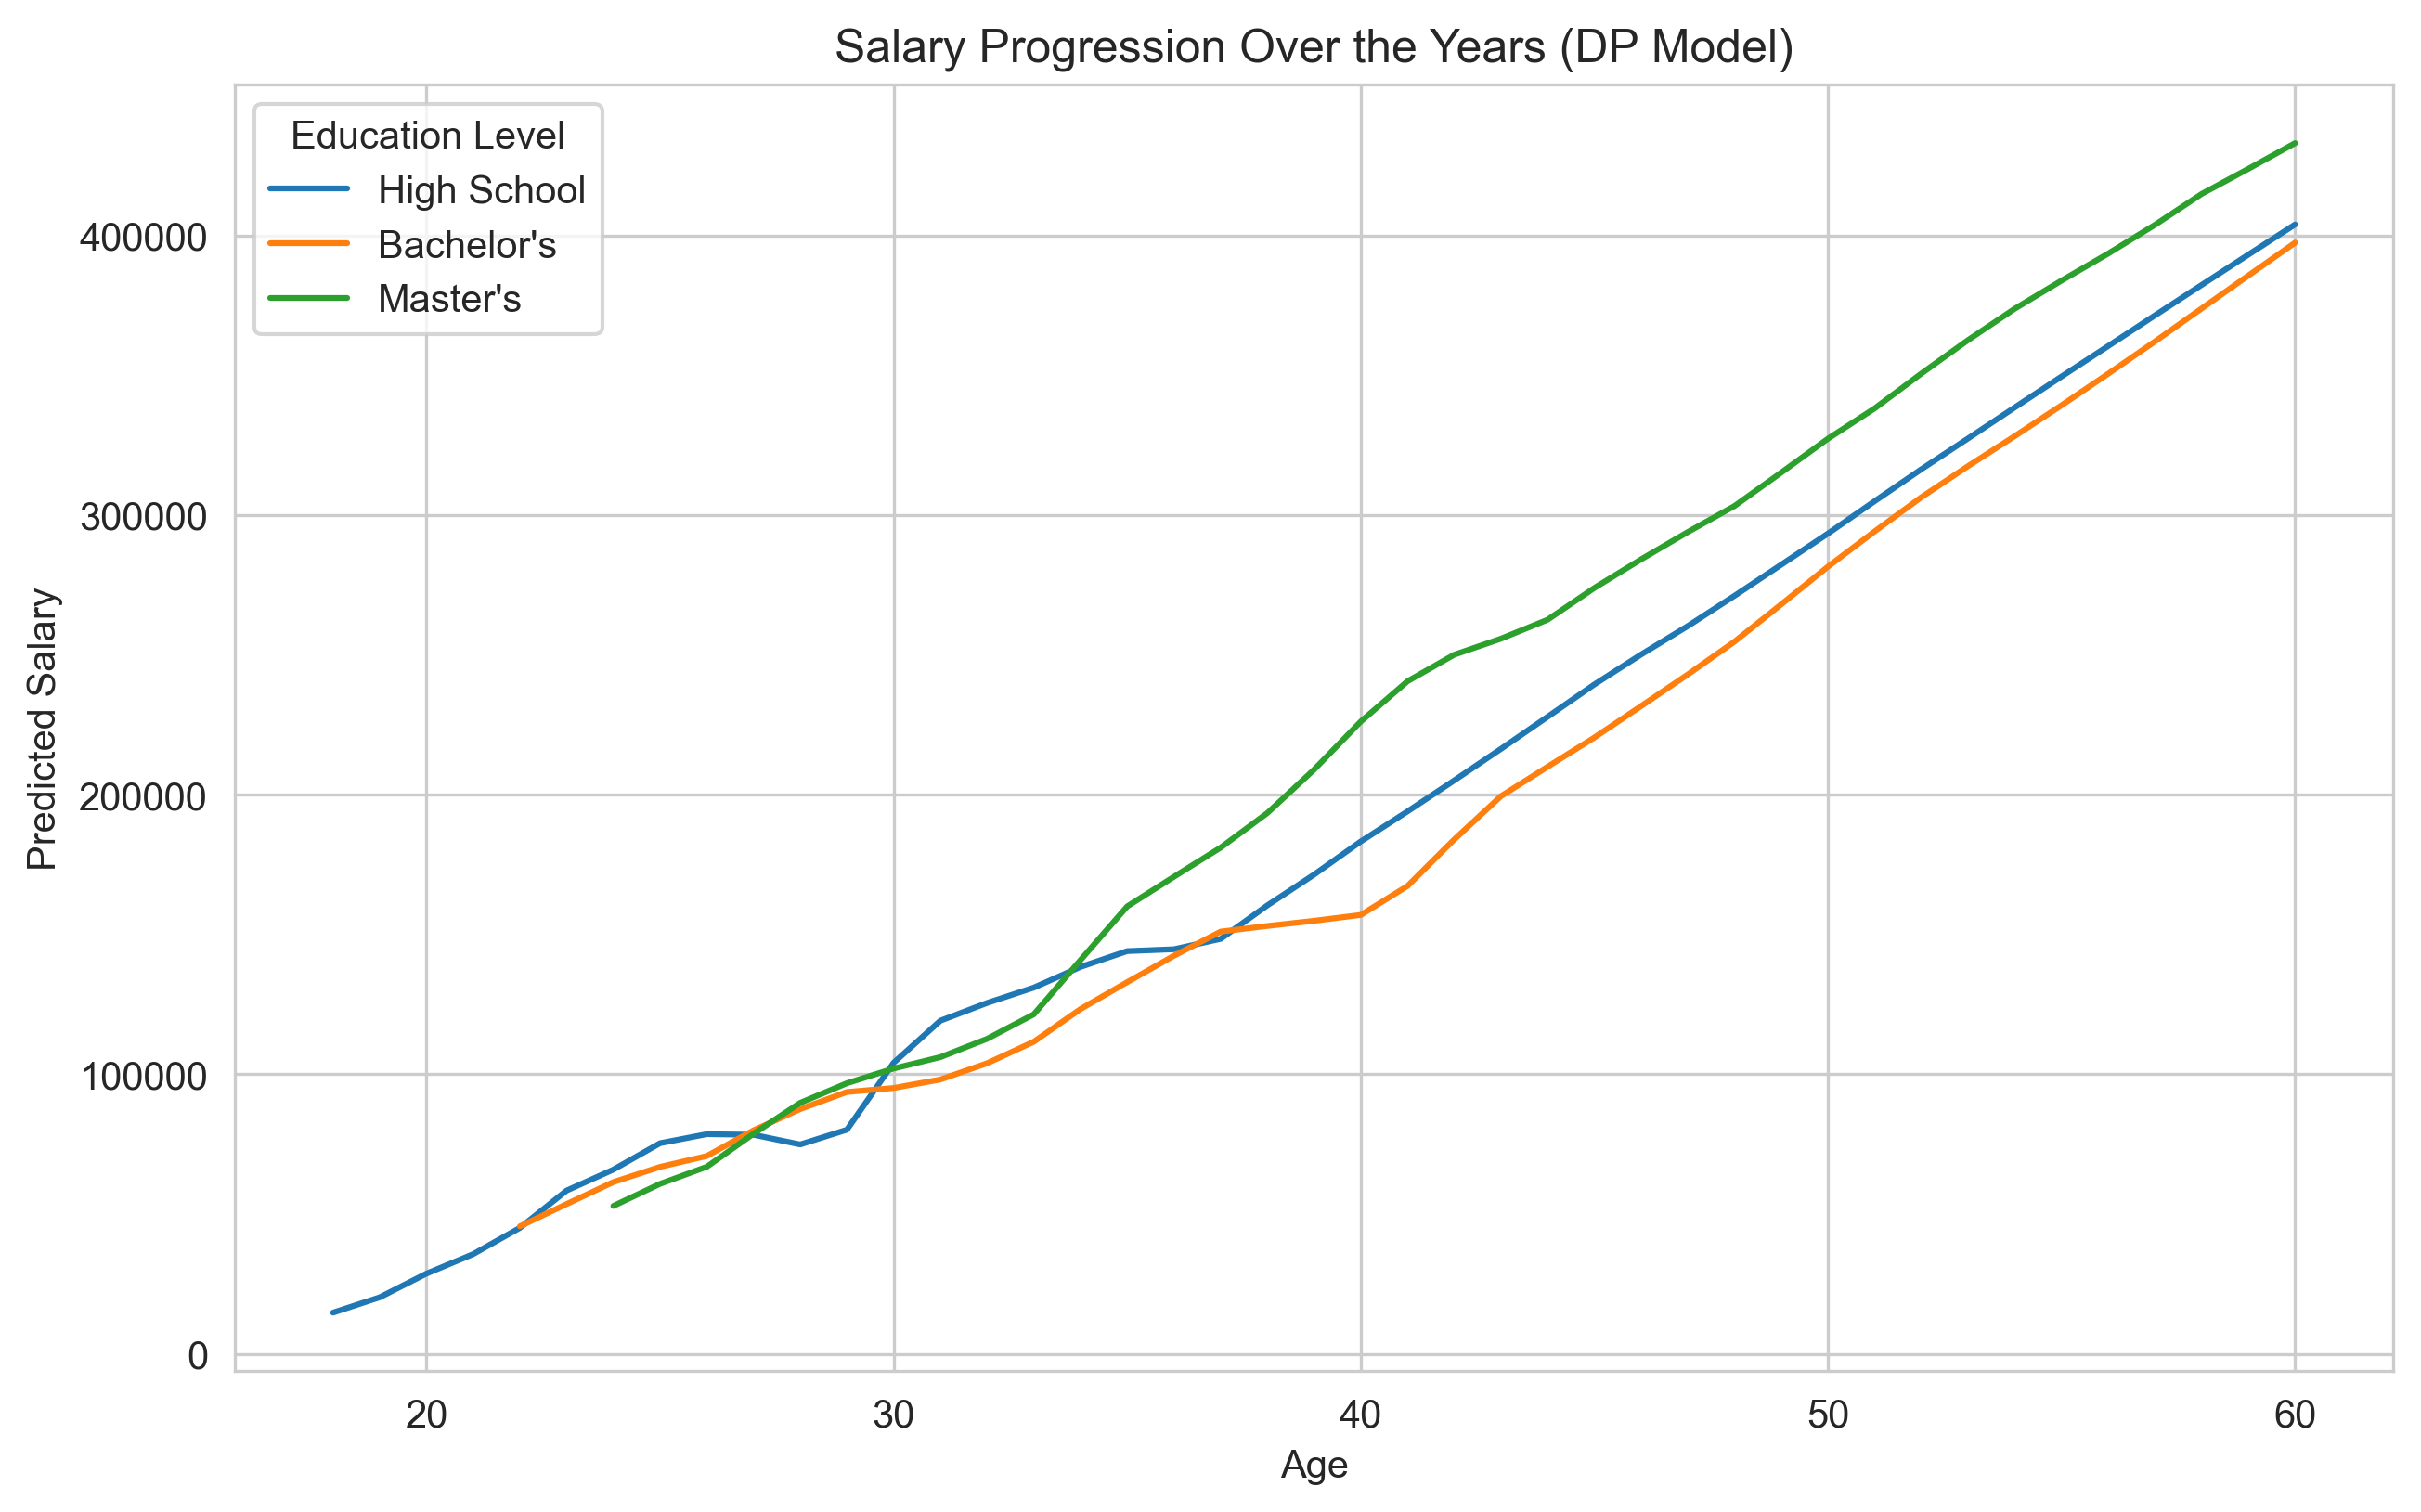

Best education for Job Title: Back end Developer is Master's


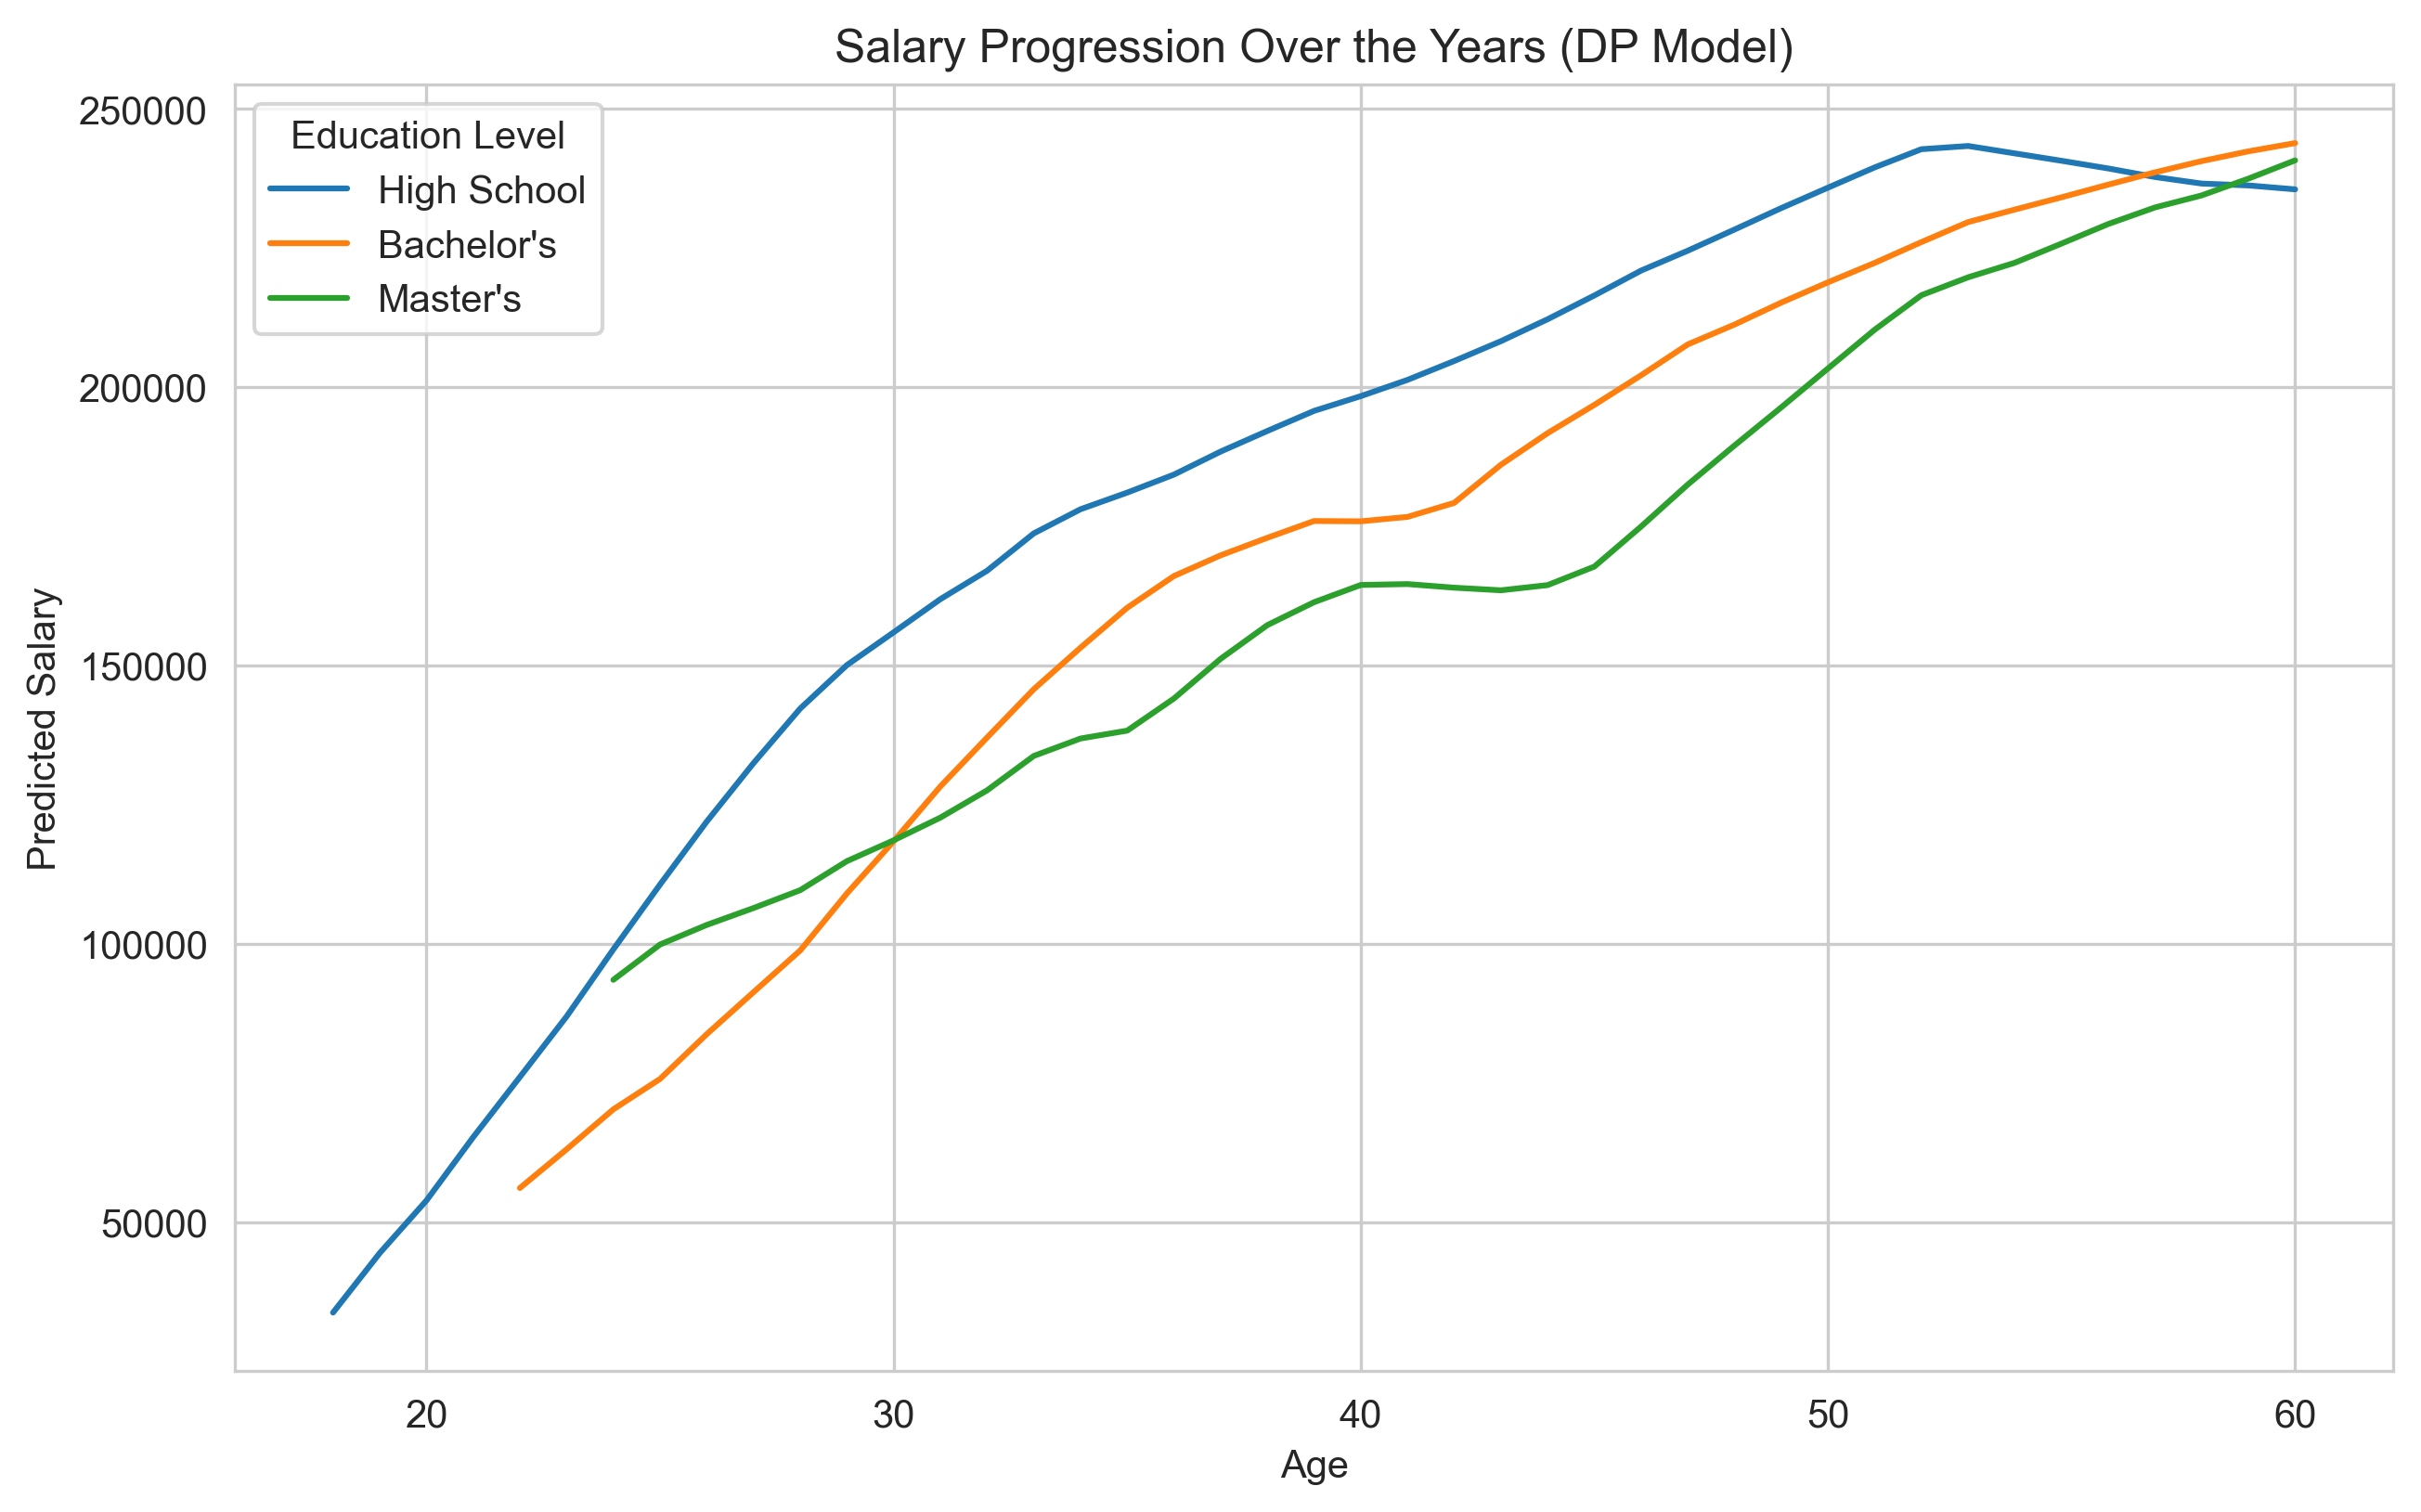

Best education for Job Title: Senior Project Engineer is High School


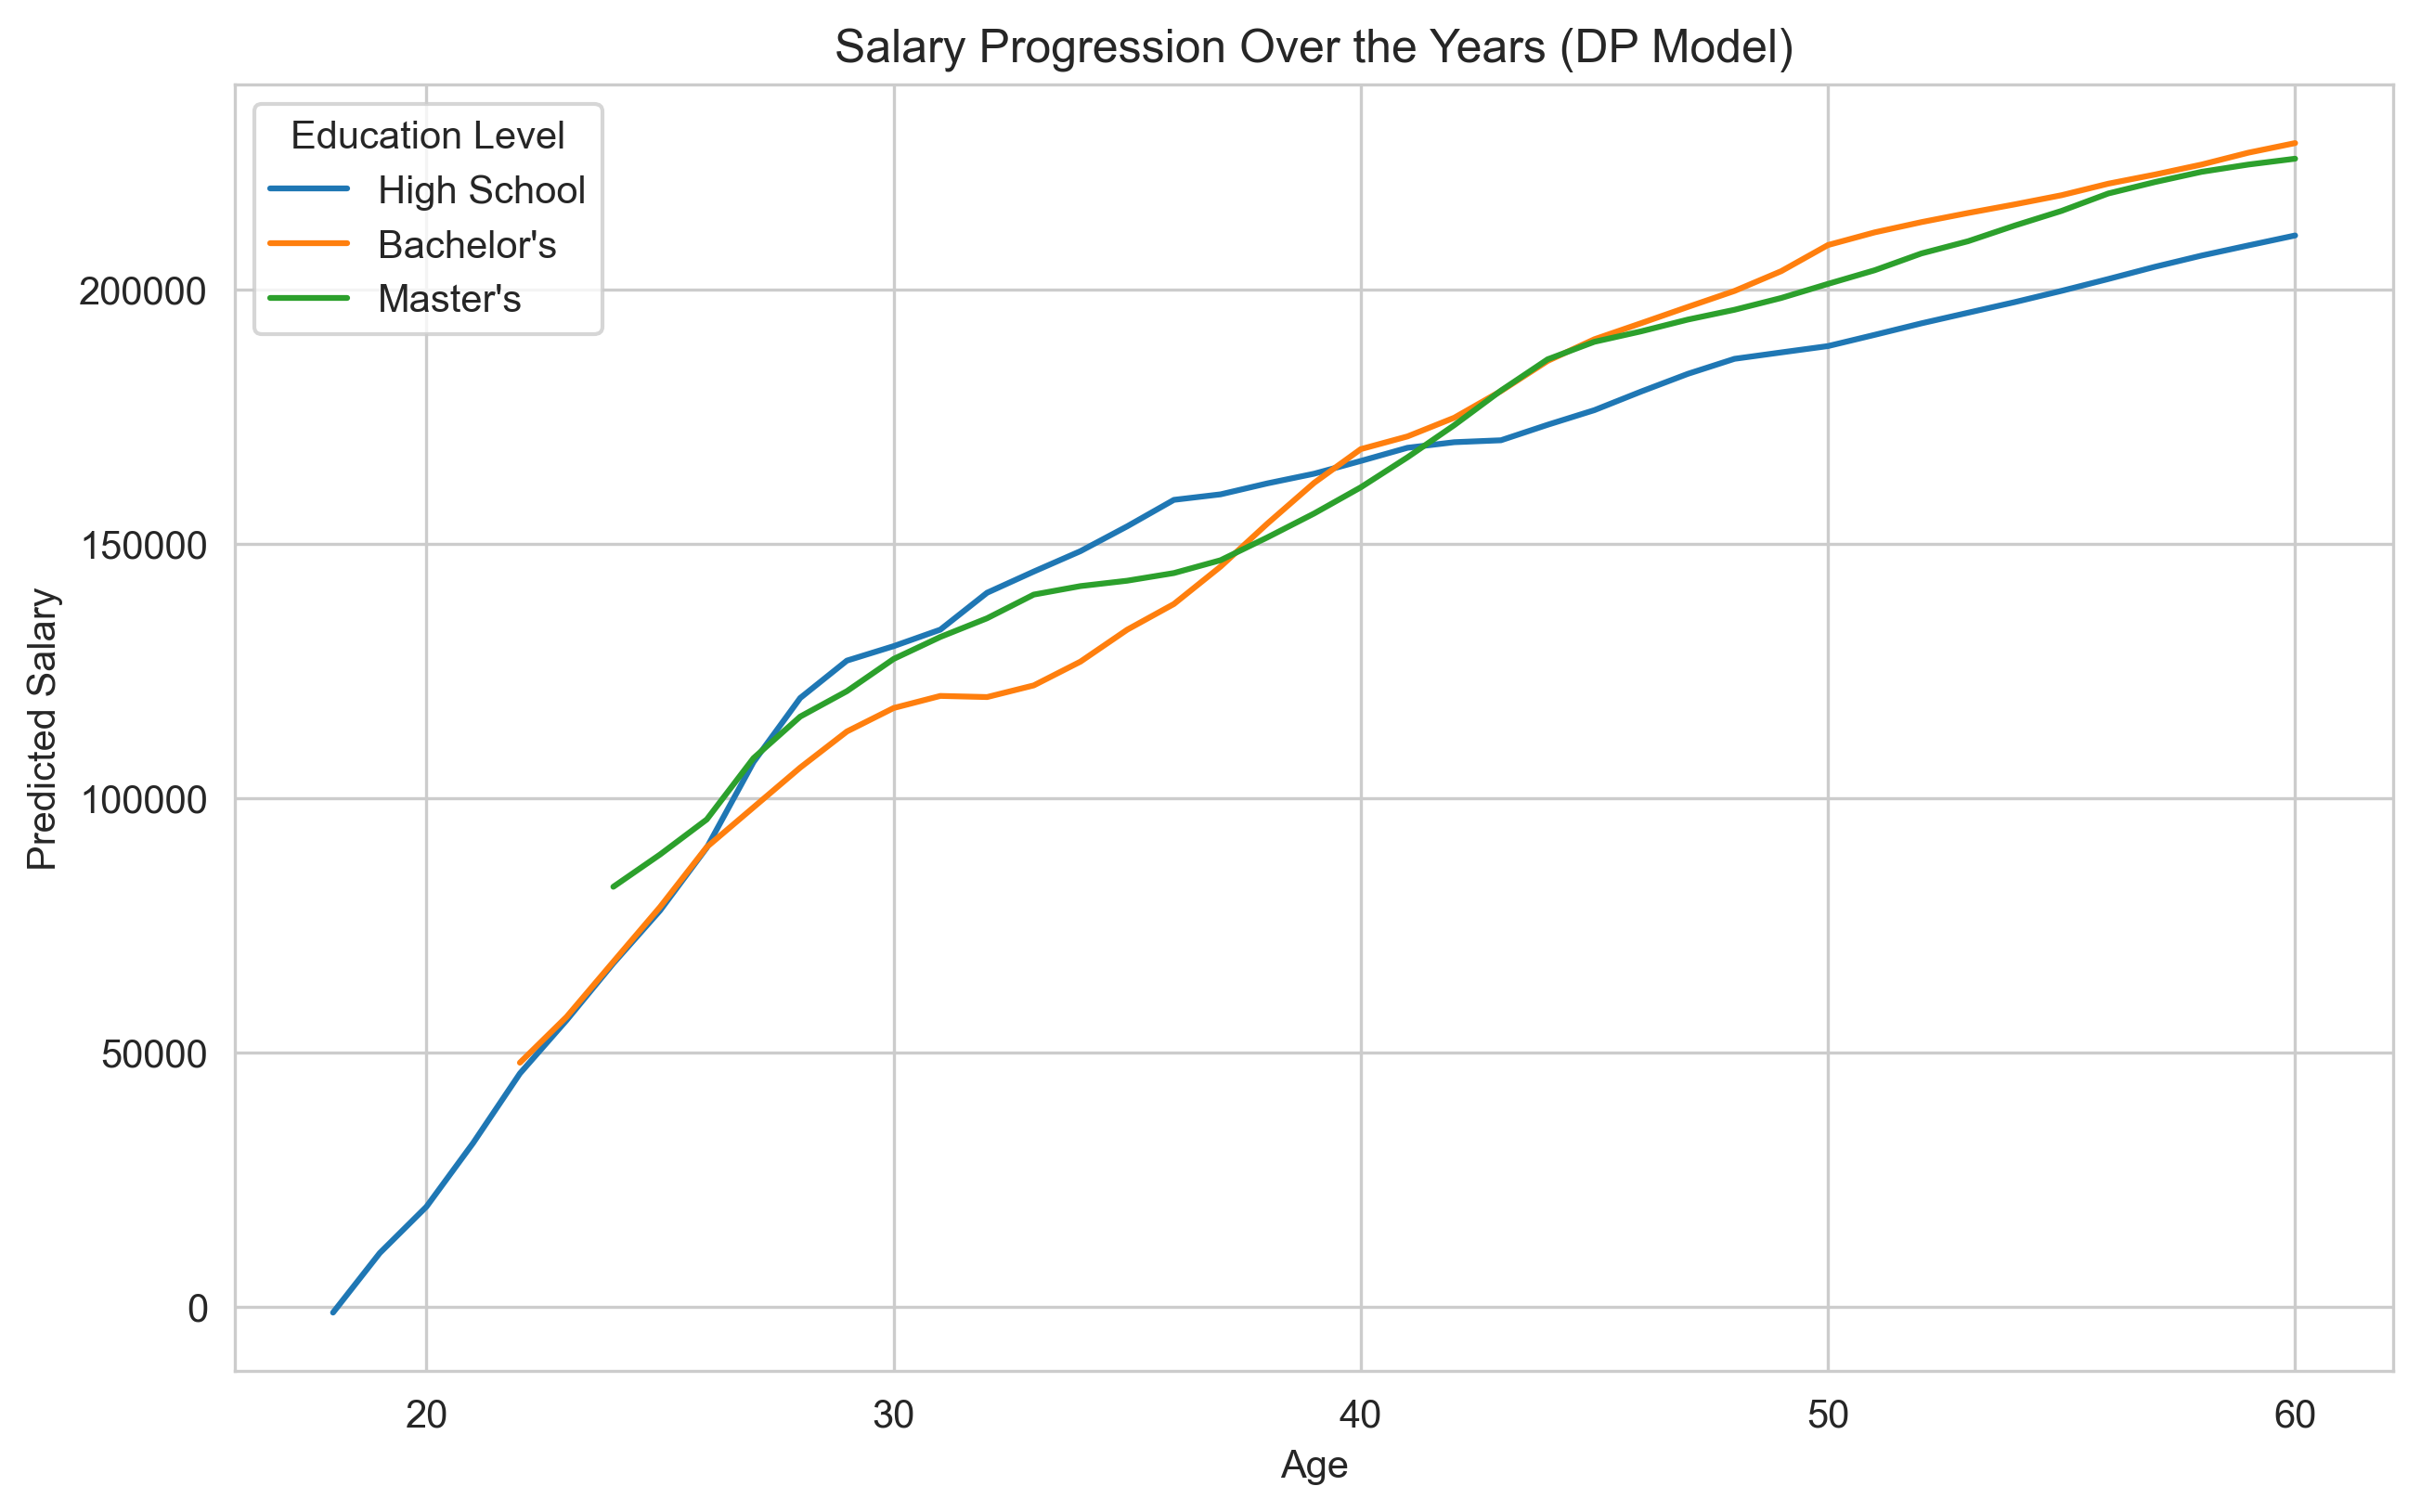

Best education for Job Title: Full Stack Engineer is Bachelor's


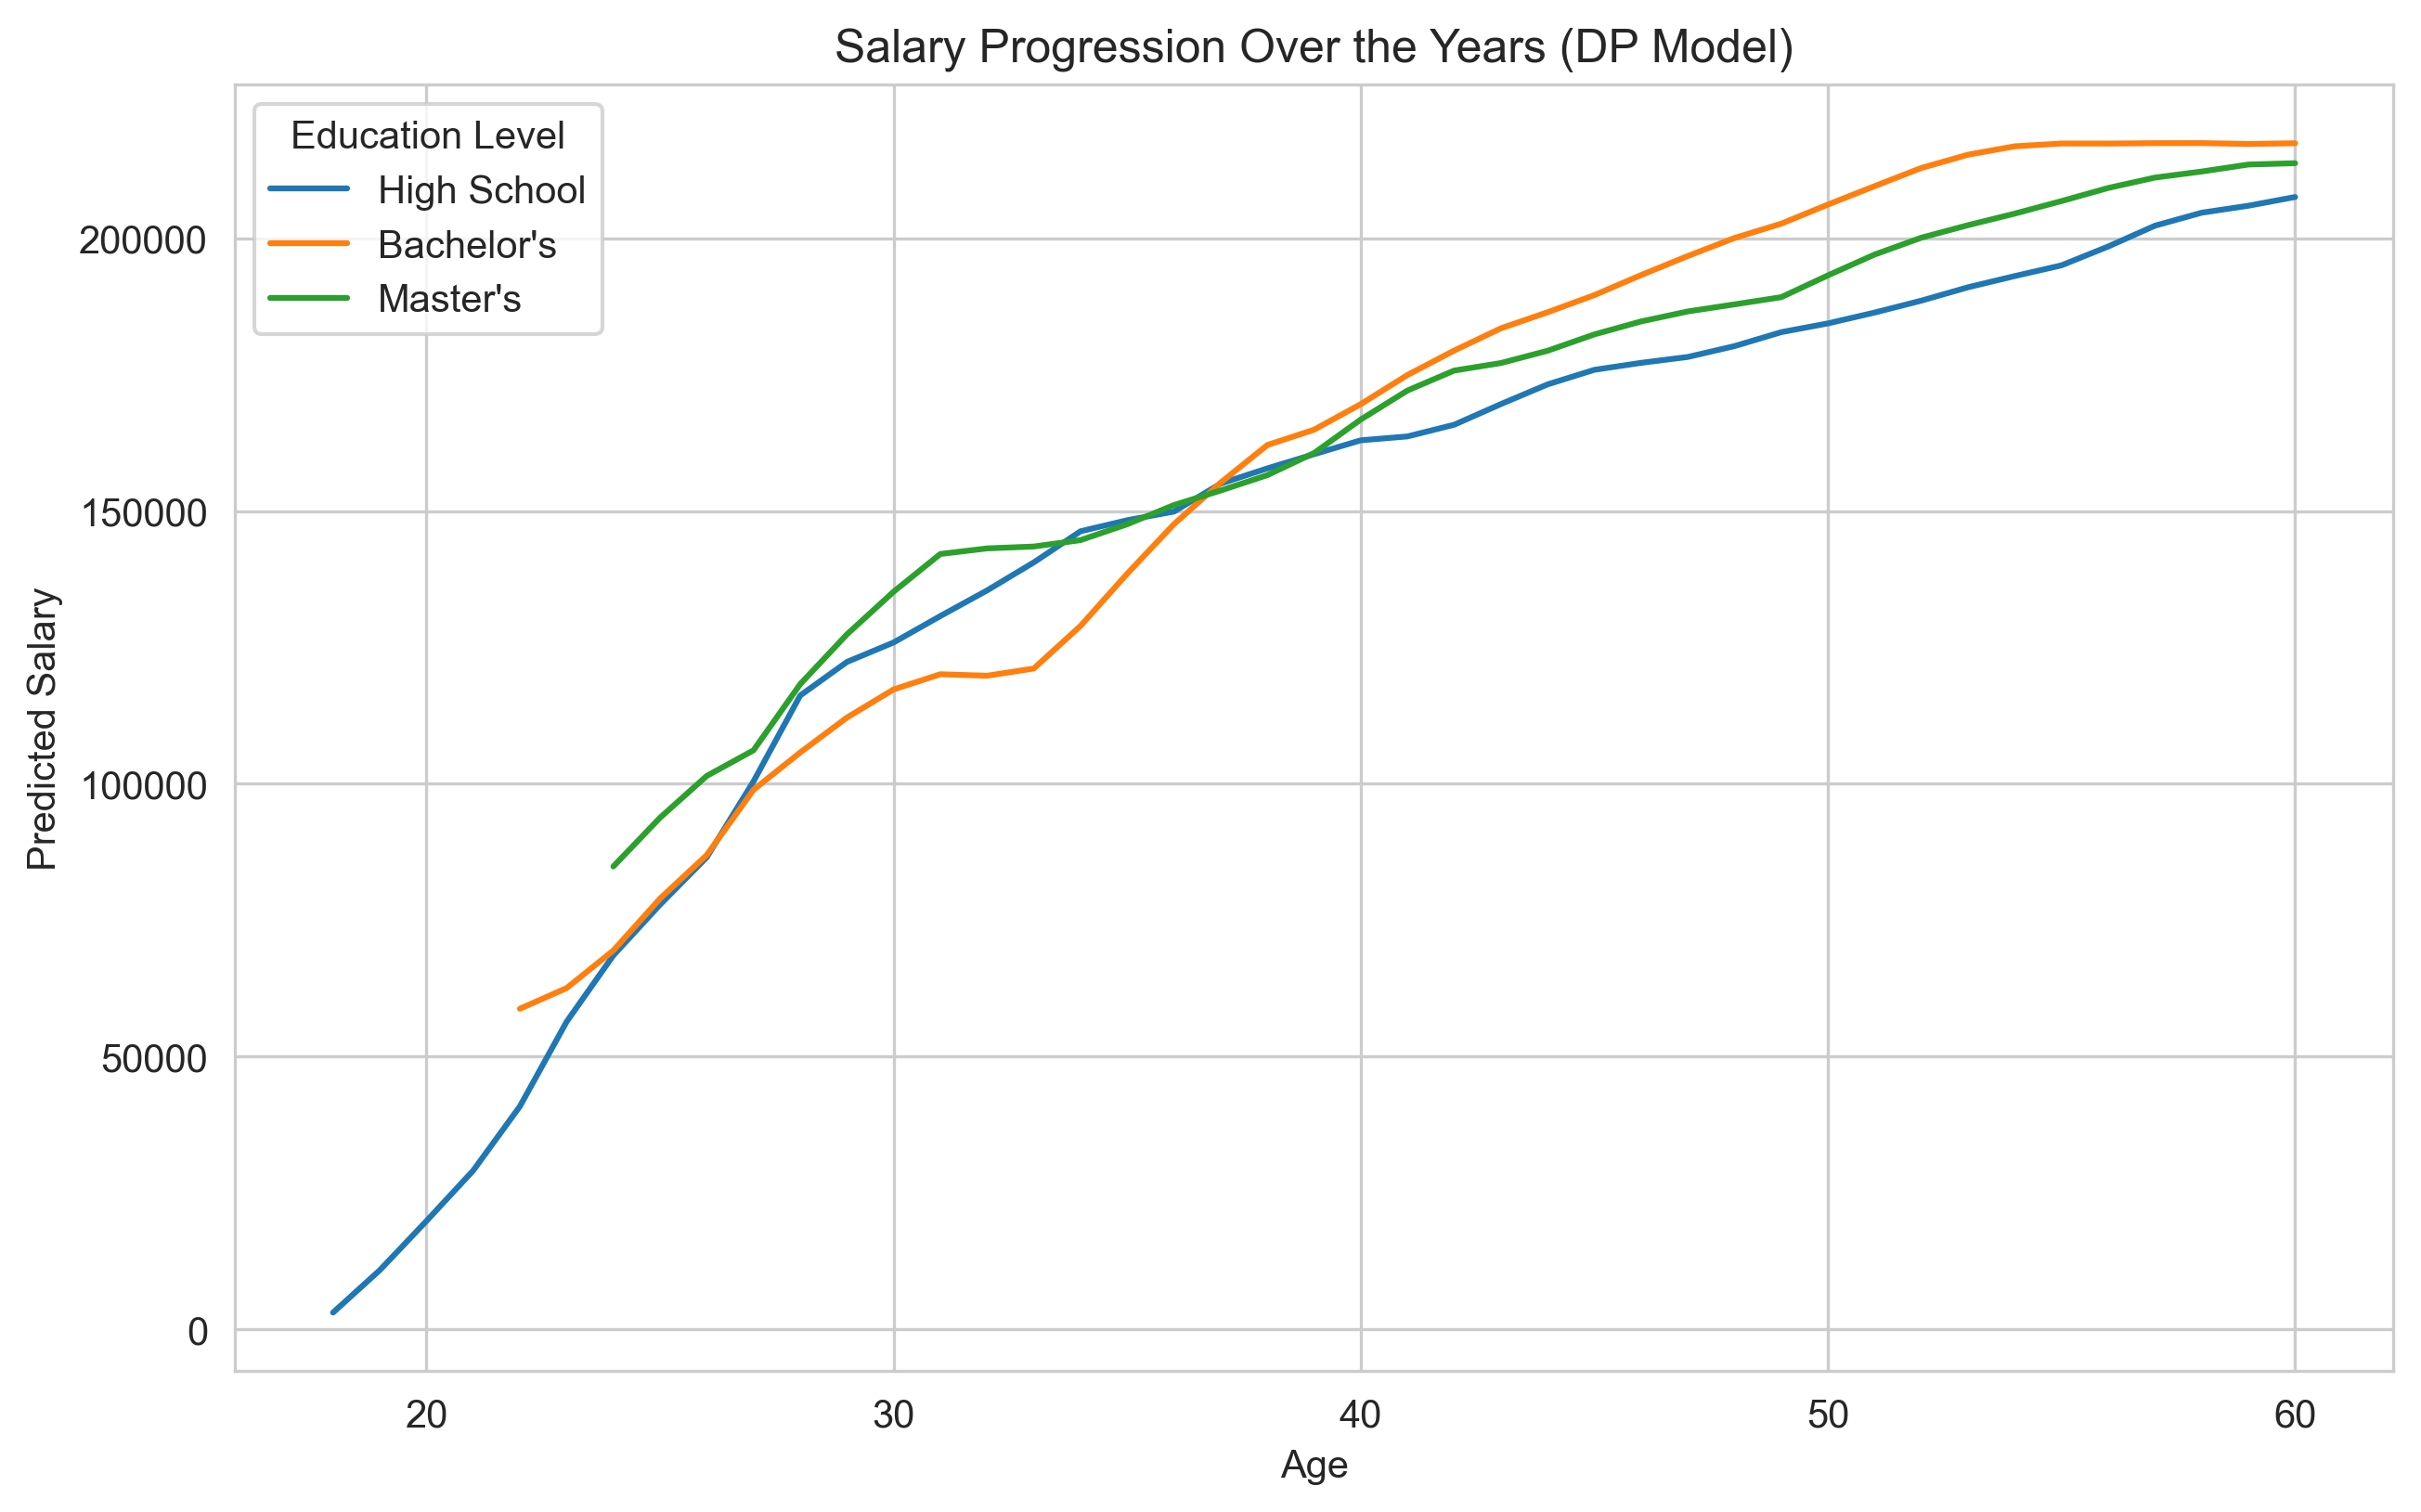

Best education for Job Title: Front end Developer is Bachelor's


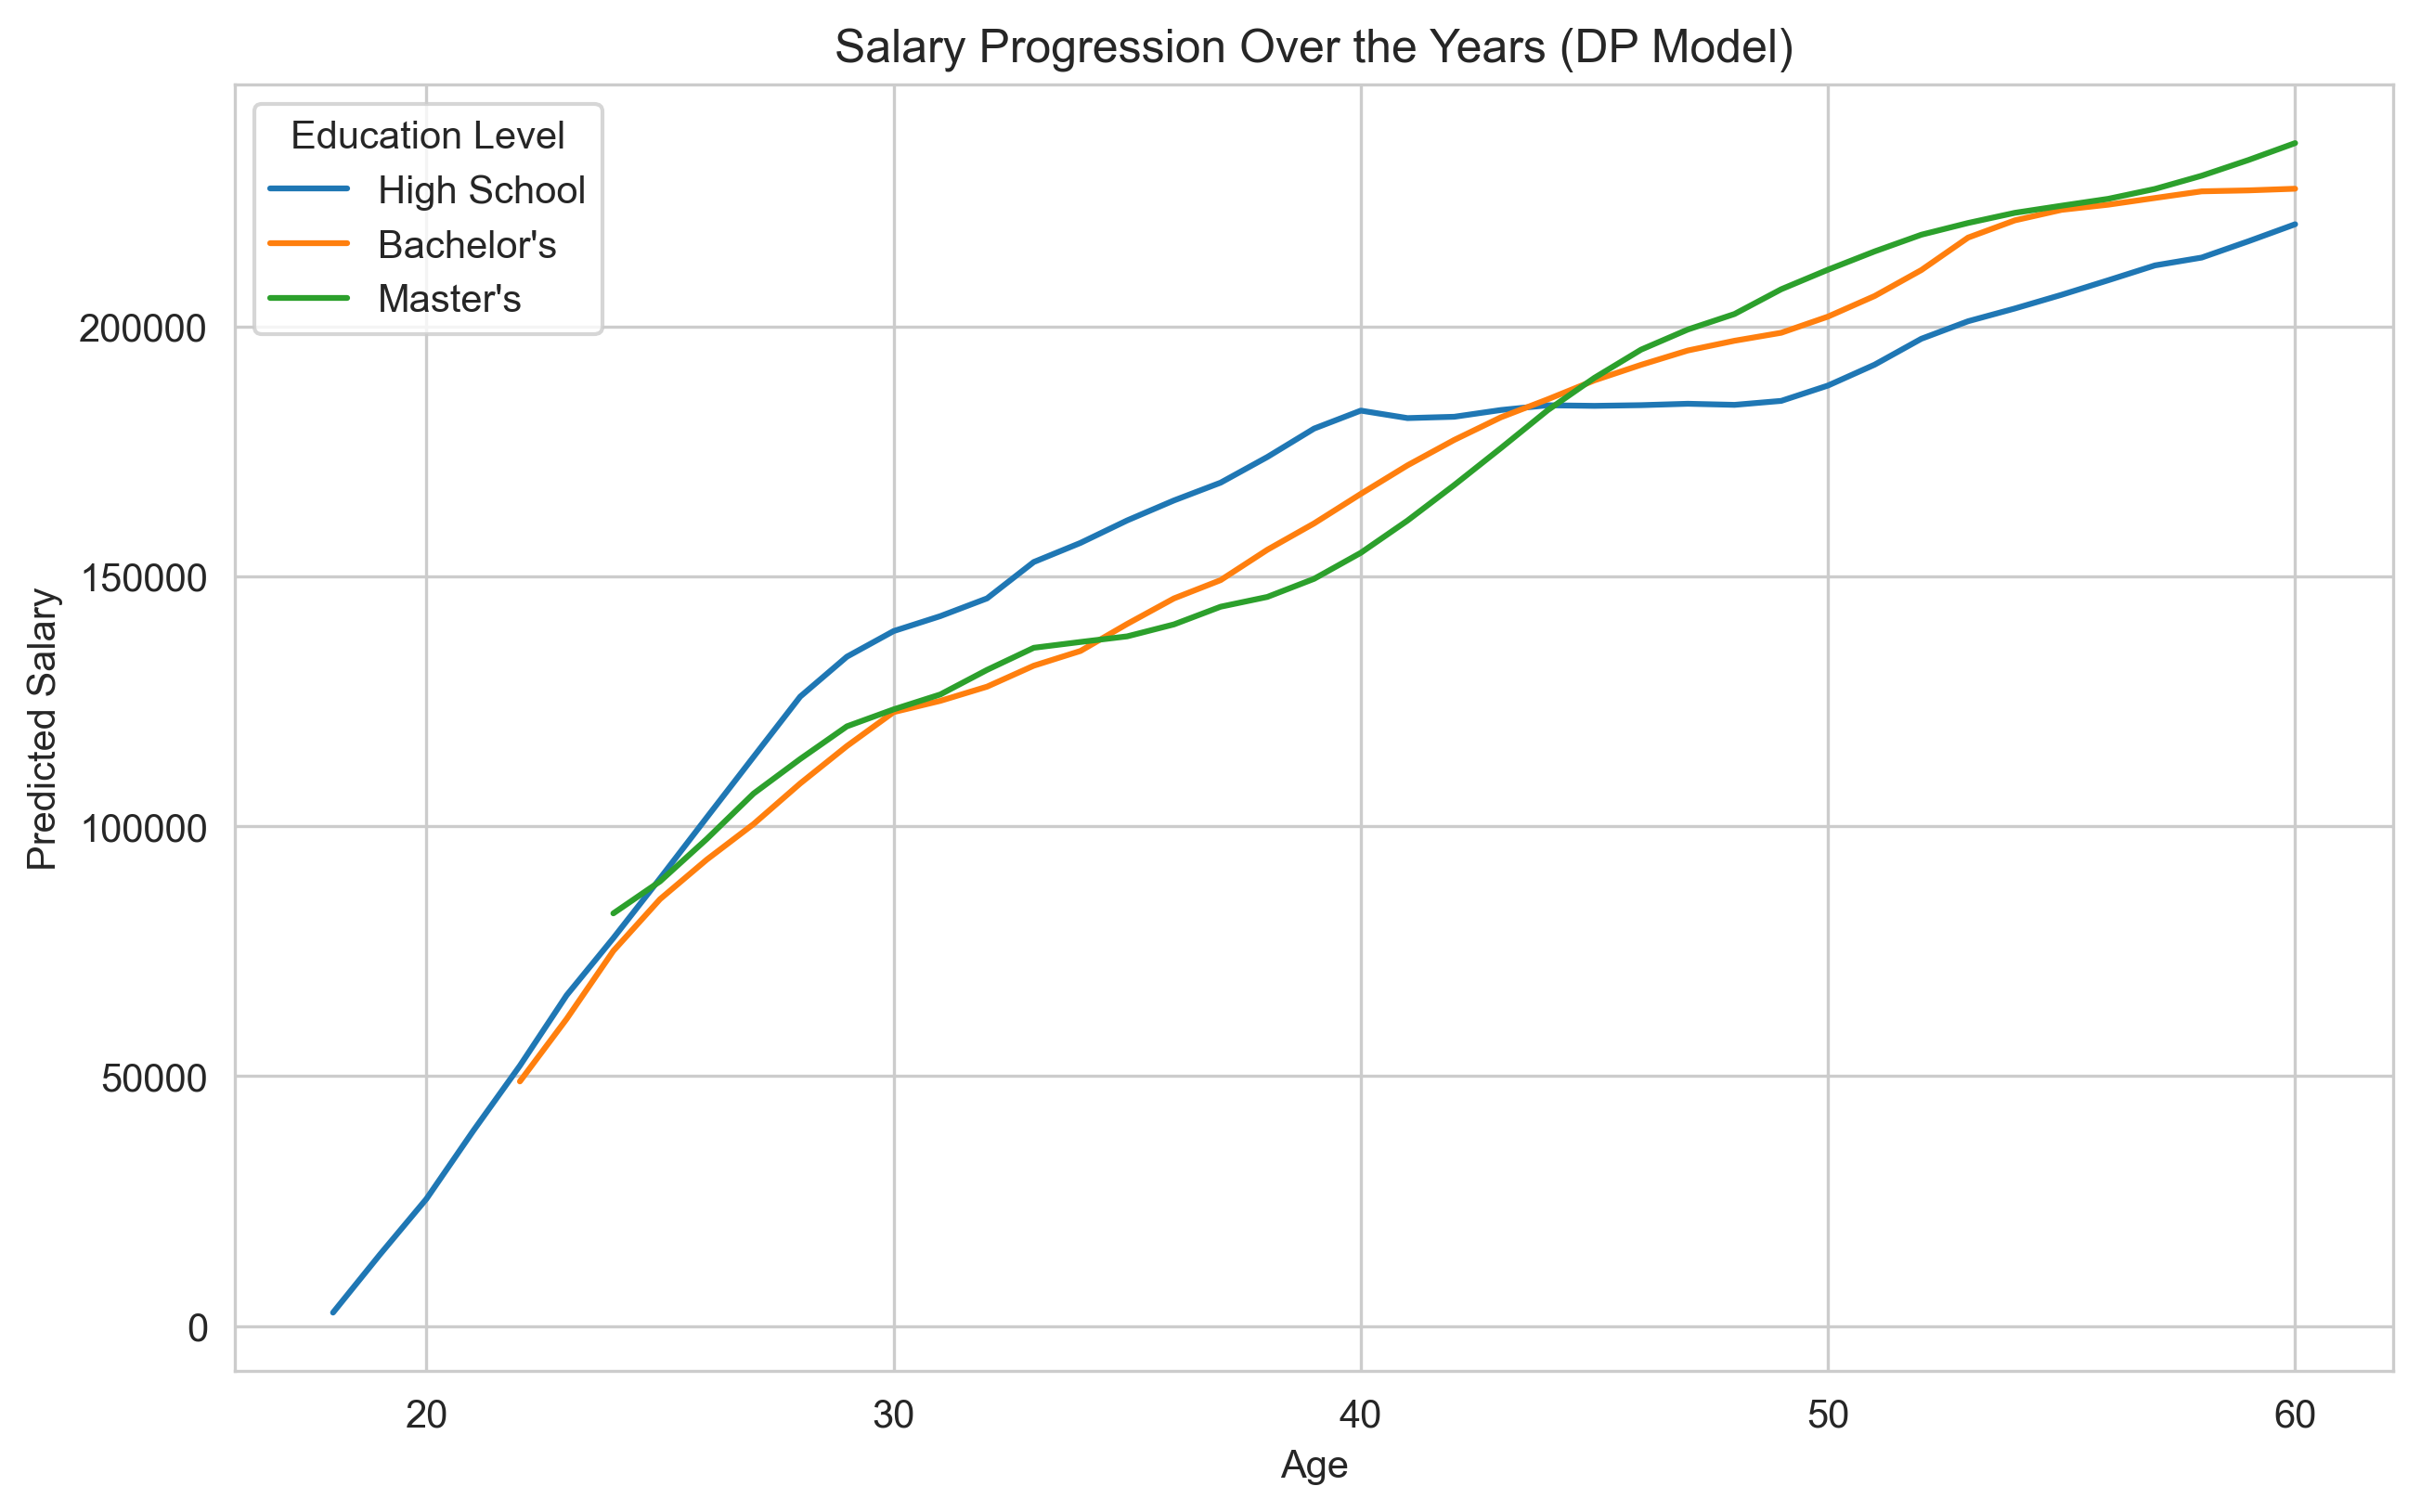

Best education for Job Title: Junior Sales Associate is High School


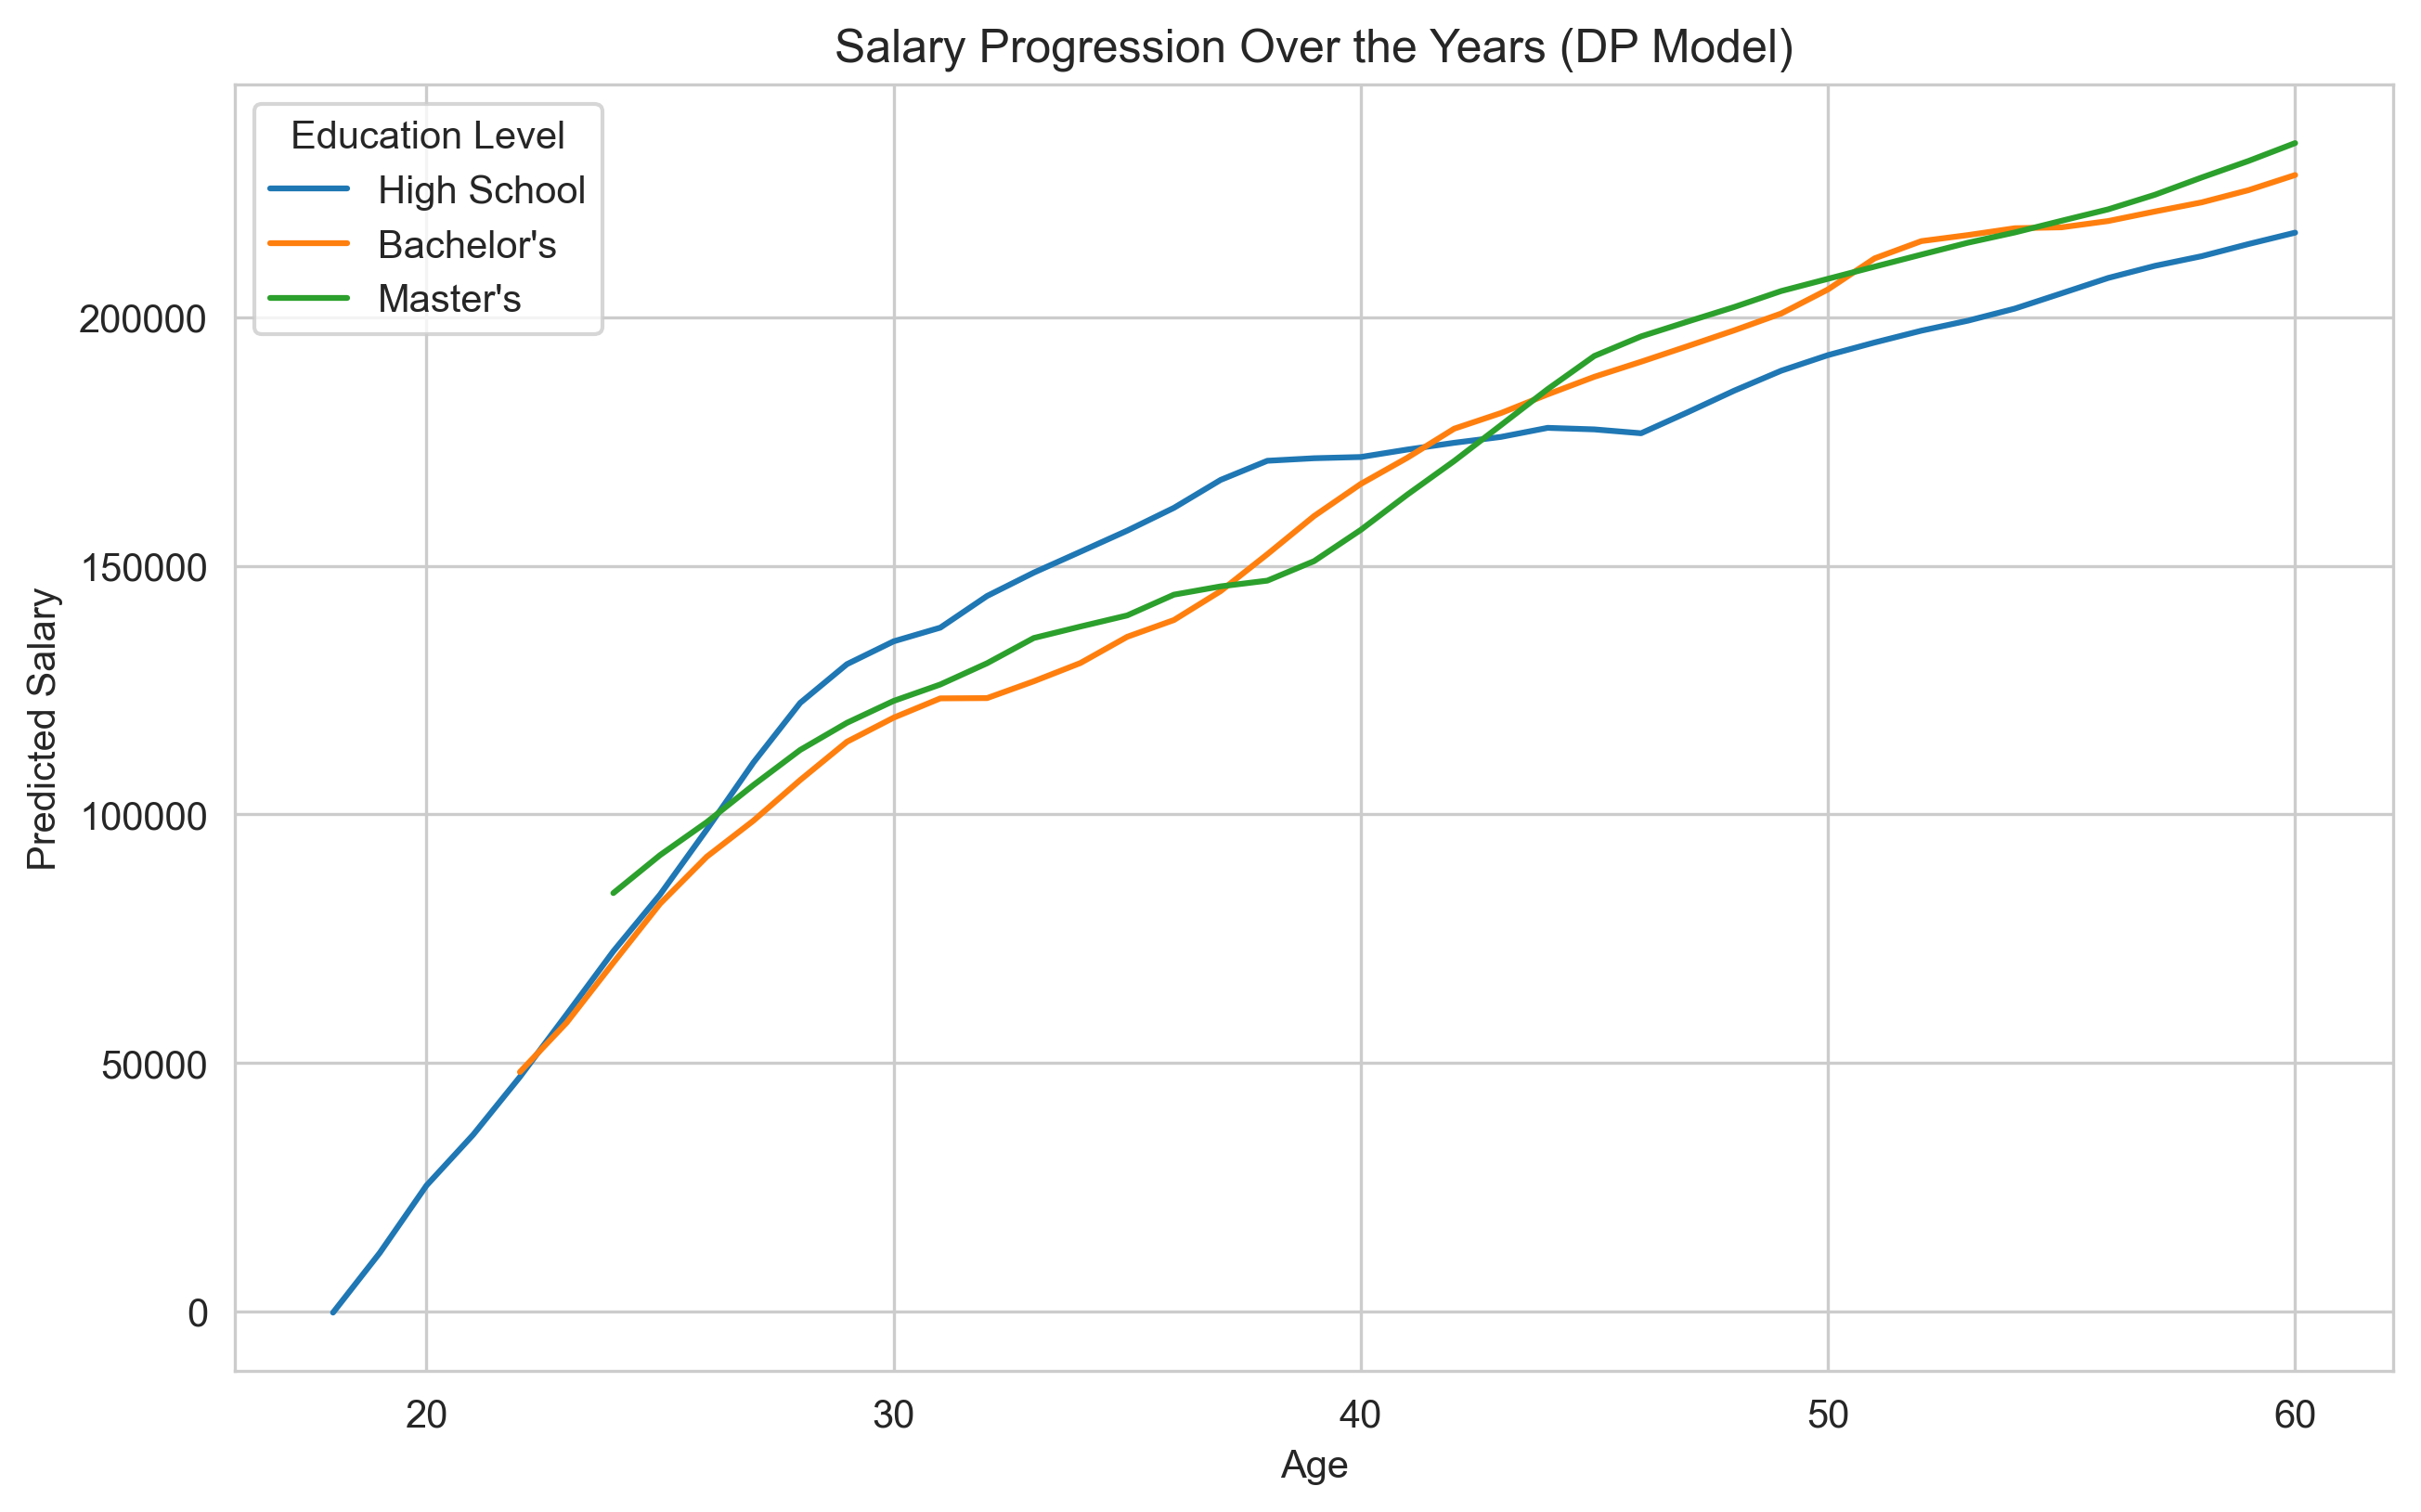

Best education for Job Title: Human Resources Manager is High School


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

start_age = 18
end_age = 60

best_edu_4_job = {}
reversed_education_mapping = {value: key for key, value in education_mapping.items()}

for job in job_list:
    people = [
        {"Gender": "Male", "Education Level": "High School", "Job Title": job, "start_work_age": 18},
        {"Gender": "Male", "Education Level": "Bachelor's", "Job Title": job, "start_work_age": 22},
        {"Gender": "Male", "Education Level": "Master's", "Job Title": job, "start_work_age": 24},
    ]
    
    fake_data_list = []
    for person in people:
        for age in range(start_age, end_age + 1):
            if age < person["start_work_age"]:
                years_of_experience = 0
            else:
                years_of_experience = age - person["start_work_age"]
    
            fake_data_list.append({
                "Age": age,
                "Gender": person["Gender"],
                "Education Level": person["Education Level"],
                "Job Title": person["Job Title"],
                "Years of Experience": years_of_experience,
                "start_work_age": person["start_work_age"]
            })
    
    fake_data = pd.DataFrame(fake_data_list)
    
    def preprocess_data(df):
        df["Gender scaled"] = df["Gender"].map(gender_mapping)
        df["Education Level scaled"] = df["Education Level"].map(education_mapping)
        df['Job Title scaled'] = encoder.transform(df['Job Title'])
        df[["Years of Experience scaled", "Age scaled"]] = scaler.transform(
            df[["Years of Experience", "Age"]]
        )
        feature_cols = ["Age scaled", "Education Level scaled", "Gender scaled", "Job Title scaled", "Years of Experience scaled"]
        X = df[feature_cols].values
    
        return X
    
    
    X_fake = preprocess_data(fake_data)
    
    model_with_dp.eval()
    
    with torch.no_grad():
        X_tensor = torch.tensor(X_fake, dtype=torch.float32)
        dp_preds = model_with_dp(X_tensor)
    
    dp_preds_np = dp_preds.numpy()
    dp_preds_original_scale = salary_scaler.inverse_transform(dp_preds_np)
    fake_data["Predicted Salary"] = dp_preds_original_scale
    
    plt.figure(figsize=(10, 6), dpi=300)
    
    edu_total_sal = []
    for education_level in fake_data["Education Level"].unique():
        subset = fake_data[fake_data["Education Level"] == education_level]
        start_work_age_for_group = subset["start_work_age"].iloc[0]
        subset = subset[subset["Age"] >= start_work_age_for_group]
    
        plt.plot(subset["Age"], subset["Predicted Salary"], label=education_level)
        subset = fake_data[
            (fake_data["Education Level"] == education_level)
            & (fake_data["Age"] >= start_work_age_for_group)
            & (fake_data["Age"] <= 60)
        ]
        
        total_brutto = subset["Predicted Salary"].sum()
        edu_total_sal.append(total_brutto)
    
    max_index = edu_total_sal.index(max(edu_total_sal))
    
    plt.title("Salary Progression Over the Years (DP Model)")
    plt.xlabel("Age")
    plt.ylabel("Predicted Salary")
    plt.ticklabel_format(style='plain', axis='y')
    plt.legend(title="Education Level")
    plt.grid(True)
    plt.show()
    
    print(f"Best education for Job Title: {job} is {reversed_education_mapping.get(max_index)}")
    
    best_edu_4_job.update({job: reversed_education_mapping.get(max_index)})
    

In [34]:
best_edu_4_job

{'Software Engineer': 'High School',
 'Data Analyst': "Master's",
 'Marketing Analyst': 'High School',
 'Product Manager': 'High School',
 'Marketing Coordinator': 'High School',
 'Software Developer': 'High School',
 'Operations Manager': 'High School',
 'Marketing Manager': 'High School',
 'Financial Manager': "Master's",
 'Data Scientist': "Master's",
 'Senior Software Engineer': 'High School',
 'Software Engineer Manager': 'High School',
 'Back end Developer': "Master's",
 'Senior Project Engineer': 'High School',
 'Full Stack Engineer': "Bachelor's",
 'Front end Developer': "Bachelor's",
 'Junior Sales Associate': 'High School',
 'Human Resources Manager': 'High School'}